In [1]:
from pathlib import Path
import pandas as pd
from seiz_eeg.dataset import EEGDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from training import train
from utils import display_metrics, count_parameters, seed_everything
from preprocessing import normalize_z_score, time_filtering

import signatory

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/ogut/data"

DATA_ROOT = Path(data_path)

In [3]:
seed_everything(1)

In [4]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [5]:
"""
Based on https://ieeexplore.ieee.org/document/10381774
"""

class SlidingWindowBatch(nn.Module):
    def __init__(self, window_size=125):
        super().__init__()
        self.window_size = window_size

    def forward(self, data):
        batch_size, signal_len, channels = data.shape
        num_windows = signal_len // self.window_size

        windows = []
        for i in range(num_windows):
            start = i * self.window_size
            end = start + self.window_size
            window = data[:, start:end, :]  # shape: (batch_size, window_size, 19)
            windows.append(window)

        windows = torch.stack(windows, dim=1)  # shape: (batch_size, num_windows, window_size, 19)
        return windows

class SignatureEncoder(nn.Module):
    def __init__(self, input_channels, depth=2, add_time=True):
        """
        Args:
            input_channels (int): number of input channels (without time).
            depth (int): signature depth.
            add_time (bool): whether to augment with time channel.
        """
        super().__init__()
        self.input_channels = input_channels
        self.depth = depth
        self.add_time = add_time
        
        self.total_channels = input_channels + 1 if add_time else input_channels
        self.output_channels = signatory.signature_channels(self.total_channels, self.depth)

    def forward(self, x):
        """
        Args:
            x (Tensor): shape (batch_size, windows, channels, time)

        Returns:
            Tensor: shape (batch_size, windows, output_channels)
        """
        batch_size, n_windows, n_time, n_channels = x.shape

        # Step 2: flatten batch and window dimensions
        x = x.reshape(batch_size * n_windows, n_time, n_channels)

        # Step 3: add time if needed
        if self.add_time:
            time = torch.linspace(0, 1, n_time, device=x.device).unsqueeze(0).unsqueeze(-1)
            time = time.expand(x.size(0), -1, -1)  # (batch_size * windows, time, 1)
            x = torch.cat([time, x], dim=-1)  # (batch_size * windows, time, channels+1)

        # Step 4: compute signature
        sig = signatory.signature(x, depth=self.depth)  # (batch_size * windows, output_channels)

        # Step 5: reshape back to (batch_size, windows, output_channels)
        sig = sig.view(batch_size, n_windows, self.output_channels)

        return sig
    
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        """
        Args:
            hidden_dim: dimension of BiLSTM output (hidden_size * 2 if BiLSTM)
            attn_dim: dimension of intermediate MLP hidden layer
        """
        super().__init__()
        self.attention_mlp = nn.Linear(hidden_dim, attn_dim)
        self.context_vector = nn.Parameter(torch.randn(attn_dim))

    def forward(self, h):
        """
        Args:
            h: Tensor of shape (batch_size, seq_len, hidden_dim)
        
        Returns:
            s: Tensor of shape (batch_size, hidden_dim)
        """
        # Step 1: compute ut = tanh(Wh + b)
        u = torch.tanh(self.attention_mlp(h))  # (batch_size, seq_len, attn_dim)

        # Step 2: compute scores: dot(u_t, u_w)
        # context_vector: (attn_dim,)
        scores = torch.matmul(u, self.context_vector)  # (batch_size, seq_len)

        # Step 3: softmax over time
        alpha = F.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Step 4: weighted sum of h
        s = torch.bmm(alpha.unsqueeze(1), h)  # (batch_size, 1, hidden_dim)
        s = s.squeeze(1)  # (batch_size, hidden_dim)

        return s

class CombinedModel(nn.Module):
    def __init__(self, output_size=1, window_size=125, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64):
        super().__init__()

        # Sliding window batch layer
        self.sliding_window = SlidingWindowBatch(window_size=window_size)

        # Path Signature feature extraction
        self.signature_extraction = SignatureEncoder(input_channels=19, depth=2, add_time=True)

        # Projection to the size of the BiLSTM input
        self.projection = nn.Linear(self.signature_extraction.output_channels, lstm_input_size)

        self.norm = nn.BatchNorm1d(num_features=lstm_input_size)
        self.activation = nn.GELU()

        # BiLSTM
        self.bilstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, num_layers=3, batch_first=True, bidirectional=True, dropout=0.5)

        # Attention
        self.attention = TemporalAttention(lstm_hidden_size * 2, attention_dim)

        # Final output layer
        self.output_layer = nn.Linear(lstm_hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Apply sliding window on input
        windows = self.sliding_window(x)  # shape: (batch_size, num_windows, window_size, 19)

        # Apply signature extraction
        windows = self.signature_extraction(windows) # shape: (batch_size, num_windows, output_dim)

        # Projection layer
        windows = self.projection(windows)  # shape: (batch_size, num_windows, lstm_input_dim)

        windows = self.norm(windows.transpose(1,2)).transpose(1,2)
        windows = self.activation(windows)

        # Apply BiLSTM
        lstm_out, _ = self.bilstm(windows)  # shape: (batch_size, num_windows, lstm_hidden_size * 2)

        # Apply Attention
        weighted_attention = self.attention(lstm_out) # shape: (batch_size, lstm_hidden_size * 2)

        # Final output layer
        out = self.output_layer(weighted_attention)  # shape: (batch_size, output_size)

        return out


In [6]:
device = torch.device('cuda')
NUM_EPOCHS = 1000
model = CombinedModel(output_size=1, window_size=125, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64)
model.to(device)

CombinedModel(
  (sliding_window): SlidingWindowBatch()
  (signature_extraction): SignatureEncoder()
  (projection): Linear(in_features=420, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): GELU(approximate='none')
  (bilstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): TemporalAttention(
    (attention_mlp): Linear(in_features=256, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
count_parameters(model)

1125633

In [8]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=time_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [9]:
device = torch.device('cuda')

#train_set, test_set, val_set = torch.utils.data.random_split(dataset_tr,[0.7,0.2,0.1])
train_set, val_set = torch.utils.data.random_split(dataset_tr,[0.9,0.1])

#Check worker_init_fn
loader_tr = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=0)
loader_val = DataLoader(val_set, batch_size=512, shuffle=True, num_workers=0)
#loader_ts = DataLoader(test_set, batch_size=512, shuffle=True, num_workers=0)

# positives = 0
# negatives = 0
# for idx, data in enumerate(loader_tr):
#     positives += data[1].sum()
#     negatives += len(data[1]) - data[1].sum()

# pos_weight = negatives / positives
# pos_weight_tensor = torch.tensor([pos_weight]).to(torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
criterion = torch.nn.BCEWithLogitsLoss()

In [10]:
metrics = train(model, NUM_EPOCHS, device, loader_tr, loader_val, optimizer, criterion, verbose=True)

Epoch 1: 100%|██████████| 23/23 [00:03<00:00,  6.85it/s]


Train Loss: 0.5294,  Train Accuracy: 0.8042,  Train F1-Score: 0.0000, 
Val Loss: 0.4556,  Val Accuracy: 0.8252,  Val F1-Score: 0.0000, 




Epoch 2: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.4625,  Train Accuracy: 0.8172,  Train F1-Score: 0.1415, 
Val Loss: 0.3971,  Val Accuracy: 0.8574,  Val F1-Score: 0.2852, 




Epoch 3: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.4324,  Train Accuracy: 0.8398,  Train F1-Score: 0.3635, 
Val Loss: 0.4075,  Val Accuracy: 0.8550,  Val F1-Score: 0.2924, 




Epoch 4: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.4321,  Train Accuracy: 0.8388,  Train F1-Score: 0.3197, 
Val Loss: 0.3984,  Val Accuracy: 0.8568,  Val F1-Score: 0.3048, 




Epoch 5: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.4181,  Train Accuracy: 0.8478,  Train F1-Score: 0.4030, 
Val Loss: 0.3827,  Val Accuracy: 0.8669,  Val F1-Score: 0.3668, 




Epoch 6: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.4148,  Train Accuracy: 0.8480,  Train F1-Score: 0.3930, 
Val Loss: 0.3836,  Val Accuracy: 0.8675,  Val F1-Score: 0.3911, 




Epoch 7: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.4105,  Train Accuracy: 0.8505,  Train F1-Score: 0.4073, 
Val Loss: 0.3831,  Val Accuracy: 0.8656,  Val F1-Score: 0.3772, 




Epoch 8: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.4065,  Train Accuracy: 0.8534,  Train F1-Score: 0.4243, 
Val Loss: 0.3919,  Val Accuracy: 0.8642,  Val F1-Score: 0.3599, 




Epoch 9: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.4108,  Train Accuracy: 0.8493,  Train F1-Score: 0.3911, 
Val Loss: 0.3850,  Val Accuracy: 0.8657,  Val F1-Score: 0.4027, 




Epoch 10: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.4017,  Train Accuracy: 0.8560,  Train F1-Score: 0.4461, 
Val Loss: 0.3894,  Val Accuracy: 0.8631,  Val F1-Score: 0.3826, 




Epoch 11: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.4026,  Train Accuracy: 0.8532,  Train F1-Score: 0.4158, 
Val Loss: 0.3811,  Val Accuracy: 0.8653,  Val F1-Score: 0.4102, 




Epoch 12: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.3969,  Train Accuracy: 0.8563,  Train F1-Score: 0.4483, 
Val Loss: 0.3831,  Val Accuracy: 0.8660,  Val F1-Score: 0.4103, 




Epoch 13: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.3995,  Train Accuracy: 0.8556,  Train F1-Score: 0.4515, 
Val Loss: 0.3835,  Val Accuracy: 0.8692,  Val F1-Score: 0.4040, 




Epoch 14: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.4035,  Train Accuracy: 0.8511,  Train F1-Score: 0.4571, 
Val Loss: 0.3984,  Val Accuracy: 0.8539,  Val F1-Score: 0.3050, 




Epoch 15: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.4203,  Train Accuracy: 0.8418,  Train F1-Score: 0.3246, 
Val Loss: 0.3953,  Val Accuracy: 0.8566,  Val F1-Score: 0.3015, 




Epoch 16: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


Train Loss: 0.3976,  Train Accuracy: 0.8530,  Train F1-Score: 0.4139, 
Val Loss: 0.3922,  Val Accuracy: 0.8553,  Val F1-Score: 0.3338, 




Epoch 17: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3971,  Train Accuracy: 0.8562,  Train F1-Score: 0.4415, 
Val Loss: 0.3780,  Val Accuracy: 0.8662,  Val F1-Score: 0.3743, 




Epoch 18: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.3878,  Train Accuracy: 0.8589,  Train F1-Score: 0.4545, 
Val Loss: 0.3776,  Val Accuracy: 0.8665,  Val F1-Score: 0.4097, 




Epoch 19: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3855,  Train Accuracy: 0.8599,  Train F1-Score: 0.4650, 
Val Loss: 0.3703,  Val Accuracy: 0.8663,  Val F1-Score: 0.4136, 




Epoch 20: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.3801,  Train Accuracy: 0.8613,  Train F1-Score: 0.4847, 
Val Loss: 0.3571,  Val Accuracy: 0.8736,  Val F1-Score: 0.4632, 




Epoch 21: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.3791,  Train Accuracy: 0.8615,  Train F1-Score: 0.4812, 
Val Loss: 0.3670,  Val Accuracy: 0.8667,  Val F1-Score: 0.4187, 




Epoch 22: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3789,  Train Accuracy: 0.8616,  Train F1-Score: 0.4913, 
Val Loss: 0.3651,  Val Accuracy: 0.8727,  Val F1-Score: 0.4591, 




Epoch 23: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3804,  Train Accuracy: 0.8599,  Train F1-Score: 0.4546, 
Val Loss: 0.3621,  Val Accuracy: 0.8687,  Val F1-Score: 0.4364, 




Epoch 24: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.4276,  Train Accuracy: 0.8253,  Train F1-Score: 0.3985, 
Val Loss: 0.4071,  Val Accuracy: 0.8452,  Val F1-Score: 0.1862, 




Epoch 25: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.4318,  Train Accuracy: 0.8277,  Train F1-Score: 0.2178, 
Val Loss: 0.4083,  Val Accuracy: 0.8407,  Val F1-Score: 0.1480, 




Epoch 26: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.4108,  Train Accuracy: 0.8397,  Train F1-Score: 0.3579, 
Val Loss: 0.3947,  Val Accuracy: 0.8544,  Val F1-Score: 0.3110, 




Epoch 27: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.4063,  Train Accuracy: 0.8444,  Train F1-Score: 0.4160, 
Val Loss: 0.3947,  Val Accuracy: 0.8538,  Val F1-Score: 0.3481, 




Epoch 28: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.3857,  Train Accuracy: 0.8550,  Train F1-Score: 0.4677, 
Val Loss: 0.3746,  Val Accuracy: 0.8650,  Val F1-Score: 0.4215, 




Epoch 29: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.4162,  Train Accuracy: 0.8468,  Train F1-Score: 0.3767, 
Val Loss: 0.4078,  Val Accuracy: 0.8487,  Val F1-Score: 0.2901, 




Epoch 30: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3966,  Train Accuracy: 0.8536,  Train F1-Score: 0.4265, 
Val Loss: 0.3829,  Val Accuracy: 0.8575,  Val F1-Score: 0.3331, 




Epoch 31: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.3840,  Train Accuracy: 0.8584,  Train F1-Score: 0.4634, 
Val Loss: 0.3700,  Val Accuracy: 0.8655,  Val F1-Score: 0.4308, 




Epoch 32: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.3815,  Train Accuracy: 0.8585,  Train F1-Score: 0.4716, 
Val Loss: 0.3704,  Val Accuracy: 0.8678,  Val F1-Score: 0.4061, 




Epoch 33: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3765,  Train Accuracy: 0.8625,  Train F1-Score: 0.4952, 
Val Loss: 0.3722,  Val Accuracy: 0.8645,  Val F1-Score: 0.4342, 




Epoch 34: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.3812,  Train Accuracy: 0.8593,  Train F1-Score: 0.4736, 
Val Loss: 0.3800,  Val Accuracy: 0.8641,  Val F1-Score: 0.3653, 




Epoch 35: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3804,  Train Accuracy: 0.8607,  Train F1-Score: 0.4699, 
Val Loss: 0.3619,  Val Accuracy: 0.8648,  Val F1-Score: 0.4039, 




Epoch 36: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3768,  Train Accuracy: 0.8611,  Train F1-Score: 0.4815, 
Val Loss: 0.3573,  Val Accuracy: 0.8694,  Val F1-Score: 0.4129, 




Epoch 37: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.3757,  Train Accuracy: 0.8630,  Train F1-Score: 0.4818, 
Val Loss: 0.3745,  Val Accuracy: 0.8629,  Val F1-Score: 0.3637, 




Epoch 38: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3737,  Train Accuracy: 0.8627,  Train F1-Score: 0.4873, 
Val Loss: 0.3716,  Val Accuracy: 0.8675,  Val F1-Score: 0.4345, 




Epoch 39: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3719,  Train Accuracy: 0.8651,  Train F1-Score: 0.4990, 
Val Loss: 0.3720,  Val Accuracy: 0.8620,  Val F1-Score: 0.3971, 




Epoch 40: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3682,  Train Accuracy: 0.8621,  Train F1-Score: 0.4874, 
Val Loss: 0.3525,  Val Accuracy: 0.8788,  Val F1-Score: 0.4864, 




Epoch 41: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3758,  Train Accuracy: 0.8618,  Train F1-Score: 0.4862, 
Val Loss: 0.3695,  Val Accuracy: 0.8647,  Val F1-Score: 0.3968, 




Epoch 42: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3639,  Train Accuracy: 0.8645,  Train F1-Score: 0.5119, 
Val Loss: 0.3621,  Val Accuracy: 0.8676,  Val F1-Score: 0.4635, 




Epoch 43: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3749,  Train Accuracy: 0.8603,  Train F1-Score: 0.4787, 
Val Loss: 0.3629,  Val Accuracy: 0.8671,  Val F1-Score: 0.4524, 




Epoch 44: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3646,  Train Accuracy: 0.8640,  Train F1-Score: 0.5064, 
Val Loss: 0.3540,  Val Accuracy: 0.8731,  Val F1-Score: 0.4743, 




Epoch 45: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3718,  Train Accuracy: 0.8628,  Train F1-Score: 0.4768, 
Val Loss: 0.3634,  Val Accuracy: 0.8673,  Val F1-Score: 0.4372, 




Epoch 46: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3681,  Train Accuracy: 0.8660,  Train F1-Score: 0.5076, 
Val Loss: 0.3554,  Val Accuracy: 0.8707,  Val F1-Score: 0.4155, 




Epoch 47: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.3632,  Train Accuracy: 0.8659,  Train F1-Score: 0.4993, 
Val Loss: 0.3577,  Val Accuracy: 0.8698,  Val F1-Score: 0.4347, 




Epoch 48: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.3694,  Train Accuracy: 0.8620,  Train F1-Score: 0.4888, 
Val Loss: 0.3645,  Val Accuracy: 0.8613,  Val F1-Score: 0.3853, 




Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  7.84it/s]


Train Loss: 0.3584,  Train Accuracy: 0.8680,  Train F1-Score: 0.5090, 
Val Loss: 0.3535,  Val Accuracy: 0.8751,  Val F1-Score: 0.4862, 




Epoch 50: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3617,  Train Accuracy: 0.8676,  Train F1-Score: 0.5138, 
Val Loss: 0.3555,  Val Accuracy: 0.8703,  Val F1-Score: 0.4598, 




Epoch 51: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3622,  Train Accuracy: 0.8640,  Train F1-Score: 0.5008, 
Val Loss: 0.3487,  Val Accuracy: 0.8752,  Val F1-Score: 0.4712, 




Epoch 52: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3602,  Train Accuracy: 0.8678,  Train F1-Score: 0.5265, 
Val Loss: 0.3415,  Val Accuracy: 0.8786,  Val F1-Score: 0.4916, 




Epoch 53: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.3525,  Train Accuracy: 0.8676,  Train F1-Score: 0.5294, 
Val Loss: 0.3547,  Val Accuracy: 0.8724,  Val F1-Score: 0.5026, 




Epoch 54: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3513,  Train Accuracy: 0.8687,  Train F1-Score: 0.5359, 
Val Loss: 0.3470,  Val Accuracy: 0.8739,  Val F1-Score: 0.5002, 




Epoch 55: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3480,  Train Accuracy: 0.8689,  Train F1-Score: 0.5291, 
Val Loss: 0.3437,  Val Accuracy: 0.8737,  Val F1-Score: 0.4689, 




Epoch 56: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.3558,  Train Accuracy: 0.8678,  Train F1-Score: 0.5171, 
Val Loss: 0.3414,  Val Accuracy: 0.8796,  Val F1-Score: 0.5005, 




Epoch 57: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3506,  Train Accuracy: 0.8674,  Train F1-Score: 0.5247, 
Val Loss: 0.3530,  Val Accuracy: 0.8736,  Val F1-Score: 0.5022, 




Epoch 58: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3564,  Train Accuracy: 0.8692,  Train F1-Score: 0.5269, 
Val Loss: 0.3478,  Val Accuracy: 0.8766,  Val F1-Score: 0.5077, 




Epoch 59: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3535,  Train Accuracy: 0.8654,  Train F1-Score: 0.5116, 
Val Loss: 0.3377,  Val Accuracy: 0.8702,  Val F1-Score: 0.4658, 




Epoch 60: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.3523,  Train Accuracy: 0.8677,  Train F1-Score: 0.5305, 
Val Loss: 0.3629,  Val Accuracy: 0.8687,  Val F1-Score: 0.4875, 




Epoch 61: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3488,  Train Accuracy: 0.8692,  Train F1-Score: 0.5368, 
Val Loss: 0.3577,  Val Accuracy: 0.8674,  Val F1-Score: 0.4423, 




Epoch 62: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.3537,  Train Accuracy: 0.8691,  Train F1-Score: 0.5236, 
Val Loss: 0.3624,  Val Accuracy: 0.8681,  Val F1-Score: 0.4412, 




Epoch 63: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.3552,  Train Accuracy: 0.8702,  Train F1-Score: 0.5360, 
Val Loss: 0.3490,  Val Accuracy: 0.8700,  Val F1-Score: 0.4366, 




Epoch 64: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3410,  Train Accuracy: 0.8712,  Train F1-Score: 0.5407, 
Val Loss: 0.3485,  Val Accuracy: 0.8681,  Val F1-Score: 0.5161, 




Epoch 65: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3477,  Train Accuracy: 0.8682,  Train F1-Score: 0.5279, 
Val Loss: 0.3453,  Val Accuracy: 0.8702,  Val F1-Score: 0.4829, 




Epoch 66: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3454,  Train Accuracy: 0.8710,  Train F1-Score: 0.5502, 
Val Loss: 0.3452,  Val Accuracy: 0.8743,  Val F1-Score: 0.5020, 




Epoch 67: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3421,  Train Accuracy: 0.8712,  Train F1-Score: 0.5412, 
Val Loss: 0.3483,  Val Accuracy: 0.8764,  Val F1-Score: 0.5152, 




Epoch 68: 100%|██████████| 23/23 [00:02<00:00,  7.90it/s]


Train Loss: 0.3394,  Train Accuracy: 0.8728,  Train F1-Score: 0.5556, 
Val Loss: 0.3327,  Val Accuracy: 0.8832,  Val F1-Score: 0.5438, 




Epoch 69: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3448,  Train Accuracy: 0.8727,  Train F1-Score: 0.5467, 
Val Loss: 0.3484,  Val Accuracy: 0.8761,  Val F1-Score: 0.4809, 




Epoch 70: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3545,  Train Accuracy: 0.8670,  Train F1-Score: 0.5159, 
Val Loss: 0.3509,  Val Accuracy: 0.8697,  Val F1-Score: 0.4430, 




Epoch 71: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3444,  Train Accuracy: 0.8712,  Train F1-Score: 0.5403, 
Val Loss: 0.3498,  Val Accuracy: 0.8709,  Val F1-Score: 0.4270, 




Epoch 72: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3370,  Train Accuracy: 0.8730,  Train F1-Score: 0.5498, 
Val Loss: 0.3460,  Val Accuracy: 0.8714,  Val F1-Score: 0.5172, 




Epoch 73: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3518,  Train Accuracy: 0.8690,  Train F1-Score: 0.5384, 
Val Loss: 0.3526,  Val Accuracy: 0.8678,  Val F1-Score: 0.4612, 




Epoch 74: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3448,  Train Accuracy: 0.8702,  Train F1-Score: 0.5442, 
Val Loss: 0.3441,  Val Accuracy: 0.8767,  Val F1-Score: 0.4961, 




Epoch 75: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.3430,  Train Accuracy: 0.8692,  Train F1-Score: 0.5326, 
Val Loss: 0.3436,  Val Accuracy: 0.8692,  Val F1-Score: 0.4597, 




Epoch 76: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3426,  Train Accuracy: 0.8742,  Train F1-Score: 0.5608, 
Val Loss: 0.3523,  Val Accuracy: 0.8752,  Val F1-Score: 0.4974, 




Epoch 77: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3389,  Train Accuracy: 0.8709,  Train F1-Score: 0.5628, 
Val Loss: 0.3458,  Val Accuracy: 0.8743,  Val F1-Score: 0.4854, 




Epoch 78: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.3379,  Train Accuracy: 0.8747,  Train F1-Score: 0.5553, 
Val Loss: 0.3423,  Val Accuracy: 0.8751,  Val F1-Score: 0.4551, 




Epoch 79: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3421,  Train Accuracy: 0.8710,  Train F1-Score: 0.5346, 
Val Loss: 0.3494,  Val Accuracy: 0.8684,  Val F1-Score: 0.4401, 




Epoch 80: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3313,  Train Accuracy: 0.8750,  Train F1-Score: 0.5701, 
Val Loss: 0.3314,  Val Accuracy: 0.8816,  Val F1-Score: 0.5442, 




Epoch 81: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.3366,  Train Accuracy: 0.8705,  Train F1-Score: 0.5610, 
Val Loss: 0.3459,  Val Accuracy: 0.8740,  Val F1-Score: 0.4766, 




Epoch 82: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3480,  Train Accuracy: 0.8657,  Train F1-Score: 0.5277, 
Val Loss: 0.3511,  Val Accuracy: 0.8676,  Val F1-Score: 0.4022, 




Epoch 83: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.3392,  Train Accuracy: 0.8713,  Train F1-Score: 0.5516, 
Val Loss: 0.3258,  Val Accuracy: 0.8799,  Val F1-Score: 0.5070, 




Epoch 84: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3306,  Train Accuracy: 0.8731,  Train F1-Score: 0.5720, 
Val Loss: 0.3322,  Val Accuracy: 0.8802,  Val F1-Score: 0.4971, 




Epoch 85: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3345,  Train Accuracy: 0.8722,  Train F1-Score: 0.5547, 
Val Loss: 0.3331,  Val Accuracy: 0.8841,  Val F1-Score: 0.5236, 




Epoch 86: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3407,  Train Accuracy: 0.8723,  Train F1-Score: 0.5616, 
Val Loss: 0.3410,  Val Accuracy: 0.8776,  Val F1-Score: 0.5016, 




Epoch 87: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3418,  Train Accuracy: 0.8731,  Train F1-Score: 0.5566, 
Val Loss: 0.3424,  Val Accuracy: 0.8773,  Val F1-Score: 0.5027, 




Epoch 88: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]


Train Loss: 0.3347,  Train Accuracy: 0.8743,  Train F1-Score: 0.5518, 
Val Loss: 0.3410,  Val Accuracy: 0.8772,  Val F1-Score: 0.5136, 




Epoch 89: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.3334,  Train Accuracy: 0.8741,  Train F1-Score: 0.5648, 
Val Loss: 0.3464,  Val Accuracy: 0.8685,  Val F1-Score: 0.4489, 




Epoch 90: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3333,  Train Accuracy: 0.8731,  Train F1-Score: 0.5484, 
Val Loss: 0.3459,  Val Accuracy: 0.8758,  Val F1-Score: 0.5008, 




Epoch 91: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.3433,  Train Accuracy: 0.8703,  Train F1-Score: 0.5415, 
Val Loss: 0.3584,  Val Accuracy: 0.8677,  Val F1-Score: 0.4964, 




Epoch 92: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.3306,  Train Accuracy: 0.8752,  Train F1-Score: 0.5719, 
Val Loss: 0.3451,  Val Accuracy: 0.8724,  Val F1-Score: 0.4955, 




Epoch 93: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.3296,  Train Accuracy: 0.8732,  Train F1-Score: 0.5693, 
Val Loss: 0.3355,  Val Accuracy: 0.8771,  Val F1-Score: 0.5173, 




Epoch 94: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3279,  Train Accuracy: 0.8772,  Train F1-Score: 0.5889, 
Val Loss: 0.3404,  Val Accuracy: 0.8722,  Val F1-Score: 0.4848, 




Epoch 95: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3258,  Train Accuracy: 0.8785,  Train F1-Score: 0.5963, 
Val Loss: 0.3321,  Val Accuracy: 0.8825,  Val F1-Score: 0.5342, 




Epoch 96: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3210,  Train Accuracy: 0.8801,  Train F1-Score: 0.6028, 
Val Loss: 0.3323,  Val Accuracy: 0.8806,  Val F1-Score: 0.5335, 




Epoch 97: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3186,  Train Accuracy: 0.8796,  Train F1-Score: 0.5947, 
Val Loss: 0.3286,  Val Accuracy: 0.8888,  Val F1-Score: 0.5510, 




Epoch 98: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3292,  Train Accuracy: 0.8789,  Train F1-Score: 0.5902, 
Val Loss: 0.3376,  Val Accuracy: 0.8761,  Val F1-Score: 0.4879, 




Epoch 99: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3248,  Train Accuracy: 0.8776,  Train F1-Score: 0.5832, 
Val Loss: 0.3493,  Val Accuracy: 0.8651,  Val F1-Score: 0.5127, 




Epoch 100: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3224,  Train Accuracy: 0.8795,  Train F1-Score: 0.6052, 
Val Loss: 0.3391,  Val Accuracy: 0.8777,  Val F1-Score: 0.5206, 




Epoch 101: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3175,  Train Accuracy: 0.8798,  Train F1-Score: 0.5966, 
Val Loss: 0.3350,  Val Accuracy: 0.8807,  Val F1-Score: 0.5614, 




Epoch 102: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3200,  Train Accuracy: 0.8780,  Train F1-Score: 0.5978, 
Val Loss: 0.3382,  Val Accuracy: 0.8811,  Val F1-Score: 0.5308, 




Epoch 103: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3148,  Train Accuracy: 0.8817,  Train F1-Score: 0.6100, 
Val Loss: 0.3449,  Val Accuracy: 0.8775,  Val F1-Score: 0.5174, 




Epoch 104: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3280,  Train Accuracy: 0.8792,  Train F1-Score: 0.5954, 
Val Loss: 0.3306,  Val Accuracy: 0.8874,  Val F1-Score: 0.5425, 




Epoch 105: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.3243,  Train Accuracy: 0.8802,  Train F1-Score: 0.5955, 
Val Loss: 0.3442,  Val Accuracy: 0.8832,  Val F1-Score: 0.5353, 




Epoch 106: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.3130,  Train Accuracy: 0.8819,  Train F1-Score: 0.6071, 
Val Loss: 0.3272,  Val Accuracy: 0.8850,  Val F1-Score: 0.5239, 




Epoch 107: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]


Train Loss: 0.3124,  Train Accuracy: 0.8838,  Train F1-Score: 0.6118, 
Val Loss: 0.3506,  Val Accuracy: 0.8811,  Val F1-Score: 0.5481, 




Epoch 108: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3099,  Train Accuracy: 0.8828,  Train F1-Score: 0.6125, 
Val Loss: 0.3442,  Val Accuracy: 0.8759,  Val F1-Score: 0.5487, 




Epoch 109: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3152,  Train Accuracy: 0.8856,  Train F1-Score: 0.6289, 
Val Loss: 0.3218,  Val Accuracy: 0.8820,  Val F1-Score: 0.5455, 




Epoch 110: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3091,  Train Accuracy: 0.8814,  Train F1-Score: 0.6318, 
Val Loss: 0.3465,  Val Accuracy: 0.8834,  Val F1-Score: 0.5249, 




Epoch 111: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3243,  Train Accuracy: 0.8777,  Train F1-Score: 0.5779, 
Val Loss: 0.3478,  Val Accuracy: 0.8778,  Val F1-Score: 0.5150, 




Epoch 112: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3174,  Train Accuracy: 0.8799,  Train F1-Score: 0.6035, 
Val Loss: 0.3391,  Val Accuracy: 0.8794,  Val F1-Score: 0.5423, 




Epoch 113: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3179,  Train Accuracy: 0.8814,  Train F1-Score: 0.6072, 
Val Loss: 0.3234,  Val Accuracy: 0.8822,  Val F1-Score: 0.5626, 




Epoch 114: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3052,  Train Accuracy: 0.8875,  Train F1-Score: 0.6349, 
Val Loss: 0.3266,  Val Accuracy: 0.8846,  Val F1-Score: 0.5270, 




Epoch 115: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3133,  Train Accuracy: 0.8830,  Train F1-Score: 0.6159, 
Val Loss: 0.3303,  Val Accuracy: 0.8830,  Val F1-Score: 0.5599, 




Epoch 116: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3111,  Train Accuracy: 0.8824,  Train F1-Score: 0.6081, 
Val Loss: 0.3215,  Val Accuracy: 0.8836,  Val F1-Score: 0.5768, 




Epoch 117: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3199,  Train Accuracy: 0.8801,  Train F1-Score: 0.6108, 
Val Loss: 0.3329,  Val Accuracy: 0.8794,  Val F1-Score: 0.5491, 




Epoch 118: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.3162,  Train Accuracy: 0.8807,  Train F1-Score: 0.6107, 
Val Loss: 0.3240,  Val Accuracy: 0.8847,  Val F1-Score: 0.5414, 




Epoch 119: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3089,  Train Accuracy: 0.8841,  Train F1-Score: 0.6235, 
Val Loss: 0.3292,  Val Accuracy: 0.8804,  Val F1-Score: 0.5420, 




Epoch 120: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.3029,  Train Accuracy: 0.8861,  Train F1-Score: 0.6388, 
Val Loss: 0.3343,  Val Accuracy: 0.8781,  Val F1-Score: 0.5231, 




Epoch 121: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.3059,  Train Accuracy: 0.8863,  Train F1-Score: 0.6324, 
Val Loss: 0.3358,  Val Accuracy: 0.8812,  Val F1-Score: 0.5513, 




Epoch 122: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.3010,  Train Accuracy: 0.8861,  Train F1-Score: 0.6299, 
Val Loss: 0.3303,  Val Accuracy: 0.8810,  Val F1-Score: 0.5739, 




Epoch 123: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.3277,  Train Accuracy: 0.8787,  Train F1-Score: 0.6036, 
Val Loss: 0.3315,  Val Accuracy: 0.8795,  Val F1-Score: 0.5163, 




Epoch 124: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3115,  Train Accuracy: 0.8833,  Train F1-Score: 0.6080, 
Val Loss: 0.3327,  Val Accuracy: 0.8797,  Val F1-Score: 0.5542, 




Epoch 125: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.3129,  Train Accuracy: 0.8833,  Train F1-Score: 0.6266, 
Val Loss: 0.3266,  Val Accuracy: 0.8810,  Val F1-Score: 0.5464, 




Epoch 126: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3185,  Train Accuracy: 0.8814,  Train F1-Score: 0.6023, 
Val Loss: 0.3212,  Val Accuracy: 0.8879,  Val F1-Score: 0.5716, 




Epoch 127: 100%|██████████| 23/23 [00:02<00:00,  8.05it/s]


Train Loss: 0.3026,  Train Accuracy: 0.8875,  Train F1-Score: 0.6449, 
Val Loss: 0.3227,  Val Accuracy: 0.8860,  Val F1-Score: 0.5643, 




Epoch 128: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3094,  Train Accuracy: 0.8794,  Train F1-Score: 0.6130, 
Val Loss: 0.3544,  Val Accuracy: 0.8790,  Val F1-Score: 0.5200, 




Epoch 129: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3154,  Train Accuracy: 0.8837,  Train F1-Score: 0.6142, 
Val Loss: 0.3528,  Val Accuracy: 0.8778,  Val F1-Score: 0.5028, 




Epoch 130: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3071,  Train Accuracy: 0.8844,  Train F1-Score: 0.6150, 
Val Loss: 0.3437,  Val Accuracy: 0.8800,  Val F1-Score: 0.5447, 




Epoch 131: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.3056,  Train Accuracy: 0.8850,  Train F1-Score: 0.6235, 
Val Loss: 0.3238,  Val Accuracy: 0.8851,  Val F1-Score: 0.5615, 




Epoch 132: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.3005,  Train Accuracy: 0.8883,  Train F1-Score: 0.6467, 
Val Loss: 0.3438,  Val Accuracy: 0.8751,  Val F1-Score: 0.5590, 




Epoch 133: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.2931,  Train Accuracy: 0.8908,  Train F1-Score: 0.6534, 
Val Loss: 0.3231,  Val Accuracy: 0.8865,  Val F1-Score: 0.5809, 




Epoch 134: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.3025,  Train Accuracy: 0.8872,  Train F1-Score: 0.6346, 
Val Loss: 0.3402,  Val Accuracy: 0.8836,  Val F1-Score: 0.5710, 




Epoch 135: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.3083,  Train Accuracy: 0.8882,  Train F1-Score: 0.6327, 
Val Loss: 0.3241,  Val Accuracy: 0.8802,  Val F1-Score: 0.5276, 




Epoch 136: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.3144,  Train Accuracy: 0.8803,  Train F1-Score: 0.6125, 
Val Loss: 0.3257,  Val Accuracy: 0.8791,  Val F1-Score: 0.5330, 




Epoch 137: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.2982,  Train Accuracy: 0.8880,  Train F1-Score: 0.6302, 
Val Loss: 0.3363,  Val Accuracy: 0.8850,  Val F1-Score: 0.5611, 




Epoch 138: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.3007,  Train Accuracy: 0.8879,  Train F1-Score: 0.6417, 
Val Loss: 0.3384,  Val Accuracy: 0.8792,  Val F1-Score: 0.5693, 




Epoch 139: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2985,  Train Accuracy: 0.8904,  Train F1-Score: 0.6541, 
Val Loss: 0.3264,  Val Accuracy: 0.8772,  Val F1-Score: 0.5343, 




Epoch 140: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.2952,  Train Accuracy: 0.8886,  Train F1-Score: 0.6417, 
Val Loss: 0.3277,  Val Accuracy: 0.8878,  Val F1-Score: 0.5661, 




Epoch 141: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2868,  Train Accuracy: 0.8956,  Train F1-Score: 0.6748, 
Val Loss: 0.3406,  Val Accuracy: 0.8785,  Val F1-Score: 0.5518, 




Epoch 142: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2928,  Train Accuracy: 0.8918,  Train F1-Score: 0.6606, 
Val Loss: 0.3626,  Val Accuracy: 0.8772,  Val F1-Score: 0.5199, 




Epoch 143: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2990,  Train Accuracy: 0.8883,  Train F1-Score: 0.6449, 
Val Loss: 0.3283,  Val Accuracy: 0.8839,  Val F1-Score: 0.5570, 




Epoch 144: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2921,  Train Accuracy: 0.8915,  Train F1-Score: 0.6555, 
Val Loss: 0.3338,  Val Accuracy: 0.8869,  Val F1-Score: 0.5888, 




Epoch 145: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2873,  Train Accuracy: 0.8963,  Train F1-Score: 0.6670, 
Val Loss: 0.3420,  Val Accuracy: 0.8823,  Val F1-Score: 0.5750, 




Epoch 146: 100%|██████████| 23/23 [00:02<00:00,  7.95it/s]


Train Loss: 0.2826,  Train Accuracy: 0.8973,  Train F1-Score: 0.6789, 
Val Loss: 0.3459,  Val Accuracy: 0.8807,  Val F1-Score: 0.5395, 




Epoch 147: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2928,  Train Accuracy: 0.8897,  Train F1-Score: 0.6575, 
Val Loss: 0.3356,  Val Accuracy: 0.8819,  Val F1-Score: 0.5083, 




Epoch 148: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.2814,  Train Accuracy: 0.8961,  Train F1-Score: 0.6652, 
Val Loss: 0.3403,  Val Accuracy: 0.8884,  Val F1-Score: 0.5751, 




Epoch 149: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.2978,  Train Accuracy: 0.8916,  Train F1-Score: 0.6588, 
Val Loss: 0.3222,  Val Accuracy: 0.8892,  Val F1-Score: 0.5716, 




Epoch 150: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.2822,  Train Accuracy: 0.8957,  Train F1-Score: 0.6697, 
Val Loss: 0.3334,  Val Accuracy: 0.8818,  Val F1-Score: 0.5645, 




Epoch 151: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.3021,  Train Accuracy: 0.8890,  Train F1-Score: 0.6510, 
Val Loss: 0.3455,  Val Accuracy: 0.8800,  Val F1-Score: 0.5132, 




Epoch 152: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.3091,  Train Accuracy: 0.8848,  Train F1-Score: 0.6069, 
Val Loss: 0.3589,  Val Accuracy: 0.8743,  Val F1-Score: 0.5236, 




Epoch 153: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.3007,  Train Accuracy: 0.8882,  Train F1-Score: 0.6325, 
Val Loss: 0.3552,  Val Accuracy: 0.8791,  Val F1-Score: 0.5079, 




Epoch 154: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.2944,  Train Accuracy: 0.8901,  Train F1-Score: 0.6455, 
Val Loss: 0.3444,  Val Accuracy: 0.8798,  Val F1-Score: 0.5390, 




Epoch 155: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2907,  Train Accuracy: 0.8893,  Train F1-Score: 0.6328, 
Val Loss: 0.3408,  Val Accuracy: 0.8797,  Val F1-Score: 0.5213, 




Epoch 156: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2863,  Train Accuracy: 0.8930,  Train F1-Score: 0.6555, 
Val Loss: 0.3402,  Val Accuracy: 0.8750,  Val F1-Score: 0.5252, 




Epoch 157: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.2848,  Train Accuracy: 0.8936,  Train F1-Score: 0.6559, 
Val Loss: 0.3363,  Val Accuracy: 0.8807,  Val F1-Score: 0.5415, 




Epoch 158: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2782,  Train Accuracy: 0.8969,  Train F1-Score: 0.6762, 
Val Loss: 0.3347,  Val Accuracy: 0.8865,  Val F1-Score: 0.5833, 




Epoch 159: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2774,  Train Accuracy: 0.8983,  Train F1-Score: 0.6847, 
Val Loss: 0.3473,  Val Accuracy: 0.8805,  Val F1-Score: 0.5576, 




Epoch 160: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2801,  Train Accuracy: 0.8964,  Train F1-Score: 0.6757, 
Val Loss: 0.3399,  Val Accuracy: 0.8836,  Val F1-Score: 0.5472, 




Epoch 161: 100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


Train Loss: 0.2772,  Train Accuracy: 0.8981,  Train F1-Score: 0.6786, 
Val Loss: 0.3340,  Val Accuracy: 0.8865,  Val F1-Score: 0.5669, 




Epoch 162: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2741,  Train Accuracy: 0.8997,  Train F1-Score: 0.6842, 
Val Loss: 0.3351,  Val Accuracy: 0.8863,  Val F1-Score: 0.5566, 




Epoch 163: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.2756,  Train Accuracy: 0.8981,  Train F1-Score: 0.6838, 
Val Loss: 0.3369,  Val Accuracy: 0.8848,  Val F1-Score: 0.5470, 




Epoch 164: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.2719,  Train Accuracy: 0.8992,  Train F1-Score: 0.6879, 
Val Loss: 0.3457,  Val Accuracy: 0.8855,  Val F1-Score: 0.5523, 




Epoch 165: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.2721,  Train Accuracy: 0.9023,  Train F1-Score: 0.6945, 
Val Loss: 0.3426,  Val Accuracy: 0.8808,  Val F1-Score: 0.5744, 




Epoch 166: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.2799,  Train Accuracy: 0.8969,  Train F1-Score: 0.6755, 
Val Loss: 0.3326,  Val Accuracy: 0.8839,  Val F1-Score: 0.5917, 




Epoch 167: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.2763,  Train Accuracy: 0.8980,  Train F1-Score: 0.6808, 
Val Loss: 0.3479,  Val Accuracy: 0.8769,  Val F1-Score: 0.6043, 




Epoch 168: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]


Train Loss: 0.2660,  Train Accuracy: 0.9022,  Train F1-Score: 0.6962, 
Val Loss: 0.3460,  Val Accuracy: 0.8863,  Val F1-Score: 0.5510, 




Epoch 169: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2691,  Train Accuracy: 0.9020,  Train F1-Score: 0.6897, 
Val Loss: 0.3388,  Val Accuracy: 0.8800,  Val F1-Score: 0.5747, 




Epoch 170: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2711,  Train Accuracy: 0.9013,  Train F1-Score: 0.6986, 
Val Loss: 0.3410,  Val Accuracy: 0.8821,  Val F1-Score: 0.5623, 




Epoch 171: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.2648,  Train Accuracy: 0.9035,  Train F1-Score: 0.6979, 
Val Loss: 0.3363,  Val Accuracy: 0.8843,  Val F1-Score: 0.5847, 




Epoch 172: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.2692,  Train Accuracy: 0.9006,  Train F1-Score: 0.6908, 
Val Loss: 0.3520,  Val Accuracy: 0.8794,  Val F1-Score: 0.5819, 




Epoch 173: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2695,  Train Accuracy: 0.9023,  Train F1-Score: 0.6977, 
Val Loss: 0.3438,  Val Accuracy: 0.8829,  Val F1-Score: 0.5480, 




Epoch 174: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


Train Loss: 0.2669,  Train Accuracy: 0.9049,  Train F1-Score: 0.7009, 
Val Loss: 0.3399,  Val Accuracy: 0.8855,  Val F1-Score: 0.5733, 




Epoch 175: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2592,  Train Accuracy: 0.9049,  Train F1-Score: 0.7122, 
Val Loss: 0.3640,  Val Accuracy: 0.8807,  Val F1-Score: 0.5592, 




Epoch 176: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2621,  Train Accuracy: 0.9035,  Train F1-Score: 0.7037, 
Val Loss: 0.3491,  Val Accuracy: 0.8863,  Val F1-Score: 0.5963, 




Epoch 177: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2660,  Train Accuracy: 0.9047,  Train F1-Score: 0.7016, 
Val Loss: 0.3416,  Val Accuracy: 0.8776,  Val F1-Score: 0.5374, 




Epoch 178: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.2688,  Train Accuracy: 0.9010,  Train F1-Score: 0.6884, 
Val Loss: 0.3570,  Val Accuracy: 0.8808,  Val F1-Score: 0.5782, 




Epoch 179: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.2580,  Train Accuracy: 0.9047,  Train F1-Score: 0.7111, 
Val Loss: 0.3502,  Val Accuracy: 0.8904,  Val F1-Score: 0.5689, 




Epoch 180: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2638,  Train Accuracy: 0.9026,  Train F1-Score: 0.6934, 
Val Loss: 0.3534,  Val Accuracy: 0.8856,  Val F1-Score: 0.5933, 




Epoch 181: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.2691,  Train Accuracy: 0.9007,  Train F1-Score: 0.6914, 
Val Loss: 0.3393,  Val Accuracy: 0.8856,  Val F1-Score: 0.5758, 




Epoch 182: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2736,  Train Accuracy: 0.8969,  Train F1-Score: 0.6819, 
Val Loss: 0.3477,  Val Accuracy: 0.8757,  Val F1-Score: 0.5079, 




Epoch 183: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2586,  Train Accuracy: 0.9070,  Train F1-Score: 0.7074, 
Val Loss: 0.3539,  Val Accuracy: 0.8842,  Val F1-Score: 0.5864, 




Epoch 184: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2588,  Train Accuracy: 0.9051,  Train F1-Score: 0.7094, 
Val Loss: 0.3592,  Val Accuracy: 0.8751,  Val F1-Score: 0.5720, 




Epoch 185: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.2598,  Train Accuracy: 0.9050,  Train F1-Score: 0.7134, 
Val Loss: 0.3572,  Val Accuracy: 0.8795,  Val F1-Score: 0.5632, 




Epoch 186: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


Train Loss: 0.2673,  Train Accuracy: 0.9030,  Train F1-Score: 0.6913, 
Val Loss: 0.3577,  Val Accuracy: 0.8765,  Val F1-Score: 0.5336, 




Epoch 187: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2598,  Train Accuracy: 0.9053,  Train F1-Score: 0.7053, 
Val Loss: 0.3355,  Val Accuracy: 0.8820,  Val F1-Score: 0.5940, 




Epoch 188: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2443,  Train Accuracy: 0.9112,  Train F1-Score: 0.7310, 
Val Loss: 0.3644,  Val Accuracy: 0.8748,  Val F1-Score: 0.5544, 




Epoch 189: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2599,  Train Accuracy: 0.9054,  Train F1-Score: 0.7088, 
Val Loss: 0.3421,  Val Accuracy: 0.8740,  Val F1-Score: 0.5489, 




Epoch 190: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.2545,  Train Accuracy: 0.9062,  Train F1-Score: 0.7068, 
Val Loss: 0.3429,  Val Accuracy: 0.8795,  Val F1-Score: 0.5681, 




Epoch 191: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]


Train Loss: 0.2583,  Train Accuracy: 0.9047,  Train F1-Score: 0.7079, 
Val Loss: 0.3404,  Val Accuracy: 0.8806,  Val F1-Score: 0.5933, 




Epoch 192: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.2525,  Train Accuracy: 0.9060,  Train F1-Score: 0.7136, 
Val Loss: 0.3470,  Val Accuracy: 0.8817,  Val F1-Score: 0.5538, 




Epoch 193: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.2473,  Train Accuracy: 0.9112,  Train F1-Score: 0.7260, 
Val Loss: 0.3488,  Val Accuracy: 0.8818,  Val F1-Score: 0.5885, 




Epoch 194: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.2498,  Train Accuracy: 0.9093,  Train F1-Score: 0.7344, 
Val Loss: 0.3636,  Val Accuracy: 0.8792,  Val F1-Score: 0.5464, 




Epoch 195: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.2852,  Train Accuracy: 0.8951,  Train F1-Score: 0.6621, 
Val Loss: 0.3287,  Val Accuracy: 0.8832,  Val F1-Score: 0.5446, 




Epoch 196: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


Train Loss: 0.2642,  Train Accuracy: 0.9045,  Train F1-Score: 0.7019, 
Val Loss: 0.3403,  Val Accuracy: 0.8799,  Val F1-Score: 0.5603, 




Epoch 197: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.2536,  Train Accuracy: 0.9093,  Train F1-Score: 0.7254, 
Val Loss: 0.3418,  Val Accuracy: 0.8789,  Val F1-Score: 0.5714, 




Epoch 198: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.2495,  Train Accuracy: 0.9091,  Train F1-Score: 0.7200, 
Val Loss: 0.3441,  Val Accuracy: 0.8827,  Val F1-Score: 0.5779, 




Epoch 199: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.2528,  Train Accuracy: 0.9071,  Train F1-Score: 0.7163, 
Val Loss: 0.3489,  Val Accuracy: 0.8801,  Val F1-Score: 0.5554, 




Epoch 200: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.2531,  Train Accuracy: 0.9055,  Train F1-Score: 0.7073, 
Val Loss: 0.3289,  Val Accuracy: 0.8860,  Val F1-Score: 0.5955, 




Epoch 201: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2531,  Train Accuracy: 0.9091,  Train F1-Score: 0.7198, 
Val Loss: 0.3428,  Val Accuracy: 0.8825,  Val F1-Score: 0.5890, 




Epoch 202: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.2521,  Train Accuracy: 0.9076,  Train F1-Score: 0.7166, 
Val Loss: 0.3521,  Val Accuracy: 0.8795,  Val F1-Score: 0.5627, 




Epoch 203: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.2446,  Train Accuracy: 0.9118,  Train F1-Score: 0.7331, 
Val Loss: 0.3366,  Val Accuracy: 0.8865,  Val F1-Score: 0.5785, 




Epoch 204: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.2421,  Train Accuracy: 0.9151,  Train F1-Score: 0.7447, 
Val Loss: 0.3319,  Val Accuracy: 0.8883,  Val F1-Score: 0.6006, 




Epoch 205: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2329,  Train Accuracy: 0.9177,  Train F1-Score: 0.7483, 
Val Loss: 0.3357,  Val Accuracy: 0.8888,  Val F1-Score: 0.5955, 




Epoch 206: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.2488,  Train Accuracy: 0.9092,  Train F1-Score: 0.7228, 
Val Loss: 0.3587,  Val Accuracy: 0.8695,  Val F1-Score: 0.5967, 




Epoch 207: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2442,  Train Accuracy: 0.9103,  Train F1-Score: 0.7326, 
Val Loss: 0.3463,  Val Accuracy: 0.8807,  Val F1-Score: 0.5642, 




Epoch 208: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.2361,  Train Accuracy: 0.9149,  Train F1-Score: 0.7453, 
Val Loss: 0.3613,  Val Accuracy: 0.8861,  Val F1-Score: 0.5571, 




Epoch 209: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2339,  Train Accuracy: 0.9182,  Train F1-Score: 0.7495, 
Val Loss: 0.3642,  Val Accuracy: 0.8891,  Val F1-Score: 0.5931, 




Epoch 210: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.2324,  Train Accuracy: 0.9176,  Train F1-Score: 0.7514, 
Val Loss: 0.3592,  Val Accuracy: 0.8852,  Val F1-Score: 0.5743, 




Epoch 211: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.2331,  Train Accuracy: 0.9136,  Train F1-Score: 0.7366, 
Val Loss: 0.3645,  Val Accuracy: 0.8798,  Val F1-Score: 0.5584, 




Epoch 212: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.2321,  Train Accuracy: 0.9164,  Train F1-Score: 0.7456, 
Val Loss: 0.3514,  Val Accuracy: 0.8856,  Val F1-Score: 0.5845, 




Epoch 213: 100%|██████████| 23/23 [00:02<00:00,  8.00it/s]


Train Loss: 0.2348,  Train Accuracy: 0.9157,  Train F1-Score: 0.7534, 
Val Loss: 0.3391,  Val Accuracy: 0.8886,  Val F1-Score: 0.5970, 




Epoch 214: 100%|██████████| 23/23 [00:02<00:00,  7.79it/s]


Train Loss: 0.2264,  Train Accuracy: 0.9203,  Train F1-Score: 0.7618, 
Val Loss: 0.3625,  Val Accuracy: 0.8808,  Val F1-Score: 0.5810, 




Epoch 215: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]


Train Loss: 0.2306,  Train Accuracy: 0.9172,  Train F1-Score: 0.7546, 
Val Loss: 0.3713,  Val Accuracy: 0.8827,  Val F1-Score: 0.6067, 




Epoch 216: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2248,  Train Accuracy: 0.9205,  Train F1-Score: 0.7614, 
Val Loss: 0.3533,  Val Accuracy: 0.8862,  Val F1-Score: 0.5998, 




Epoch 217: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.2168,  Train Accuracy: 0.9228,  Train F1-Score: 0.7679, 
Val Loss: 0.3418,  Val Accuracy: 0.8894,  Val F1-Score: 0.6267, 




Epoch 218: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.2152,  Train Accuracy: 0.9241,  Train F1-Score: 0.7737, 
Val Loss: 0.3687,  Val Accuracy: 0.8821,  Val F1-Score: 0.5955, 




Epoch 219: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2314,  Train Accuracy: 0.9181,  Train F1-Score: 0.7547, 
Val Loss: 0.3831,  Val Accuracy: 0.8843,  Val F1-Score: 0.5858, 




Epoch 220: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.2265,  Train Accuracy: 0.9188,  Train F1-Score: 0.7553, 
Val Loss: 0.3727,  Val Accuracy: 0.8798,  Val F1-Score: 0.5837, 




Epoch 221: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.2311,  Train Accuracy: 0.9187,  Train F1-Score: 0.7578, 
Val Loss: 0.3731,  Val Accuracy: 0.8776,  Val F1-Score: 0.5879, 




Epoch 222: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2303,  Train Accuracy: 0.9184,  Train F1-Score: 0.7581, 
Val Loss: 0.3751,  Val Accuracy: 0.8758,  Val F1-Score: 0.5953, 




Epoch 223: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2172,  Train Accuracy: 0.9227,  Train F1-Score: 0.7741, 
Val Loss: 0.3929,  Val Accuracy: 0.8818,  Val F1-Score: 0.5884, 




Epoch 224: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.2255,  Train Accuracy: 0.9187,  Train F1-Score: 0.7568, 
Val Loss: 0.3562,  Val Accuracy: 0.8826,  Val F1-Score: 0.5813, 




Epoch 225: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2227,  Train Accuracy: 0.9214,  Train F1-Score: 0.7639, 
Val Loss: 0.3487,  Val Accuracy: 0.8865,  Val F1-Score: 0.5999, 




Epoch 226: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2102,  Train Accuracy: 0.9245,  Train F1-Score: 0.7765, 
Val Loss: 0.3814,  Val Accuracy: 0.8812,  Val F1-Score: 0.5907, 




Epoch 227: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


Train Loss: 0.2127,  Train Accuracy: 0.9263,  Train F1-Score: 0.7823, 
Val Loss: 0.3841,  Val Accuracy: 0.8886,  Val F1-Score: 0.5868, 




Epoch 228: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2077,  Train Accuracy: 0.9274,  Train F1-Score: 0.7902, 
Val Loss: 0.3987,  Val Accuracy: 0.8795,  Val F1-Score: 0.5661, 




Epoch 229: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


Train Loss: 0.2261,  Train Accuracy: 0.9215,  Train F1-Score: 0.7678, 
Val Loss: 0.4180,  Val Accuracy: 0.8709,  Val F1-Score: 0.5829, 




Epoch 230: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2079,  Train Accuracy: 0.9287,  Train F1-Score: 0.7908, 
Val Loss: 0.3809,  Val Accuracy: 0.8783,  Val F1-Score: 0.5742, 




Epoch 231: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2191,  Train Accuracy: 0.9209,  Train F1-Score: 0.7624, 
Val Loss: 0.4213,  Val Accuracy: 0.8705,  Val F1-Score: 0.5285, 




Epoch 232: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2127,  Train Accuracy: 0.9266,  Train F1-Score: 0.7850, 
Val Loss: 0.3648,  Val Accuracy: 0.8887,  Val F1-Score: 0.5994, 




Epoch 233: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.2126,  Train Accuracy: 0.9268,  Train F1-Score: 0.7819, 
Val Loss: 0.3669,  Val Accuracy: 0.8847,  Val F1-Score: 0.5746, 




Epoch 234: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.2084,  Train Accuracy: 0.9277,  Train F1-Score: 0.7864, 
Val Loss: 0.3862,  Val Accuracy: 0.8778,  Val F1-Score: 0.5583, 




Epoch 235: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.2145,  Train Accuracy: 0.9253,  Train F1-Score: 0.7775, 
Val Loss: 0.3625,  Val Accuracy: 0.8853,  Val F1-Score: 0.6035, 




Epoch 236: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2073,  Train Accuracy: 0.9261,  Train F1-Score: 0.7849, 
Val Loss: 0.3853,  Val Accuracy: 0.8836,  Val F1-Score: 0.5909, 




Epoch 237: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.2421,  Train Accuracy: 0.9092,  Train F1-Score: 0.7238, 
Val Loss: 0.4017,  Val Accuracy: 0.8730,  Val F1-Score: 0.5492, 




Epoch 238: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.2187,  Train Accuracy: 0.9204,  Train F1-Score: 0.7651, 
Val Loss: 0.3926,  Val Accuracy: 0.8728,  Val F1-Score: 0.5421, 




Epoch 239: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.2100,  Train Accuracy: 0.9247,  Train F1-Score: 0.7735, 
Val Loss: 0.4069,  Val Accuracy: 0.8757,  Val F1-Score: 0.5864, 




Epoch 240: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.2135,  Train Accuracy: 0.9232,  Train F1-Score: 0.7744, 
Val Loss: 0.4136,  Val Accuracy: 0.8672,  Val F1-Score: 0.5363, 




Epoch 241: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2116,  Train Accuracy: 0.9275,  Train F1-Score: 0.7830, 
Val Loss: 0.4123,  Val Accuracy: 0.8743,  Val F1-Score: 0.5688, 




Epoch 242: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.2031,  Train Accuracy: 0.9285,  Train F1-Score: 0.7918, 
Val Loss: 0.3897,  Val Accuracy: 0.8798,  Val F1-Score: 0.6119, 




Epoch 243: 100%|██████████| 23/23 [00:02<00:00,  7.77it/s]


Train Loss: 0.1975,  Train Accuracy: 0.9329,  Train F1-Score: 0.8052, 
Val Loss: 0.3858,  Val Accuracy: 0.8813,  Val F1-Score: 0.5695, 




Epoch 244: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.2026,  Train Accuracy: 0.9291,  Train F1-Score: 0.7930, 
Val Loss: 0.4067,  Val Accuracy: 0.8817,  Val F1-Score: 0.5770, 




Epoch 245: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.2009,  Train Accuracy: 0.9302,  Train F1-Score: 0.7964, 
Val Loss: 0.3960,  Val Accuracy: 0.8865,  Val F1-Score: 0.5998, 




Epoch 246: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.2008,  Train Accuracy: 0.9294,  Train F1-Score: 0.7931, 
Val Loss: 0.3978,  Val Accuracy: 0.8842,  Val F1-Score: 0.6093, 




Epoch 247: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.2026,  Train Accuracy: 0.9293,  Train F1-Score: 0.7909, 
Val Loss: 0.4205,  Val Accuracy: 0.8782,  Val F1-Score: 0.5503, 




Epoch 248: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.1981,  Train Accuracy: 0.9305,  Train F1-Score: 0.7979, 
Val Loss: 0.3994,  Val Accuracy: 0.8834,  Val F1-Score: 0.6036, 




Epoch 249: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1879,  Train Accuracy: 0.9359,  Train F1-Score: 0.8130, 
Val Loss: 0.4027,  Val Accuracy: 0.8859,  Val F1-Score: 0.5908, 




Epoch 250: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1883,  Train Accuracy: 0.9340,  Train F1-Score: 0.8093, 
Val Loss: 0.4187,  Val Accuracy: 0.8849,  Val F1-Score: 0.6067, 




Epoch 251: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.2133,  Train Accuracy: 0.9226,  Train F1-Score: 0.7690, 
Val Loss: 0.3958,  Val Accuracy: 0.8905,  Val F1-Score: 0.5911, 




Epoch 252: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1984,  Train Accuracy: 0.9308,  Train F1-Score: 0.8018, 
Val Loss: 0.3901,  Val Accuracy: 0.8819,  Val F1-Score: 0.6122, 




Epoch 253: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.1849,  Train Accuracy: 0.9363,  Train F1-Score: 0.8142, 
Val Loss: 0.3974,  Val Accuracy: 0.8823,  Val F1-Score: 0.6030, 




Epoch 254: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1849,  Train Accuracy: 0.9364,  Train F1-Score: 0.8181, 
Val Loss: 0.4065,  Val Accuracy: 0.8843,  Val F1-Score: 0.6022, 




Epoch 255: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.1831,  Train Accuracy: 0.9378,  Train F1-Score: 0.8188, 
Val Loss: 0.4190,  Val Accuracy: 0.8873,  Val F1-Score: 0.6226, 




Epoch 256: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.1702,  Train Accuracy: 0.9408,  Train F1-Score: 0.8306, 
Val Loss: 0.4394,  Val Accuracy: 0.8702,  Val F1-Score: 0.5858, 




Epoch 257: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.1754,  Train Accuracy: 0.9407,  Train F1-Score: 0.8295, 
Val Loss: 0.4361,  Val Accuracy: 0.8735,  Val F1-Score: 0.6084, 




Epoch 258: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.1766,  Train Accuracy: 0.9419,  Train F1-Score: 0.8337, 
Val Loss: 0.3953,  Val Accuracy: 0.8836,  Val F1-Score: 0.6090, 




Epoch 259: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.1913,  Train Accuracy: 0.9329,  Train F1-Score: 0.8043, 
Val Loss: 0.4434,  Val Accuracy: 0.8630,  Val F1-Score: 0.5627, 




Epoch 260: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.1953,  Train Accuracy: 0.9330,  Train F1-Score: 0.8056, 
Val Loss: 0.4238,  Val Accuracy: 0.8800,  Val F1-Score: 0.5669, 




Epoch 261: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.1814,  Train Accuracy: 0.9370,  Train F1-Score: 0.8178, 
Val Loss: 0.4104,  Val Accuracy: 0.8795,  Val F1-Score: 0.5842, 




Epoch 262: 100%|██████████| 23/23 [00:02<00:00,  7.92it/s]


Train Loss: 0.1769,  Train Accuracy: 0.9387,  Train F1-Score: 0.8231, 
Val Loss: 0.4571,  Val Accuracy: 0.8772,  Val F1-Score: 0.5928, 




Epoch 263: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1705,  Train Accuracy: 0.9417,  Train F1-Score: 0.8342, 
Val Loss: 0.4509,  Val Accuracy: 0.8789,  Val F1-Score: 0.6043, 




Epoch 264: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.1711,  Train Accuracy: 0.9398,  Train F1-Score: 0.8271, 
Val Loss: 0.4376,  Val Accuracy: 0.8823,  Val F1-Score: 0.6035, 




Epoch 265: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.1692,  Train Accuracy: 0.9439,  Train F1-Score: 0.8375, 
Val Loss: 0.4428,  Val Accuracy: 0.8699,  Val F1-Score: 0.5780, 




Epoch 266: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.1669,  Train Accuracy: 0.9423,  Train F1-Score: 0.8362, 
Val Loss: 0.4650,  Val Accuracy: 0.8697,  Val F1-Score: 0.5573, 




Epoch 267: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.1594,  Train Accuracy: 0.9459,  Train F1-Score: 0.8463, 
Val Loss: 0.4621,  Val Accuracy: 0.8804,  Val F1-Score: 0.5946, 




Epoch 268: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.1699,  Train Accuracy: 0.9401,  Train F1-Score: 0.8261, 
Val Loss: 0.4750,  Val Accuracy: 0.8757,  Val F1-Score: 0.5847, 




Epoch 269: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1596,  Train Accuracy: 0.9456,  Train F1-Score: 0.8457, 
Val Loss: 0.4555,  Val Accuracy: 0.8823,  Val F1-Score: 0.6039, 




Epoch 270: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1537,  Train Accuracy: 0.9477,  Train F1-Score: 0.8528, 
Val Loss: 0.4792,  Val Accuracy: 0.8828,  Val F1-Score: 0.5997, 




Epoch 271: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.1565,  Train Accuracy: 0.9478,  Train F1-Score: 0.8522, 
Val Loss: 0.4914,  Val Accuracy: 0.8760,  Val F1-Score: 0.6115, 




Epoch 272: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.1606,  Train Accuracy: 0.9452,  Train F1-Score: 0.8452, 
Val Loss: 0.5305,  Val Accuracy: 0.8692,  Val F1-Score: 0.5623, 




Epoch 273: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.1702,  Train Accuracy: 0.9421,  Train F1-Score: 0.8342, 
Val Loss: 0.4880,  Val Accuracy: 0.8729,  Val F1-Score: 0.5750, 




Epoch 274: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1660,  Train Accuracy: 0.9429,  Train F1-Score: 0.8362, 
Val Loss: 0.4967,  Val Accuracy: 0.8702,  Val F1-Score: 0.6021, 




Epoch 275: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1568,  Train Accuracy: 0.9472,  Train F1-Score: 0.8508, 
Val Loss: 0.4684,  Val Accuracy: 0.8747,  Val F1-Score: 0.5951, 




Epoch 276: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1536,  Train Accuracy: 0.9476,  Train F1-Score: 0.8543, 
Val Loss: 0.5130,  Val Accuracy: 0.8729,  Val F1-Score: 0.5744, 




Epoch 277: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.1571,  Train Accuracy: 0.9468,  Train F1-Score: 0.8488, 
Val Loss: 0.5062,  Val Accuracy: 0.8647,  Val F1-Score: 0.5689, 




Epoch 278: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1981,  Train Accuracy: 0.9297,  Train F1-Score: 0.8055, 
Val Loss: 0.4972,  Val Accuracy: 0.8720,  Val F1-Score: 0.5590, 




Epoch 279: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.1967,  Train Accuracy: 0.9299,  Train F1-Score: 0.7895, 
Val Loss: 0.4385,  Val Accuracy: 0.8726,  Val F1-Score: 0.5749, 




Epoch 280: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.1725,  Train Accuracy: 0.9387,  Train F1-Score: 0.8241, 
Val Loss: 0.4719,  Val Accuracy: 0.8733,  Val F1-Score: 0.5943, 




Epoch 281: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1653,  Train Accuracy: 0.9438,  Train F1-Score: 0.8430, 
Val Loss: 0.4674,  Val Accuracy: 0.8827,  Val F1-Score: 0.5836, 




Epoch 282: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.1647,  Train Accuracy: 0.9429,  Train F1-Score: 0.8360, 
Val Loss: 0.4654,  Val Accuracy: 0.8799,  Val F1-Score: 0.5723, 




Epoch 283: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.1619,  Train Accuracy: 0.9460,  Train F1-Score: 0.8491, 
Val Loss: 0.5281,  Val Accuracy: 0.8713,  Val F1-Score: 0.5409, 




Epoch 284: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1678,  Train Accuracy: 0.9437,  Train F1-Score: 0.8383, 
Val Loss: 0.4776,  Val Accuracy: 0.8755,  Val F1-Score: 0.5828, 




Epoch 285: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1514,  Train Accuracy: 0.9506,  Train F1-Score: 0.8621, 
Val Loss: 0.4813,  Val Accuracy: 0.8737,  Val F1-Score: 0.5643, 




Epoch 286: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1512,  Train Accuracy: 0.9476,  Train F1-Score: 0.8516, 
Val Loss: 0.4703,  Val Accuracy: 0.8780,  Val F1-Score: 0.5834, 




Epoch 287: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1509,  Train Accuracy: 0.9499,  Train F1-Score: 0.8593, 
Val Loss: 0.4853,  Val Accuracy: 0.8644,  Val F1-Score: 0.5881, 




Epoch 288: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1410,  Train Accuracy: 0.9537,  Train F1-Score: 0.8707, 
Val Loss: 0.5107,  Val Accuracy: 0.8698,  Val F1-Score: 0.5825, 




Epoch 289: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1497,  Train Accuracy: 0.9495,  Train F1-Score: 0.8599, 
Val Loss: 0.4898,  Val Accuracy: 0.8803,  Val F1-Score: 0.6193, 




Epoch 290: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1414,  Train Accuracy: 0.9543,  Train F1-Score: 0.8712, 
Val Loss: 0.4956,  Val Accuracy: 0.8772,  Val F1-Score: 0.6109, 




Epoch 291: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1450,  Train Accuracy: 0.9499,  Train F1-Score: 0.8603, 
Val Loss: 0.5040,  Val Accuracy: 0.8760,  Val F1-Score: 0.5844, 




Epoch 292: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.1495,  Train Accuracy: 0.9500,  Train F1-Score: 0.8584, 
Val Loss: 0.5033,  Val Accuracy: 0.8763,  Val F1-Score: 0.6001, 




Epoch 293: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.1410,  Train Accuracy: 0.9533,  Train F1-Score: 0.8700, 
Val Loss: 0.5103,  Val Accuracy: 0.8760,  Val F1-Score: 0.5840, 




Epoch 294: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1325,  Train Accuracy: 0.9562,  Train F1-Score: 0.8785, 
Val Loss: 0.5201,  Val Accuracy: 0.8852,  Val F1-Score: 0.6106, 




Epoch 295: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1402,  Train Accuracy: 0.9528,  Train F1-Score: 0.8677, 
Val Loss: 0.5391,  Val Accuracy: 0.8773,  Val F1-Score: 0.5641, 




Epoch 296: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.1329,  Train Accuracy: 0.9581,  Train F1-Score: 0.8827, 
Val Loss: 0.5399,  Val Accuracy: 0.8742,  Val F1-Score: 0.5902, 




Epoch 297: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1317,  Train Accuracy: 0.9569,  Train F1-Score: 0.8793, 
Val Loss: 0.5340,  Val Accuracy: 0.8741,  Val F1-Score: 0.6028, 




Epoch 298: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.1419,  Train Accuracy: 0.9515,  Train F1-Score: 0.8658, 
Val Loss: 0.5391,  Val Accuracy: 0.8776,  Val F1-Score: 0.5936, 




Epoch 299: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1427,  Train Accuracy: 0.9520,  Train F1-Score: 0.8664, 
Val Loss: 0.5435,  Val Accuracy: 0.8578,  Val F1-Score: 0.5169, 




Epoch 300: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.1360,  Train Accuracy: 0.9547,  Train F1-Score: 0.8729, 
Val Loss: 0.5325,  Val Accuracy: 0.8740,  Val F1-Score: 0.5982, 




Epoch 301: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.1308,  Train Accuracy: 0.9554,  Train F1-Score: 0.8761, 
Val Loss: 0.5618,  Val Accuracy: 0.8717,  Val F1-Score: 0.6024, 




Epoch 302: 100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


Train Loss: 0.1208,  Train Accuracy: 0.9598,  Train F1-Score: 0.8865, 
Val Loss: 0.5503,  Val Accuracy: 0.8836,  Val F1-Score: 0.6032, 




Epoch 303: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1373,  Train Accuracy: 0.9550,  Train F1-Score: 0.8739, 
Val Loss: 0.5785,  Val Accuracy: 0.8654,  Val F1-Score: 0.5735, 




Epoch 304: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.1262,  Train Accuracy: 0.9581,  Train F1-Score: 0.8843, 
Val Loss: 0.5564,  Val Accuracy: 0.8709,  Val F1-Score: 0.5822, 




Epoch 305: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.1296,  Train Accuracy: 0.9575,  Train F1-Score: 0.8845, 
Val Loss: 0.5729,  Val Accuracy: 0.8794,  Val F1-Score: 0.5816, 




Epoch 306: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.1294,  Train Accuracy: 0.9583,  Train F1-Score: 0.8846, 
Val Loss: 0.5507,  Val Accuracy: 0.8826,  Val F1-Score: 0.6201, 




Epoch 307: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1185,  Train Accuracy: 0.9612,  Train F1-Score: 0.8951, 
Val Loss: 0.5906,  Val Accuracy: 0.8672,  Val F1-Score: 0.5655, 




Epoch 308: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.1293,  Train Accuracy: 0.9572,  Train F1-Score: 0.8833, 
Val Loss: 0.5695,  Val Accuracy: 0.8701,  Val F1-Score: 0.5794, 




Epoch 309: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.1357,  Train Accuracy: 0.9545,  Train F1-Score: 0.8745, 
Val Loss: 0.5678,  Val Accuracy: 0.8697,  Val F1-Score: 0.5943, 




Epoch 310: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.1244,  Train Accuracy: 0.9600,  Train F1-Score: 0.8891, 
Val Loss: 0.5932,  Val Accuracy: 0.8657,  Val F1-Score: 0.5939, 




Epoch 311: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1232,  Train Accuracy: 0.9598,  Train F1-Score: 0.8903, 
Val Loss: 0.5639,  Val Accuracy: 0.8706,  Val F1-Score: 0.5633, 




Epoch 312: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1180,  Train Accuracy: 0.9612,  Train F1-Score: 0.8941, 
Val Loss: 0.5708,  Val Accuracy: 0.8725,  Val F1-Score: 0.5881, 




Epoch 313: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1231,  Train Accuracy: 0.9603,  Train F1-Score: 0.8871, 
Val Loss: 0.5844,  Val Accuracy: 0.8579,  Val F1-Score: 0.5811, 




Epoch 314: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.1164,  Train Accuracy: 0.9621,  Train F1-Score: 0.8963, 
Val Loss: 0.5927,  Val Accuracy: 0.8695,  Val F1-Score: 0.5704, 




Epoch 315: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1193,  Train Accuracy: 0.9601,  Train F1-Score: 0.8929, 
Val Loss: 0.6024,  Val Accuracy: 0.8741,  Val F1-Score: 0.5863, 




Epoch 316: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.1100,  Train Accuracy: 0.9637,  Train F1-Score: 0.9011, 
Val Loss: 0.6189,  Val Accuracy: 0.8704,  Val F1-Score: 0.5714, 




Epoch 317: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.1171,  Train Accuracy: 0.9616,  Train F1-Score: 0.8938, 
Val Loss: 0.6365,  Val Accuracy: 0.8713,  Val F1-Score: 0.5684, 




Epoch 318: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1212,  Train Accuracy: 0.9606,  Train F1-Score: 0.8921, 
Val Loss: 0.6054,  Val Accuracy: 0.8665,  Val F1-Score: 0.5807, 




Epoch 319: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.1181,  Train Accuracy: 0.9615,  Train F1-Score: 0.8943, 
Val Loss: 0.5924,  Val Accuracy: 0.8779,  Val F1-Score: 0.6081, 




Epoch 320: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.1172,  Train Accuracy: 0.9626,  Train F1-Score: 0.8980, 
Val Loss: 0.6104,  Val Accuracy: 0.8683,  Val F1-Score: 0.5701, 




Epoch 321: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.1070,  Train Accuracy: 0.9656,  Train F1-Score: 0.9070, 
Val Loss: 0.5570,  Val Accuracy: 0.8758,  Val F1-Score: 0.6015, 




Epoch 322: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.1175,  Train Accuracy: 0.9617,  Train F1-Score: 0.8959, 
Val Loss: 0.6300,  Val Accuracy: 0.8704,  Val F1-Score: 0.5719, 




Epoch 323: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.1088,  Train Accuracy: 0.9647,  Train F1-Score: 0.9032, 
Val Loss: 0.6315,  Val Accuracy: 0.8677,  Val F1-Score: 0.5614, 




Epoch 324: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.1021,  Train Accuracy: 0.9672,  Train F1-Score: 0.9086, 
Val Loss: 0.6023,  Val Accuracy: 0.8621,  Val F1-Score: 0.5865, 




Epoch 325: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.1008,  Train Accuracy: 0.9689,  Train F1-Score: 0.9156, 
Val Loss: 0.6230,  Val Accuracy: 0.8673,  Val F1-Score: 0.5707, 




Epoch 326: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.1085,  Train Accuracy: 0.9654,  Train F1-Score: 0.9040, 
Val Loss: 0.6115,  Val Accuracy: 0.8729,  Val F1-Score: 0.6047, 




Epoch 327: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.1195,  Train Accuracy: 0.9616,  Train F1-Score: 0.8962, 
Val Loss: 0.5912,  Val Accuracy: 0.8699,  Val F1-Score: 0.5845, 




Epoch 328: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.1104,  Train Accuracy: 0.9643,  Train F1-Score: 0.9032, 
Val Loss: 0.6045,  Val Accuracy: 0.8661,  Val F1-Score: 0.5793, 




Epoch 329: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.1050,  Train Accuracy: 0.9667,  Train F1-Score: 0.9090, 
Val Loss: 0.6013,  Val Accuracy: 0.8729,  Val F1-Score: 0.5890, 




Epoch 330: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.1138,  Train Accuracy: 0.9625,  Train F1-Score: 0.8974, 
Val Loss: 0.6223,  Val Accuracy: 0.8683,  Val F1-Score: 0.5467, 




Epoch 331: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0980,  Train Accuracy: 0.9686,  Train F1-Score: 0.9153, 
Val Loss: 0.5829,  Val Accuracy: 0.8690,  Val F1-Score: 0.5862, 




Epoch 332: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0992,  Train Accuracy: 0.9681,  Train F1-Score: 0.9146, 
Val Loss: 0.6053,  Val Accuracy: 0.8777,  Val F1-Score: 0.6043, 




Epoch 333: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.1048,  Train Accuracy: 0.9661,  Train F1-Score: 0.9084, 
Val Loss: 0.5721,  Val Accuracy: 0.8760,  Val F1-Score: 0.6001, 




Epoch 334: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0932,  Train Accuracy: 0.9716,  Train F1-Score: 0.9232, 
Val Loss: 0.6287,  Val Accuracy: 0.8783,  Val F1-Score: 0.6053, 




Epoch 335: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0986,  Train Accuracy: 0.9676,  Train F1-Score: 0.9108, 
Val Loss: 0.6626,  Val Accuracy: 0.8697,  Val F1-Score: 0.5617, 




Epoch 336: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0970,  Train Accuracy: 0.9693,  Train F1-Score: 0.9179, 
Val Loss: 0.6340,  Val Accuracy: 0.8741,  Val F1-Score: 0.6020, 




Epoch 337: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.1004,  Train Accuracy: 0.9672,  Train F1-Score: 0.9113, 
Val Loss: 0.6813,  Val Accuracy: 0.8672,  Val F1-Score: 0.5729, 




Epoch 338: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0959,  Train Accuracy: 0.9690,  Train F1-Score: 0.9154, 
Val Loss: 0.6754,  Val Accuracy: 0.8689,  Val F1-Score: 0.5977, 




Epoch 339: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0986,  Train Accuracy: 0.9676,  Train F1-Score: 0.9123, 
Val Loss: 0.6277,  Val Accuracy: 0.8728,  Val F1-Score: 0.5966, 




Epoch 340: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0971,  Train Accuracy: 0.9673,  Train F1-Score: 0.9111, 
Val Loss: 0.6308,  Val Accuracy: 0.8779,  Val F1-Score: 0.5733, 




Epoch 341: 100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


Train Loss: 0.0929,  Train Accuracy: 0.9704,  Train F1-Score: 0.9184, 
Val Loss: 0.6599,  Val Accuracy: 0.8653,  Val F1-Score: 0.5828, 




Epoch 342: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0915,  Train Accuracy: 0.9715,  Train F1-Score: 0.9235, 
Val Loss: 0.6619,  Val Accuracy: 0.8734,  Val F1-Score: 0.5573, 




Epoch 343: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.1045,  Train Accuracy: 0.9667,  Train F1-Score: 0.9093, 
Val Loss: 0.6234,  Val Accuracy: 0.8796,  Val F1-Score: 0.6169, 




Epoch 344: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.1051,  Train Accuracy: 0.9657,  Train F1-Score: 0.9074, 
Val Loss: 0.5569,  Val Accuracy: 0.8738,  Val F1-Score: 0.6161, 




Epoch 345: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0970,  Train Accuracy: 0.9691,  Train F1-Score: 0.9153, 
Val Loss: 0.6285,  Val Accuracy: 0.8797,  Val F1-Score: 0.6003, 




Epoch 346: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.1017,  Train Accuracy: 0.9676,  Train F1-Score: 0.9113, 
Val Loss: 0.6137,  Val Accuracy: 0.8749,  Val F1-Score: 0.6002, 




Epoch 347: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0971,  Train Accuracy: 0.9694,  Train F1-Score: 0.9164, 
Val Loss: 0.5778,  Val Accuracy: 0.8789,  Val F1-Score: 0.5970, 




Epoch 348: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0963,  Train Accuracy: 0.9705,  Train F1-Score: 0.9198, 
Val Loss: 0.5873,  Val Accuracy: 0.8719,  Val F1-Score: 0.5838, 




Epoch 349: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0884,  Train Accuracy: 0.9722,  Train F1-Score: 0.9244, 
Val Loss: 0.6198,  Val Accuracy: 0.8762,  Val F1-Score: 0.6164, 




Epoch 350: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0883,  Train Accuracy: 0.9707,  Train F1-Score: 0.9212, 
Val Loss: 0.6242,  Val Accuracy: 0.8893,  Val F1-Score: 0.6432, 




Epoch 351: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0856,  Train Accuracy: 0.9729,  Train F1-Score: 0.9266, 
Val Loss: 0.6710,  Val Accuracy: 0.8798,  Val F1-Score: 0.6107, 




Epoch 352: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0821,  Train Accuracy: 0.9744,  Train F1-Score: 0.9308, 
Val Loss: 0.6429,  Val Accuracy: 0.8818,  Val F1-Score: 0.6107, 




Epoch 353: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0864,  Train Accuracy: 0.9723,  Train F1-Score: 0.9263, 
Val Loss: 0.6639,  Val Accuracy: 0.8750,  Val F1-Score: 0.5907, 




Epoch 354: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0848,  Train Accuracy: 0.9724,  Train F1-Score: 0.9248, 
Val Loss: 0.6705,  Val Accuracy: 0.8807,  Val F1-Score: 0.6208, 




Epoch 355: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0938,  Train Accuracy: 0.9695,  Train F1-Score: 0.9196, 
Val Loss: 0.6593,  Val Accuracy: 0.8692,  Val F1-Score: 0.5944, 




Epoch 356: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0821,  Train Accuracy: 0.9738,  Train F1-Score: 0.9299, 
Val Loss: 0.6675,  Val Accuracy: 0.8758,  Val F1-Score: 0.6056, 




Epoch 357: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0876,  Train Accuracy: 0.9721,  Train F1-Score: 0.9243, 
Val Loss: 0.6415,  Val Accuracy: 0.8788,  Val F1-Score: 0.6155, 




Epoch 358: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0785,  Train Accuracy: 0.9767,  Train F1-Score: 0.9377, 
Val Loss: 0.6658,  Val Accuracy: 0.8776,  Val F1-Score: 0.5957, 




Epoch 359: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0880,  Train Accuracy: 0.9713,  Train F1-Score: 0.9235, 
Val Loss: 0.7043,  Val Accuracy: 0.8787,  Val F1-Score: 0.5925, 




Epoch 360: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0797,  Train Accuracy: 0.9754,  Train F1-Score: 0.9332, 
Val Loss: 0.6590,  Val Accuracy: 0.8838,  Val F1-Score: 0.5968, 




Epoch 361: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0830,  Train Accuracy: 0.9734,  Train F1-Score: 0.9289, 
Val Loss: 0.7051,  Val Accuracy: 0.8516,  Val F1-Score: 0.5674, 




Epoch 362: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0901,  Train Accuracy: 0.9700,  Train F1-Score: 0.9197, 
Val Loss: 0.6783,  Val Accuracy: 0.8783,  Val F1-Score: 0.5943, 




Epoch 363: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0867,  Train Accuracy: 0.9712,  Train F1-Score: 0.9226, 
Val Loss: 0.6853,  Val Accuracy: 0.8682,  Val F1-Score: 0.5699, 




Epoch 364: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0827,  Train Accuracy: 0.9736,  Train F1-Score: 0.9289, 
Val Loss: 0.6988,  Val Accuracy: 0.8792,  Val F1-Score: 0.5803, 




Epoch 365: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0826,  Train Accuracy: 0.9739,  Train F1-Score: 0.9292, 
Val Loss: 0.6752,  Val Accuracy: 0.8752,  Val F1-Score: 0.5885, 




Epoch 366: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0759,  Train Accuracy: 0.9763,  Train F1-Score: 0.9363, 
Val Loss: 0.6687,  Val Accuracy: 0.8717,  Val F1-Score: 0.6015, 




Epoch 367: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0811,  Train Accuracy: 0.9732,  Train F1-Score: 0.9281, 
Val Loss: 0.6510,  Val Accuracy: 0.8715,  Val F1-Score: 0.5896, 




Epoch 368: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0793,  Train Accuracy: 0.9745,  Train F1-Score: 0.9321, 
Val Loss: 0.6038,  Val Accuracy: 0.8721,  Val F1-Score: 0.6045, 




Epoch 369: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0785,  Train Accuracy: 0.9743,  Train F1-Score: 0.9316, 
Val Loss: 0.6374,  Val Accuracy: 0.8755,  Val F1-Score: 0.5866, 




Epoch 370: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0765,  Train Accuracy: 0.9756,  Train F1-Score: 0.9355, 
Val Loss: 0.6471,  Val Accuracy: 0.8781,  Val F1-Score: 0.6064, 




Epoch 371: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0790,  Train Accuracy: 0.9741,  Train F1-Score: 0.9312, 
Val Loss: 0.6436,  Val Accuracy: 0.8676,  Val F1-Score: 0.5917, 




Epoch 372: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0841,  Train Accuracy: 0.9737,  Train F1-Score: 0.9295, 
Val Loss: 0.6987,  Val Accuracy: 0.8780,  Val F1-Score: 0.5944, 




Epoch 373: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0740,  Train Accuracy: 0.9768,  Train F1-Score: 0.9375, 
Val Loss: 0.6913,  Val Accuracy: 0.8843,  Val F1-Score: 0.5977, 




Epoch 374: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0811,  Train Accuracy: 0.9734,  Train F1-Score: 0.9289, 
Val Loss: 0.7240,  Val Accuracy: 0.8637,  Val F1-Score: 0.5613, 




Epoch 375: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0753,  Train Accuracy: 0.9756,  Train F1-Score: 0.9354, 
Val Loss: 0.6958,  Val Accuracy: 0.8809,  Val F1-Score: 0.5967, 




Epoch 376: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0638,  Train Accuracy: 0.9806,  Train F1-Score: 0.9478, 
Val Loss: 0.7255,  Val Accuracy: 0.8675,  Val F1-Score: 0.5863, 




Epoch 377: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0707,  Train Accuracy: 0.9779,  Train F1-Score: 0.9398, 
Val Loss: 0.6994,  Val Accuracy: 0.8715,  Val F1-Score: 0.5916, 




Epoch 378: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0691,  Train Accuracy: 0.9795,  Train F1-Score: 0.9464, 
Val Loss: 0.6815,  Val Accuracy: 0.8761,  Val F1-Score: 0.5991, 




Epoch 379: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0726,  Train Accuracy: 0.9773,  Train F1-Score: 0.9391, 
Val Loss: 0.6612,  Val Accuracy: 0.8732,  Val F1-Score: 0.5928, 




Epoch 380: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0750,  Train Accuracy: 0.9749,  Train F1-Score: 0.9333, 
Val Loss: 0.7144,  Val Accuracy: 0.8678,  Val F1-Score: 0.5676, 




Epoch 381: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0706,  Train Accuracy: 0.9779,  Train F1-Score: 0.9407, 
Val Loss: 0.7625,  Val Accuracy: 0.8675,  Val F1-Score: 0.5838, 




Epoch 382: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0744,  Train Accuracy: 0.9780,  Train F1-Score: 0.9414, 
Val Loss: 0.7246,  Val Accuracy: 0.8668,  Val F1-Score: 0.5986, 




Epoch 383: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0833,  Train Accuracy: 0.9733,  Train F1-Score: 0.9275, 
Val Loss: 0.6452,  Val Accuracy: 0.8708,  Val F1-Score: 0.5647, 




Epoch 384: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0737,  Train Accuracy: 0.9781,  Train F1-Score: 0.9408, 
Val Loss: 0.6683,  Val Accuracy: 0.8651,  Val F1-Score: 0.5509, 




Epoch 385: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0752,  Train Accuracy: 0.9773,  Train F1-Score: 0.9387, 
Val Loss: 0.6883,  Val Accuracy: 0.8658,  Val F1-Score: 0.5868, 




Epoch 386: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0622,  Train Accuracy: 0.9798,  Train F1-Score: 0.9460, 
Val Loss: 0.7092,  Val Accuracy: 0.8757,  Val F1-Score: 0.5915, 




Epoch 387: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0667,  Train Accuracy: 0.9795,  Train F1-Score: 0.9458, 
Val Loss: 0.7203,  Val Accuracy: 0.8730,  Val F1-Score: 0.5999, 




Epoch 388: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0647,  Train Accuracy: 0.9793,  Train F1-Score: 0.9455, 
Val Loss: 0.7671,  Val Accuracy: 0.8795,  Val F1-Score: 0.5721, 




Epoch 389: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0805,  Train Accuracy: 0.9747,  Train F1-Score: 0.9311, 
Val Loss: 0.7172,  Val Accuracy: 0.8627,  Val F1-Score: 0.5524, 




Epoch 390: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0748,  Train Accuracy: 0.9757,  Train F1-Score: 0.9344, 
Val Loss: 0.7237,  Val Accuracy: 0.8594,  Val F1-Score: 0.5536, 




Epoch 391: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0649,  Train Accuracy: 0.9793,  Train F1-Score: 0.9442, 
Val Loss: 0.6798,  Val Accuracy: 0.8729,  Val F1-Score: 0.5600, 




Epoch 392: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0672,  Train Accuracy: 0.9796,  Train F1-Score: 0.9457, 
Val Loss: 0.7168,  Val Accuracy: 0.8601,  Val F1-Score: 0.5526, 




Epoch 393: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0733,  Train Accuracy: 0.9749,  Train F1-Score: 0.9343, 
Val Loss: 0.7146,  Val Accuracy: 0.8706,  Val F1-Score: 0.5922, 




Epoch 394: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0700,  Train Accuracy: 0.9785,  Train F1-Score: 0.9427, 
Val Loss: 0.7096,  Val Accuracy: 0.8639,  Val F1-Score: 0.5684, 




Epoch 395: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0620,  Train Accuracy: 0.9812,  Train F1-Score: 0.9501, 
Val Loss: 0.7236,  Val Accuracy: 0.8753,  Val F1-Score: 0.5996, 




Epoch 396: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0626,  Train Accuracy: 0.9797,  Train F1-Score: 0.9462, 
Val Loss: 0.7402,  Val Accuracy: 0.8703,  Val F1-Score: 0.5750, 




Epoch 397: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0659,  Train Accuracy: 0.9789,  Train F1-Score: 0.9440, 
Val Loss: 0.7537,  Val Accuracy: 0.8720,  Val F1-Score: 0.5760, 




Epoch 398: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0655,  Train Accuracy: 0.9795,  Train F1-Score: 0.9452, 
Val Loss: 0.7202,  Val Accuracy: 0.8745,  Val F1-Score: 0.5946, 




Epoch 399: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0643,  Train Accuracy: 0.9796,  Train F1-Score: 0.9461, 
Val Loss: 0.7291,  Val Accuracy: 0.8684,  Val F1-Score: 0.5921, 




Epoch 400: 100%|██████████| 23/23 [00:02<00:00,  7.94it/s]


Train Loss: 0.0641,  Train Accuracy: 0.9788,  Train F1-Score: 0.9438, 
Val Loss: 0.7300,  Val Accuracy: 0.8644,  Val F1-Score: 0.5628, 




Epoch 401: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0608,  Train Accuracy: 0.9811,  Train F1-Score: 0.9494, 
Val Loss: 0.7774,  Val Accuracy: 0.8696,  Val F1-Score: 0.5578, 




Epoch 402: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0569,  Train Accuracy: 0.9823,  Train F1-Score: 0.9528, 
Val Loss: 0.7592,  Val Accuracy: 0.8761,  Val F1-Score: 0.5773, 




Epoch 403: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0543,  Train Accuracy: 0.9825,  Train F1-Score: 0.9536, 
Val Loss: 0.7945,  Val Accuracy: 0.8694,  Val F1-Score: 0.5745, 




Epoch 404: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0566,  Train Accuracy: 0.9829,  Train F1-Score: 0.9542, 
Val Loss: 0.7683,  Val Accuracy: 0.8726,  Val F1-Score: 0.5867, 




Epoch 405: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0640,  Train Accuracy: 0.9800,  Train F1-Score: 0.9456, 
Val Loss: 0.7499,  Val Accuracy: 0.8556,  Val F1-Score: 0.5747, 




Epoch 406: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0616,  Train Accuracy: 0.9799,  Train F1-Score: 0.9467, 
Val Loss: 0.7132,  Val Accuracy: 0.8719,  Val F1-Score: 0.6160, 




Epoch 407: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0549,  Train Accuracy: 0.9822,  Train F1-Score: 0.9530, 
Val Loss: 0.7398,  Val Accuracy: 0.8731,  Val F1-Score: 0.5817, 




Epoch 408: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0608,  Train Accuracy: 0.9805,  Train F1-Score: 0.9474, 
Val Loss: 0.7621,  Val Accuracy: 0.8670,  Val F1-Score: 0.5773, 




Epoch 409: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0619,  Train Accuracy: 0.9805,  Train F1-Score: 0.9492, 
Val Loss: 0.7638,  Val Accuracy: 0.8665,  Val F1-Score: 0.5633, 




Epoch 410: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0548,  Train Accuracy: 0.9831,  Train F1-Score: 0.9552, 
Val Loss: 0.7898,  Val Accuracy: 0.8713,  Val F1-Score: 0.5827, 




Epoch 411: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


Train Loss: 0.0567,  Train Accuracy: 0.9818,  Train F1-Score: 0.9522, 
Val Loss: 0.7557,  Val Accuracy: 0.8675,  Val F1-Score: 0.5848, 




Epoch 412: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0504,  Train Accuracy: 0.9838,  Train F1-Score: 0.9577, 
Val Loss: 0.7665,  Val Accuracy: 0.8781,  Val F1-Score: 0.6016, 




Epoch 413: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0509,  Train Accuracy: 0.9838,  Train F1-Score: 0.9571, 
Val Loss: 0.7842,  Val Accuracy: 0.8729,  Val F1-Score: 0.6097, 




Epoch 414: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0499,  Train Accuracy: 0.9847,  Train F1-Score: 0.9597, 
Val Loss: 0.7963,  Val Accuracy: 0.8714,  Val F1-Score: 0.5919, 




Epoch 415: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0625,  Train Accuracy: 0.9813,  Train F1-Score: 0.9498, 
Val Loss: 0.8571,  Val Accuracy: 0.8789,  Val F1-Score: 0.5531, 




Epoch 416: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0528,  Train Accuracy: 0.9829,  Train F1-Score: 0.9540, 
Val Loss: 0.7379,  Val Accuracy: 0.8708,  Val F1-Score: 0.5685, 




Epoch 417: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0508,  Train Accuracy: 0.9846,  Train F1-Score: 0.9594, 
Val Loss: 0.7888,  Val Accuracy: 0.8672,  Val F1-Score: 0.5614, 




Epoch 418: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0570,  Train Accuracy: 0.9818,  Train F1-Score: 0.9523, 
Val Loss: 0.7090,  Val Accuracy: 0.8852,  Val F1-Score: 0.6242, 




Epoch 419: 100%|██████████| 23/23 [00:02<00:00,  7.77it/s]


Train Loss: 0.0512,  Train Accuracy: 0.9835,  Train F1-Score: 0.9562, 
Val Loss: 0.7884,  Val Accuracy: 0.8674,  Val F1-Score: 0.5782, 




Epoch 420: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.0503,  Train Accuracy: 0.9845,  Train F1-Score: 0.9594, 
Val Loss: 0.7836,  Val Accuracy: 0.8696,  Val F1-Score: 0.5565, 




Epoch 421: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0562,  Train Accuracy: 0.9821,  Train F1-Score: 0.9535, 
Val Loss: 0.7770,  Val Accuracy: 0.8714,  Val F1-Score: 0.5839, 




Epoch 422: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0596,  Train Accuracy: 0.9809,  Train F1-Score: 0.9499, 
Val Loss: 0.7300,  Val Accuracy: 0.8660,  Val F1-Score: 0.5969, 




Epoch 423: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0583,  Train Accuracy: 0.9809,  Train F1-Score: 0.9499, 
Val Loss: 0.7747,  Val Accuracy: 0.8699,  Val F1-Score: 0.5759, 




Epoch 424: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0590,  Train Accuracy: 0.9809,  Train F1-Score: 0.9492, 
Val Loss: 0.7195,  Val Accuracy: 0.8651,  Val F1-Score: 0.5781, 




Epoch 425: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0552,  Train Accuracy: 0.9820,  Train F1-Score: 0.9525, 
Val Loss: 0.7178,  Val Accuracy: 0.8690,  Val F1-Score: 0.5580, 




Epoch 426: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0574,  Train Accuracy: 0.9813,  Train F1-Score: 0.9510, 
Val Loss: 0.7652,  Val Accuracy: 0.8797,  Val F1-Score: 0.5777, 




Epoch 427: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0791,  Train Accuracy: 0.9729,  Train F1-Score: 0.9276, 
Val Loss: 0.7516,  Val Accuracy: 0.8726,  Val F1-Score: 0.5429, 




Epoch 428: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0688,  Train Accuracy: 0.9770,  Train F1-Score: 0.9384, 
Val Loss: 0.6978,  Val Accuracy: 0.8626,  Val F1-Score: 0.5832, 




Epoch 429: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0596,  Train Accuracy: 0.9812,  Train F1-Score: 0.9495, 
Val Loss: 0.6820,  Val Accuracy: 0.8704,  Val F1-Score: 0.5854, 




Epoch 430: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0573,  Train Accuracy: 0.9818,  Train F1-Score: 0.9520, 
Val Loss: 0.6818,  Val Accuracy: 0.8810,  Val F1-Score: 0.5937, 




Epoch 431: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0565,  Train Accuracy: 0.9816,  Train F1-Score: 0.9514, 
Val Loss: 0.7345,  Val Accuracy: 0.8763,  Val F1-Score: 0.5936, 




Epoch 432: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0452,  Train Accuracy: 0.9860,  Train F1-Score: 0.9634, 
Val Loss: 0.6855,  Val Accuracy: 0.8758,  Val F1-Score: 0.6028, 




Epoch 433: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0464,  Train Accuracy: 0.9852,  Train F1-Score: 0.9606, 
Val Loss: 0.7297,  Val Accuracy: 0.8729,  Val F1-Score: 0.5749, 




Epoch 434: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0450,  Train Accuracy: 0.9857,  Train F1-Score: 0.9622, 
Val Loss: 0.7161,  Val Accuracy: 0.8761,  Val F1-Score: 0.5882, 




Epoch 435: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0475,  Train Accuracy: 0.9857,  Train F1-Score: 0.9625, 
Val Loss: 0.7198,  Val Accuracy: 0.8754,  Val F1-Score: 0.5905, 




Epoch 436: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0606,  Train Accuracy: 0.9802,  Train F1-Score: 0.9471, 
Val Loss: 0.6963,  Val Accuracy: 0.8819,  Val F1-Score: 0.5773, 




Epoch 437: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0532,  Train Accuracy: 0.9823,  Train F1-Score: 0.9528, 
Val Loss: 0.6982,  Val Accuracy: 0.8810,  Val F1-Score: 0.6125, 




Epoch 438: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0571,  Train Accuracy: 0.9819,  Train F1-Score: 0.9525, 
Val Loss: 0.7067,  Val Accuracy: 0.8832,  Val F1-Score: 0.6069, 




Epoch 439: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0559,  Train Accuracy: 0.9821,  Train F1-Score: 0.9521, 
Val Loss: 0.7592,  Val Accuracy: 0.8717,  Val F1-Score: 0.5769, 




Epoch 440: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0575,  Train Accuracy: 0.9820,  Train F1-Score: 0.9520, 
Val Loss: 0.6820,  Val Accuracy: 0.8798,  Val F1-Score: 0.6007, 




Epoch 441: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0613,  Train Accuracy: 0.9805,  Train F1-Score: 0.9479, 
Val Loss: 0.7071,  Val Accuracy: 0.8558,  Val F1-Score: 0.5614, 




Epoch 442: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0573,  Train Accuracy: 0.9820,  Train F1-Score: 0.9527, 
Val Loss: 0.7097,  Val Accuracy: 0.8653,  Val F1-Score: 0.5577, 




Epoch 443: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0425,  Train Accuracy: 0.9872,  Train F1-Score: 0.9665, 
Val Loss: 0.7805,  Val Accuracy: 0.8651,  Val F1-Score: 0.5686, 




Epoch 444: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0444,  Train Accuracy: 0.9855,  Train F1-Score: 0.9618, 
Val Loss: 0.7368,  Val Accuracy: 0.8759,  Val F1-Score: 0.6085, 




Epoch 445: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0444,  Train Accuracy: 0.9866,  Train F1-Score: 0.9644, 
Val Loss: 0.7454,  Val Accuracy: 0.8817,  Val F1-Score: 0.6169, 




Epoch 446: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0452,  Train Accuracy: 0.9843,  Train F1-Score: 0.9588, 
Val Loss: 0.7578,  Val Accuracy: 0.8831,  Val F1-Score: 0.6284, 




Epoch 447: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0410,  Train Accuracy: 0.9876,  Train F1-Score: 0.9675, 
Val Loss: 0.8352,  Val Accuracy: 0.8779,  Val F1-Score: 0.5831, 




Epoch 448: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0421,  Train Accuracy: 0.9863,  Train F1-Score: 0.9630, 
Val Loss: 0.7833,  Val Accuracy: 0.8813,  Val F1-Score: 0.6040, 




Epoch 449: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0425,  Train Accuracy: 0.9867,  Train F1-Score: 0.9653, 
Val Loss: 0.7936,  Val Accuracy: 0.8728,  Val F1-Score: 0.5912, 




Epoch 450: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0401,  Train Accuracy: 0.9870,  Train F1-Score: 0.9659, 
Val Loss: 0.7624,  Val Accuracy: 0.8775,  Val F1-Score: 0.6016, 




Epoch 451: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0434,  Train Accuracy: 0.9858,  Train F1-Score: 0.9624, 
Val Loss: 0.7842,  Val Accuracy: 0.8816,  Val F1-Score: 0.6114, 




Epoch 452: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0433,  Train Accuracy: 0.9858,  Train F1-Score: 0.9626, 
Val Loss: 0.8226,  Val Accuracy: 0.8824,  Val F1-Score: 0.5998, 




Epoch 453: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0400,  Train Accuracy: 0.9865,  Train F1-Score: 0.9644, 
Val Loss: 0.8072,  Val Accuracy: 0.8700,  Val F1-Score: 0.5821, 




Epoch 454: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0409,  Train Accuracy: 0.9872,  Train F1-Score: 0.9663, 
Val Loss: 0.7878,  Val Accuracy: 0.8700,  Val F1-Score: 0.6006, 




Epoch 455: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0503,  Train Accuracy: 0.9848,  Train F1-Score: 0.9600, 
Val Loss: 0.8031,  Val Accuracy: 0.8820,  Val F1-Score: 0.5961, 




Epoch 456: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0473,  Train Accuracy: 0.9848,  Train F1-Score: 0.9594, 
Val Loss: 0.7697,  Val Accuracy: 0.8799,  Val F1-Score: 0.6019, 




Epoch 457: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0449,  Train Accuracy: 0.9850,  Train F1-Score: 0.9616, 
Val Loss: 0.8359,  Val Accuracy: 0.8797,  Val F1-Score: 0.5832, 




Epoch 458: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0632,  Train Accuracy: 0.9809,  Train F1-Score: 0.9478, 
Val Loss: 0.7121,  Val Accuracy: 0.8739,  Val F1-Score: 0.5928, 




Epoch 459: 100%|██████████| 23/23 [00:02<00:00,  7.69it/s]


Train Loss: 0.0497,  Train Accuracy: 0.9838,  Train F1-Score: 0.9576, 
Val Loss: 0.7515,  Val Accuracy: 0.8773,  Val F1-Score: 0.6023, 




Epoch 460: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0504,  Train Accuracy: 0.9839,  Train F1-Score: 0.9570, 
Val Loss: 0.7256,  Val Accuracy: 0.8697,  Val F1-Score: 0.5953, 




Epoch 461: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0461,  Train Accuracy: 0.9850,  Train F1-Score: 0.9603, 
Val Loss: 0.7886,  Val Accuracy: 0.8770,  Val F1-Score: 0.5776, 




Epoch 462: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0387,  Train Accuracy: 0.9881,  Train F1-Score: 0.9683, 
Val Loss: 0.8014,  Val Accuracy: 0.8764,  Val F1-Score: 0.5777, 




Epoch 463: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0406,  Train Accuracy: 0.9863,  Train F1-Score: 0.9638, 
Val Loss: 0.7711,  Val Accuracy: 0.8791,  Val F1-Score: 0.5978, 




Epoch 464: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0451,  Train Accuracy: 0.9855,  Train F1-Score: 0.9612, 
Val Loss: 0.7947,  Val Accuracy: 0.8716,  Val F1-Score: 0.5973, 




Epoch 465: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.0542,  Train Accuracy: 0.9827,  Train F1-Score: 0.9546, 
Val Loss: 0.7665,  Val Accuracy: 0.8726,  Val F1-Score: 0.5580, 




Epoch 466: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0485,  Train Accuracy: 0.9845,  Train F1-Score: 0.9598, 
Val Loss: 0.7555,  Val Accuracy: 0.8683,  Val F1-Score: 0.5928, 




Epoch 467: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0390,  Train Accuracy: 0.9876,  Train F1-Score: 0.9674, 
Val Loss: 0.7639,  Val Accuracy: 0.8743,  Val F1-Score: 0.6026, 




Epoch 468: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0414,  Train Accuracy: 0.9868,  Train F1-Score: 0.9654, 
Val Loss: 0.7764,  Val Accuracy: 0.8820,  Val F1-Score: 0.6212, 




Epoch 469: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0443,  Train Accuracy: 0.9854,  Train F1-Score: 0.9614, 
Val Loss: 0.7680,  Val Accuracy: 0.8799,  Val F1-Score: 0.6136, 




Epoch 470: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0499,  Train Accuracy: 0.9845,  Train F1-Score: 0.9588, 
Val Loss: 0.7586,  Val Accuracy: 0.8639,  Val F1-Score: 0.5732, 




Epoch 471: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0456,  Train Accuracy: 0.9852,  Train F1-Score: 0.9610, 
Val Loss: 0.7983,  Val Accuracy: 0.8696,  Val F1-Score: 0.5563, 




Epoch 472: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0464,  Train Accuracy: 0.9847,  Train F1-Score: 0.9597, 
Val Loss: 0.7434,  Val Accuracy: 0.8752,  Val F1-Score: 0.5967, 




Epoch 473: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0426,  Train Accuracy: 0.9860,  Train F1-Score: 0.9631, 
Val Loss: 0.7932,  Val Accuracy: 0.8718,  Val F1-Score: 0.5862, 




Epoch 474: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0379,  Train Accuracy: 0.9871,  Train F1-Score: 0.9658, 
Val Loss: 0.7654,  Val Accuracy: 0.8647,  Val F1-Score: 0.5840, 




Epoch 475: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0503,  Train Accuracy: 0.9835,  Train F1-Score: 0.9564, 
Val Loss: 0.7415,  Val Accuracy: 0.8667,  Val F1-Score: 0.5753, 




Epoch 476: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0563,  Train Accuracy: 0.9820,  Train F1-Score: 0.9519, 
Val Loss: 0.7555,  Val Accuracy: 0.8825,  Val F1-Score: 0.5994, 




Epoch 477: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0543,  Train Accuracy: 0.9826,  Train F1-Score: 0.9553, 
Val Loss: 0.6659,  Val Accuracy: 0.8702,  Val F1-Score: 0.5996, 




Epoch 478: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0527,  Train Accuracy: 0.9832,  Train F1-Score: 0.9556, 
Val Loss: 0.7462,  Val Accuracy: 0.8694,  Val F1-Score: 0.5705, 




Epoch 479: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]


Train Loss: 0.0478,  Train Accuracy: 0.9842,  Train F1-Score: 0.9582, 
Val Loss: 0.7541,  Val Accuracy: 0.8683,  Val F1-Score: 0.5869, 




Epoch 480: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0468,  Train Accuracy: 0.9839,  Train F1-Score: 0.9582, 
Val Loss: 0.7270,  Val Accuracy: 0.8810,  Val F1-Score: 0.5820, 




Epoch 481: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0474,  Train Accuracy: 0.9843,  Train F1-Score: 0.9578, 
Val Loss: 0.7602,  Val Accuracy: 0.8713,  Val F1-Score: 0.5648, 




Epoch 482: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0403,  Train Accuracy: 0.9857,  Train F1-Score: 0.9626, 
Val Loss: 0.7006,  Val Accuracy: 0.8753,  Val F1-Score: 0.5895, 




Epoch 483: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0453,  Train Accuracy: 0.9858,  Train F1-Score: 0.9620, 
Val Loss: 0.6836,  Val Accuracy: 0.8721,  Val F1-Score: 0.5909, 




Epoch 484: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0749,  Train Accuracy: 0.9732,  Train F1-Score: 0.9331, 
Val Loss: 0.7297,  Val Accuracy: 0.8720,  Val F1-Score: 0.5625, 




Epoch 485: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0810,  Train Accuracy: 0.9766,  Train F1-Score: 0.9349, 
Val Loss: 0.6477,  Val Accuracy: 0.8657,  Val F1-Score: 0.5578, 




Epoch 486: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0537,  Train Accuracy: 0.9833,  Train F1-Score: 0.9536, 
Val Loss: 0.6346,  Val Accuracy: 0.8652,  Val F1-Score: 0.5430, 




Epoch 487: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0477,  Train Accuracy: 0.9843,  Train F1-Score: 0.9596, 
Val Loss: 0.7002,  Val Accuracy: 0.8728,  Val F1-Score: 0.5816, 




Epoch 488: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0400,  Train Accuracy: 0.9872,  Train F1-Score: 0.9660, 
Val Loss: 0.7081,  Val Accuracy: 0.8759,  Val F1-Score: 0.5550, 




Epoch 489: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0351,  Train Accuracy: 0.9884,  Train F1-Score: 0.9699, 
Val Loss: 0.7222,  Val Accuracy: 0.8676,  Val F1-Score: 0.5757, 




Epoch 490: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0334,  Train Accuracy: 0.9891,  Train F1-Score: 0.9707, 
Val Loss: 0.7253,  Val Accuracy: 0.8748,  Val F1-Score: 0.5804, 




Epoch 491: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0320,  Train Accuracy: 0.9893,  Train F1-Score: 0.9722, 
Val Loss: 0.8030,  Val Accuracy: 0.8687,  Val F1-Score: 0.5651, 




Epoch 492: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0359,  Train Accuracy: 0.9875,  Train F1-Score: 0.9672, 
Val Loss: 0.8308,  Val Accuracy: 0.8682,  Val F1-Score: 0.5797, 




Epoch 493: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0366,  Train Accuracy: 0.9885,  Train F1-Score: 0.9701, 
Val Loss: 0.8087,  Val Accuracy: 0.8681,  Val F1-Score: 0.5435, 




Epoch 494: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0394,  Train Accuracy: 0.9870,  Train F1-Score: 0.9663, 
Val Loss: 0.7836,  Val Accuracy: 0.8708,  Val F1-Score: 0.5382, 




Epoch 495: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0345,  Train Accuracy: 0.9889,  Train F1-Score: 0.9707, 
Val Loss: 0.8535,  Val Accuracy: 0.8690,  Val F1-Score: 0.5844, 




Epoch 496: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0304,  Train Accuracy: 0.9902,  Train F1-Score: 0.9742, 
Val Loss: 0.7895,  Val Accuracy: 0.8678,  Val F1-Score: 0.5824, 




Epoch 497: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0325,  Train Accuracy: 0.9897,  Train F1-Score: 0.9729, 
Val Loss: 0.8013,  Val Accuracy: 0.8794,  Val F1-Score: 0.5948, 




Epoch 498: 100%|██████████| 23/23 [00:02<00:00,  7.97it/s]


Train Loss: 0.0348,  Train Accuracy: 0.9881,  Train F1-Score: 0.9688, 
Val Loss: 0.8141,  Val Accuracy: 0.8798,  Val F1-Score: 0.5878, 




Epoch 499: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0350,  Train Accuracy: 0.9886,  Train F1-Score: 0.9701, 
Val Loss: 0.8800,  Val Accuracy: 0.8639,  Val F1-Score: 0.5812, 




Epoch 500: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0292,  Train Accuracy: 0.9898,  Train F1-Score: 0.9732, 
Val Loss: 0.8699,  Val Accuracy: 0.8710,  Val F1-Score: 0.5892, 




Epoch 501: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0298,  Train Accuracy: 0.9901,  Train F1-Score: 0.9741, 
Val Loss: 0.8006,  Val Accuracy: 0.8722,  Val F1-Score: 0.5840, 




Epoch 502: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0290,  Train Accuracy: 0.9905,  Train F1-Score: 0.9748, 
Val Loss: 0.9111,  Val Accuracy: 0.8677,  Val F1-Score: 0.5764, 




Epoch 503: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0325,  Train Accuracy: 0.9883,  Train F1-Score: 0.9694, 
Val Loss: 0.8651,  Val Accuracy: 0.8705,  Val F1-Score: 0.5880, 




Epoch 504: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0342,  Train Accuracy: 0.9890,  Train F1-Score: 0.9708, 
Val Loss: 0.8672,  Val Accuracy: 0.8651,  Val F1-Score: 0.5747, 




Epoch 505: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0304,  Train Accuracy: 0.9906,  Train F1-Score: 0.9750, 
Val Loss: 0.8630,  Val Accuracy: 0.8700,  Val F1-Score: 0.5911, 




Epoch 506: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0283,  Train Accuracy: 0.9902,  Train F1-Score: 0.9743, 
Val Loss: 0.8760,  Val Accuracy: 0.8622,  Val F1-Score: 0.5599, 




Epoch 507: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0284,  Train Accuracy: 0.9908,  Train F1-Score: 0.9757, 
Val Loss: 0.8541,  Val Accuracy: 0.8656,  Val F1-Score: 0.5754, 




Epoch 508: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0279,  Train Accuracy: 0.9909,  Train F1-Score: 0.9760, 
Val Loss: 0.8436,  Val Accuracy: 0.8751,  Val F1-Score: 0.5965, 




Epoch 509: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0357,  Train Accuracy: 0.9881,  Train F1-Score: 0.9686, 
Val Loss: 0.9125,  Val Accuracy: 0.8680,  Val F1-Score: 0.5596, 




Epoch 510: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0318,  Train Accuracy: 0.9898,  Train F1-Score: 0.9735, 
Val Loss: 0.8258,  Val Accuracy: 0.8654,  Val F1-Score: 0.5794, 




Epoch 511: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0307,  Train Accuracy: 0.9902,  Train F1-Score: 0.9745, 
Val Loss: 0.8613,  Val Accuracy: 0.8679,  Val F1-Score: 0.5502, 




Epoch 512: 100%|██████████| 23/23 [00:02<00:00,  8.44it/s]


Train Loss: 0.0320,  Train Accuracy: 0.9895,  Train F1-Score: 0.9727, 
Val Loss: 0.8659,  Val Accuracy: 0.8649,  Val F1-Score: 0.5710, 




Epoch 513: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0278,  Train Accuracy: 0.9910,  Train F1-Score: 0.9763, 
Val Loss: 0.8481,  Val Accuracy: 0.8775,  Val F1-Score: 0.5948, 




Epoch 514: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0250,  Train Accuracy: 0.9920,  Train F1-Score: 0.9789, 
Val Loss: 0.8999,  Val Accuracy: 0.8680,  Val F1-Score: 0.5822, 




Epoch 515: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0278,  Train Accuracy: 0.9907,  Train F1-Score: 0.9762, 
Val Loss: 0.8432,  Val Accuracy: 0.8744,  Val F1-Score: 0.5895, 




Epoch 516: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0375,  Train Accuracy: 0.9877,  Train F1-Score: 0.9679, 
Val Loss: 0.8294,  Val Accuracy: 0.8682,  Val F1-Score: 0.5834, 




Epoch 517: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0359,  Train Accuracy: 0.9875,  Train F1-Score: 0.9675, 
Val Loss: 0.8547,  Val Accuracy: 0.8660,  Val F1-Score: 0.5876, 




Epoch 518: 100%|██████████| 23/23 [00:02<00:00,  8.01it/s]


Train Loss: 0.0481,  Train Accuracy: 0.9847,  Train F1-Score: 0.9597, 
Val Loss: 0.8437,  Val Accuracy: 0.8741,  Val F1-Score: 0.5871, 




Epoch 519: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0346,  Train Accuracy: 0.9889,  Train F1-Score: 0.9710, 
Val Loss: 0.7867,  Val Accuracy: 0.8753,  Val F1-Score: 0.5780, 




Epoch 520: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0338,  Train Accuracy: 0.9891,  Train F1-Score: 0.9716, 
Val Loss: 0.7980,  Val Accuracy: 0.8717,  Val F1-Score: 0.5853, 




Epoch 521: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0293,  Train Accuracy: 0.9906,  Train F1-Score: 0.9756, 
Val Loss: 0.8335,  Val Accuracy: 0.8658,  Val F1-Score: 0.5543, 




Epoch 522: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0309,  Train Accuracy: 0.9904,  Train F1-Score: 0.9747, 
Val Loss: 0.8044,  Val Accuracy: 0.8751,  Val F1-Score: 0.6086, 




Epoch 523: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0319,  Train Accuracy: 0.9894,  Train F1-Score: 0.9725, 
Val Loss: 0.7967,  Val Accuracy: 0.8788,  Val F1-Score: 0.6162, 




Epoch 524: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0288,  Train Accuracy: 0.9913,  Train F1-Score: 0.9774, 
Val Loss: 0.8060,  Val Accuracy: 0.8810,  Val F1-Score: 0.6003, 




Epoch 525: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0383,  Train Accuracy: 0.9880,  Train F1-Score: 0.9684, 
Val Loss: 0.8892,  Val Accuracy: 0.8627,  Val F1-Score: 0.5718, 




Epoch 526: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0326,  Train Accuracy: 0.9894,  Train F1-Score: 0.9723, 
Val Loss: 0.8245,  Val Accuracy: 0.8756,  Val F1-Score: 0.5932, 




Epoch 527: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0315,  Train Accuracy: 0.9899,  Train F1-Score: 0.9734, 
Val Loss: 0.8446,  Val Accuracy: 0.8692,  Val F1-Score: 0.5777, 




Epoch 528: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0304,  Train Accuracy: 0.9897,  Train F1-Score: 0.9731, 
Val Loss: 0.8747,  Val Accuracy: 0.8756,  Val F1-Score: 0.5993, 




Epoch 529: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0269,  Train Accuracy: 0.9919,  Train F1-Score: 0.9790, 
Val Loss: 0.8084,  Val Accuracy: 0.8698,  Val F1-Score: 0.5629, 




Epoch 530: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0373,  Train Accuracy: 0.9871,  Train F1-Score: 0.9662, 
Val Loss: 0.8204,  Val Accuracy: 0.8762,  Val F1-Score: 0.5901, 




Epoch 531: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0251,  Train Accuracy: 0.9916,  Train F1-Score: 0.9777, 
Val Loss: 0.8928,  Val Accuracy: 0.8649,  Val F1-Score: 0.5500, 




Epoch 532: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0294,  Train Accuracy: 0.9909,  Train F1-Score: 0.9758, 
Val Loss: 0.8730,  Val Accuracy: 0.8647,  Val F1-Score: 0.5625, 




Epoch 533: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0270,  Train Accuracy: 0.9910,  Train F1-Score: 0.9762, 
Val Loss: 0.8591,  Val Accuracy: 0.8715,  Val F1-Score: 0.6023, 




Epoch 534: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0339,  Train Accuracy: 0.9889,  Train F1-Score: 0.9714, 
Val Loss: 0.8896,  Val Accuracy: 0.8597,  Val F1-Score: 0.5865, 




Epoch 535: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0438,  Train Accuracy: 0.9867,  Train F1-Score: 0.9646, 
Val Loss: 0.8135,  Val Accuracy: 0.8751,  Val F1-Score: 0.5893, 




Epoch 536: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0372,  Train Accuracy: 0.9886,  Train F1-Score: 0.9703, 
Val Loss: 0.7824,  Val Accuracy: 0.8509,  Val F1-Score: 0.5637, 




Epoch 537: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0335,  Train Accuracy: 0.9886,  Train F1-Score: 0.9702, 
Val Loss: 0.9037,  Val Accuracy: 0.8674,  Val F1-Score: 0.5632, 




Epoch 538: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0299,  Train Accuracy: 0.9900,  Train F1-Score: 0.9739, 
Val Loss: 0.8945,  Val Accuracy: 0.8699,  Val F1-Score: 0.5751, 




Epoch 539: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0456,  Train Accuracy: 0.9859,  Train F1-Score: 0.9631, 
Val Loss: 0.8446,  Val Accuracy: 0.8598,  Val F1-Score: 0.5688, 




Epoch 540: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0416,  Train Accuracy: 0.9862,  Train F1-Score: 0.9641, 
Val Loss: 0.7908,  Val Accuracy: 0.8647,  Val F1-Score: 0.5663, 




Epoch 541: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0336,  Train Accuracy: 0.9898,  Train F1-Score: 0.9737, 
Val Loss: 0.7969,  Val Accuracy: 0.8826,  Val F1-Score: 0.6062, 




Epoch 542: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0339,  Train Accuracy: 0.9897,  Train F1-Score: 0.9730, 
Val Loss: 0.8404,  Val Accuracy: 0.8662,  Val F1-Score: 0.5713, 




Epoch 543: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0302,  Train Accuracy: 0.9896,  Train F1-Score: 0.9725, 
Val Loss: 0.8139,  Val Accuracy: 0.8720,  Val F1-Score: 0.5987, 




Epoch 544: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0295,  Train Accuracy: 0.9910,  Train F1-Score: 0.9758, 
Val Loss: 0.7983,  Val Accuracy: 0.8708,  Val F1-Score: 0.5993, 




Epoch 545: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0261,  Train Accuracy: 0.9917,  Train F1-Score: 0.9788, 
Val Loss: 0.7998,  Val Accuracy: 0.8732,  Val F1-Score: 0.5971, 




Epoch 546: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0218,  Train Accuracy: 0.9923,  Train F1-Score: 0.9800, 
Val Loss: 0.8695,  Val Accuracy: 0.8813,  Val F1-Score: 0.6030, 




Epoch 547: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0279,  Train Accuracy: 0.9908,  Train F1-Score: 0.9764, 
Val Loss: 0.8440,  Val Accuracy: 0.8731,  Val F1-Score: 0.5891, 




Epoch 548: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0236,  Train Accuracy: 0.9923,  Train F1-Score: 0.9803, 
Val Loss: 0.8910,  Val Accuracy: 0.8684,  Val F1-Score: 0.5605, 




Epoch 549: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0232,  Train Accuracy: 0.9927,  Train F1-Score: 0.9810, 
Val Loss: 0.8164,  Val Accuracy: 0.8683,  Val F1-Score: 0.5796, 




Epoch 550: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0371,  Train Accuracy: 0.9890,  Train F1-Score: 0.9725, 
Val Loss: 0.8240,  Val Accuracy: 0.8746,  Val F1-Score: 0.5611, 




Epoch 551: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0259,  Train Accuracy: 0.9914,  Train F1-Score: 0.9777, 
Val Loss: 0.7732,  Val Accuracy: 0.8799,  Val F1-Score: 0.5988, 




Epoch 552: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0262,  Train Accuracy: 0.9915,  Train F1-Score: 0.9777, 
Val Loss: 0.8688,  Val Accuracy: 0.8621,  Val F1-Score: 0.5881, 




Epoch 553: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0225,  Train Accuracy: 0.9925,  Train F1-Score: 0.9802, 
Val Loss: 0.8670,  Val Accuracy: 0.8702,  Val F1-Score: 0.5768, 




Epoch 554: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0285,  Train Accuracy: 0.9909,  Train F1-Score: 0.9754, 
Val Loss: 0.8402,  Val Accuracy: 0.8586,  Val F1-Score: 0.5530, 




Epoch 555: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0304,  Train Accuracy: 0.9911,  Train F1-Score: 0.9773, 
Val Loss: 0.8174,  Val Accuracy: 0.8653,  Val F1-Score: 0.5798, 




Epoch 556: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0302,  Train Accuracy: 0.9896,  Train F1-Score: 0.9726, 
Val Loss: 0.7806,  Val Accuracy: 0.8572,  Val F1-Score: 0.5553, 




Epoch 557: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0285,  Train Accuracy: 0.9914,  Train F1-Score: 0.9779, 
Val Loss: 0.8347,  Val Accuracy: 0.8767,  Val F1-Score: 0.5993, 




Epoch 558: 100%|██████████| 23/23 [00:02<00:00,  7.94it/s]


Train Loss: 0.0249,  Train Accuracy: 0.9913,  Train F1-Score: 0.9778, 
Val Loss: 0.8316,  Val Accuracy: 0.8622,  Val F1-Score: 0.5915, 




Epoch 559: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0290,  Train Accuracy: 0.9906,  Train F1-Score: 0.9756, 
Val Loss: 0.7902,  Val Accuracy: 0.8832,  Val F1-Score: 0.6047, 




Epoch 560: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0264,  Train Accuracy: 0.9908,  Train F1-Score: 0.9765, 
Val Loss: 0.8190,  Val Accuracy: 0.8753,  Val F1-Score: 0.6067, 




Epoch 561: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0286,  Train Accuracy: 0.9911,  Train F1-Score: 0.9762, 
Val Loss: 0.9182,  Val Accuracy: 0.8653,  Val F1-Score: 0.5412, 




Epoch 562: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0237,  Train Accuracy: 0.9923,  Train F1-Score: 0.9801, 
Val Loss: 0.7740,  Val Accuracy: 0.8784,  Val F1-Score: 0.5996, 




Epoch 563: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0214,  Train Accuracy: 0.9934,  Train F1-Score: 0.9831, 
Val Loss: 0.8568,  Val Accuracy: 0.8661,  Val F1-Score: 0.5632, 




Epoch 564: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0185,  Train Accuracy: 0.9941,  Train F1-Score: 0.9846, 
Val Loss: 0.8232,  Val Accuracy: 0.8645,  Val F1-Score: 0.5658, 




Epoch 565: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0220,  Train Accuracy: 0.9926,  Train F1-Score: 0.9807, 
Val Loss: 0.8923,  Val Accuracy: 0.8765,  Val F1-Score: 0.5956, 




Epoch 566: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0187,  Train Accuracy: 0.9938,  Train F1-Score: 0.9837, 
Val Loss: 0.8951,  Val Accuracy: 0.8736,  Val F1-Score: 0.5837, 




Epoch 567: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0199,  Train Accuracy: 0.9925,  Train F1-Score: 0.9802, 
Val Loss: 0.9244,  Val Accuracy: 0.8707,  Val F1-Score: 0.5635, 




Epoch 568: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0188,  Train Accuracy: 0.9942,  Train F1-Score: 0.9852, 
Val Loss: 0.9108,  Val Accuracy: 0.8746,  Val F1-Score: 0.5492, 




Epoch 569: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0214,  Train Accuracy: 0.9930,  Train F1-Score: 0.9820, 
Val Loss: 0.8982,  Val Accuracy: 0.8750,  Val F1-Score: 0.6040, 




Epoch 570: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0184,  Train Accuracy: 0.9937,  Train F1-Score: 0.9832, 
Val Loss: 0.9375,  Val Accuracy: 0.8669,  Val F1-Score: 0.5825, 




Epoch 571: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0163,  Train Accuracy: 0.9945,  Train F1-Score: 0.9856, 
Val Loss: 0.9385,  Val Accuracy: 0.8642,  Val F1-Score: 0.5791, 




Epoch 572: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0217,  Train Accuracy: 0.9930,  Train F1-Score: 0.9821, 
Val Loss: 0.9734,  Val Accuracy: 0.8751,  Val F1-Score: 0.5657, 




Epoch 573: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


Train Loss: 0.0169,  Train Accuracy: 0.9943,  Train F1-Score: 0.9855, 
Val Loss: 0.9228,  Val Accuracy: 0.8651,  Val F1-Score: 0.5804, 




Epoch 574: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0220,  Train Accuracy: 0.9928,  Train F1-Score: 0.9813, 
Val Loss: 0.9281,  Val Accuracy: 0.8686,  Val F1-Score: 0.5809, 




Epoch 575: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0225,  Train Accuracy: 0.9932,  Train F1-Score: 0.9822, 
Val Loss: 0.9293,  Val Accuracy: 0.8662,  Val F1-Score: 0.5662, 




Epoch 576: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0195,  Train Accuracy: 0.9932,  Train F1-Score: 0.9826, 
Val Loss: 0.9572,  Val Accuracy: 0.8713,  Val F1-Score: 0.5869, 




Epoch 577: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0215,  Train Accuracy: 0.9930,  Train F1-Score: 0.9820, 
Val Loss: 0.8924,  Val Accuracy: 0.8783,  Val F1-Score: 0.6076, 




Epoch 578: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0235,  Train Accuracy: 0.9925,  Train F1-Score: 0.9804, 
Val Loss: 0.8841,  Val Accuracy: 0.8579,  Val F1-Score: 0.5825, 




Epoch 579: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0290,  Train Accuracy: 0.9904,  Train F1-Score: 0.9744, 
Val Loss: 0.9647,  Val Accuracy: 0.8599,  Val F1-Score: 0.5388, 




Epoch 580: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0317,  Train Accuracy: 0.9889,  Train F1-Score: 0.9710, 
Val Loss: 0.8963,  Val Accuracy: 0.8781,  Val F1-Score: 0.6026, 




Epoch 581: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0232,  Train Accuracy: 0.9917,  Train F1-Score: 0.9785, 
Val Loss: 0.8246,  Val Accuracy: 0.8648,  Val F1-Score: 0.5964, 




Epoch 582: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0232,  Train Accuracy: 0.9920,  Train F1-Score: 0.9795, 
Val Loss: 0.9366,  Val Accuracy: 0.8721,  Val F1-Score: 0.5756, 




Epoch 583: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0277,  Train Accuracy: 0.9914,  Train F1-Score: 0.9777, 
Val Loss: 0.9359,  Val Accuracy: 0.8632,  Val F1-Score: 0.5636, 




Epoch 584: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0296,  Train Accuracy: 0.9903,  Train F1-Score: 0.9751, 
Val Loss: 0.8724,  Val Accuracy: 0.8618,  Val F1-Score: 0.5821, 




Epoch 585: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0311,  Train Accuracy: 0.9891,  Train F1-Score: 0.9719, 
Val Loss: 0.8753,  Val Accuracy: 0.8689,  Val F1-Score: 0.5634, 




Epoch 586: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0222,  Train Accuracy: 0.9928,  Train F1-Score: 0.9814, 
Val Loss: 0.8949,  Val Accuracy: 0.8580,  Val F1-Score: 0.5541, 




Epoch 587: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0207,  Train Accuracy: 0.9925,  Train F1-Score: 0.9809, 
Val Loss: 0.8928,  Val Accuracy: 0.8675,  Val F1-Score: 0.5721, 




Epoch 588: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0284,  Train Accuracy: 0.9911,  Train F1-Score: 0.9765, 
Val Loss: 0.8254,  Val Accuracy: 0.8611,  Val F1-Score: 0.5661, 




Epoch 589: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0276,  Train Accuracy: 0.9911,  Train F1-Score: 0.9774, 
Val Loss: 0.8950,  Val Accuracy: 0.8762,  Val F1-Score: 0.5728, 




Epoch 590: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0317,  Train Accuracy: 0.9901,  Train F1-Score: 0.9746, 
Val Loss: 0.8874,  Val Accuracy: 0.8531,  Val F1-Score: 0.5606, 




Epoch 591: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0236,  Train Accuracy: 0.9926,  Train F1-Score: 0.9808, 
Val Loss: 0.8288,  Val Accuracy: 0.8806,  Val F1-Score: 0.5941, 




Epoch 592: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0201,  Train Accuracy: 0.9926,  Train F1-Score: 0.9808, 
Val Loss: 0.9160,  Val Accuracy: 0.8685,  Val F1-Score: 0.5497, 




Epoch 593: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0179,  Train Accuracy: 0.9941,  Train F1-Score: 0.9845, 
Val Loss: 0.8442,  Val Accuracy: 0.8660,  Val F1-Score: 0.5872, 




Epoch 594: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0227,  Train Accuracy: 0.9927,  Train F1-Score: 0.9814, 
Val Loss: 0.8725,  Val Accuracy: 0.8647,  Val F1-Score: 0.5783, 




Epoch 595: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0251,  Train Accuracy: 0.9924,  Train F1-Score: 0.9807, 
Val Loss: 1.0098,  Val Accuracy: 0.8737,  Val F1-Score: 0.5807, 




Epoch 596: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0222,  Train Accuracy: 0.9926,  Train F1-Score: 0.9810, 
Val Loss: 0.9325,  Val Accuracy: 0.8739,  Val F1-Score: 0.5821, 




Epoch 597: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0178,  Train Accuracy: 0.9941,  Train F1-Score: 0.9849, 
Val Loss: 0.9453,  Val Accuracy: 0.8768,  Val F1-Score: 0.5736, 




Epoch 598: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0185,  Train Accuracy: 0.9938,  Train F1-Score: 0.9837, 
Val Loss: 0.9546,  Val Accuracy: 0.8670,  Val F1-Score: 0.5686, 




Epoch 599: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0152,  Train Accuracy: 0.9952,  Train F1-Score: 0.9878, 
Val Loss: 0.9491,  Val Accuracy: 0.8658,  Val F1-Score: 0.5754, 




Epoch 600: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0180,  Train Accuracy: 0.9940,  Train F1-Score: 0.9846, 
Val Loss: 0.9386,  Val Accuracy: 0.8672,  Val F1-Score: 0.5582, 




Epoch 601: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0141,  Train Accuracy: 0.9956,  Train F1-Score: 0.9889, 
Val Loss: 0.9799,  Val Accuracy: 0.8702,  Val F1-Score: 0.5732, 




Epoch 602: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0180,  Train Accuracy: 0.9939,  Train F1-Score: 0.9839, 
Val Loss: 0.9325,  Val Accuracy: 0.8664,  Val F1-Score: 0.5821, 




Epoch 603: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0164,  Train Accuracy: 0.9946,  Train F1-Score: 0.9862, 
Val Loss: 0.9657,  Val Accuracy: 0.8716,  Val F1-Score: 0.5632, 




Epoch 604: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0246,  Train Accuracy: 0.9925,  Train F1-Score: 0.9808, 
Val Loss: 0.9552,  Val Accuracy: 0.8653,  Val F1-Score: 0.5588, 




Epoch 605: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0170,  Train Accuracy: 0.9949,  Train F1-Score: 0.9868, 
Val Loss: 0.9319,  Val Accuracy: 0.8757,  Val F1-Score: 0.5721, 




Epoch 606: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0284,  Train Accuracy: 0.9904,  Train F1-Score: 0.9757, 
Val Loss: 0.8775,  Val Accuracy: 0.8581,  Val F1-Score: 0.5578, 




Epoch 607: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0280,  Train Accuracy: 0.9905,  Train F1-Score: 0.9757, 
Val Loss: 0.9051,  Val Accuracy: 0.8738,  Val F1-Score: 0.5837, 




Epoch 608: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0198,  Train Accuracy: 0.9933,  Train F1-Score: 0.9826, 
Val Loss: 0.9005,  Val Accuracy: 0.8701,  Val F1-Score: 0.5611, 




Epoch 609: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0235,  Train Accuracy: 0.9921,  Train F1-Score: 0.9790, 
Val Loss: 0.9389,  Val Accuracy: 0.8783,  Val F1-Score: 0.5847, 




Epoch 610: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0297,  Train Accuracy: 0.9893,  Train F1-Score: 0.9722, 
Val Loss: 0.8980,  Val Accuracy: 0.8706,  Val F1-Score: 0.5770, 




Epoch 611: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0222,  Train Accuracy: 0.9926,  Train F1-Score: 0.9807, 
Val Loss: 0.8758,  Val Accuracy: 0.8678,  Val F1-Score: 0.5968, 




Epoch 612: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0503,  Train Accuracy: 0.9845,  Train F1-Score: 0.9605, 
Val Loss: 0.8319,  Val Accuracy: 0.8643,  Val F1-Score: 0.5910, 




Epoch 613: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0656,  Train Accuracy: 0.9812,  Train F1-Score: 0.9500, 
Val Loss: 0.7257,  Val Accuracy: 0.8783,  Val F1-Score: 0.5717, 




Epoch 614: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0462,  Train Accuracy: 0.9842,  Train F1-Score: 0.9586, 
Val Loss: 0.6576,  Val Accuracy: 0.8580,  Val F1-Score: 0.5757, 




Epoch 615: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0450,  Train Accuracy: 0.9862,  Train F1-Score: 0.9644, 
Val Loss: 0.6949,  Val Accuracy: 0.8515,  Val F1-Score: 0.5432, 




Epoch 616: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0283,  Train Accuracy: 0.9912,  Train F1-Score: 0.9770, 
Val Loss: 0.7654,  Val Accuracy: 0.8616,  Val F1-Score: 0.5671, 




Epoch 617: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


Train Loss: 0.0217,  Train Accuracy: 0.9927,  Train F1-Score: 0.9811, 
Val Loss: 0.7523,  Val Accuracy: 0.8755,  Val F1-Score: 0.5844, 




Epoch 618: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0224,  Train Accuracy: 0.9932,  Train F1-Score: 0.9828, 
Val Loss: 0.7804,  Val Accuracy: 0.8743,  Val F1-Score: 0.5737, 




Epoch 619: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0302,  Train Accuracy: 0.9905,  Train F1-Score: 0.9741, 
Val Loss: 0.8040,  Val Accuracy: 0.8727,  Val F1-Score: 0.5638, 




Epoch 620: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0239,  Train Accuracy: 0.9922,  Train F1-Score: 0.9796, 
Val Loss: 0.7224,  Val Accuracy: 0.8534,  Val F1-Score: 0.5782, 




Epoch 621: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0190,  Train Accuracy: 0.9952,  Train F1-Score: 0.9876, 
Val Loss: 0.7400,  Val Accuracy: 0.8765,  Val F1-Score: 0.5974, 




Epoch 622: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0165,  Train Accuracy: 0.9943,  Train F1-Score: 0.9849, 
Val Loss: 0.8047,  Val Accuracy: 0.8726,  Val F1-Score: 0.6033, 




Epoch 623: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0155,  Train Accuracy: 0.9951,  Train F1-Score: 0.9870, 
Val Loss: 0.7740,  Val Accuracy: 0.8709,  Val F1-Score: 0.5804, 




Epoch 624: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0146,  Train Accuracy: 0.9951,  Train F1-Score: 0.9873, 
Val Loss: 0.8365,  Val Accuracy: 0.8689,  Val F1-Score: 0.5819, 




Epoch 625: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0163,  Train Accuracy: 0.9946,  Train F1-Score: 0.9861, 
Val Loss: 0.8450,  Val Accuracy: 0.8754,  Val F1-Score: 0.6036, 




Epoch 626: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0226,  Train Accuracy: 0.9937,  Train F1-Score: 0.9834, 
Val Loss: 0.8338,  Val Accuracy: 0.8506,  Val F1-Score: 0.5797, 




Epoch 627: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0169,  Train Accuracy: 0.9942,  Train F1-Score: 0.9851, 
Val Loss: 0.8059,  Val Accuracy: 0.8667,  Val F1-Score: 0.5675, 




Epoch 628: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0157,  Train Accuracy: 0.9948,  Train F1-Score: 0.9866, 
Val Loss: 0.8543,  Val Accuracy: 0.8675,  Val F1-Score: 0.5635, 




Epoch 629: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0148,  Train Accuracy: 0.9954,  Train F1-Score: 0.9881, 
Val Loss: 0.8471,  Val Accuracy: 0.8691,  Val F1-Score: 0.5765, 




Epoch 630: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0155,  Train Accuracy: 0.9947,  Train F1-Score: 0.9862, 
Val Loss: 0.8199,  Val Accuracy: 0.8674,  Val F1-Score: 0.5645, 




Epoch 631: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0204,  Train Accuracy: 0.9938,  Train F1-Score: 0.9839, 
Val Loss: 0.8762,  Val Accuracy: 0.8719,  Val F1-Score: 0.5871, 




Epoch 632: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0137,  Train Accuracy: 0.9953,  Train F1-Score: 0.9882, 
Val Loss: 0.9032,  Val Accuracy: 0.8708,  Val F1-Score: 0.5801, 




Epoch 633: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0091,  Train Accuracy: 0.9973,  Train F1-Score: 0.9929, 
Val Loss: 0.8796,  Val Accuracy: 0.8692,  Val F1-Score: 0.5620, 




Epoch 634: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0114,  Train Accuracy: 0.9963,  Train F1-Score: 0.9908, 
Val Loss: 0.9341,  Val Accuracy: 0.8722,  Val F1-Score: 0.5843, 




Epoch 635: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0147,  Train Accuracy: 0.9955,  Train F1-Score: 0.9881, 
Val Loss: 0.8588,  Val Accuracy: 0.8759,  Val F1-Score: 0.6116, 




Epoch 636: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s]


Train Loss: 0.0145,  Train Accuracy: 0.9954,  Train F1-Score: 0.9881, 
Val Loss: 0.9002,  Val Accuracy: 0.8698,  Val F1-Score: 0.5831, 




Epoch 637: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0103,  Train Accuracy: 0.9967,  Train F1-Score: 0.9914, 
Val Loss: 0.8713,  Val Accuracy: 0.8757,  Val F1-Score: 0.6089, 




Epoch 638: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0134,  Train Accuracy: 0.9959,  Train F1-Score: 0.9897, 
Val Loss: 1.0145,  Val Accuracy: 0.8674,  Val F1-Score: 0.5454, 




Epoch 639: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0117,  Train Accuracy: 0.9957,  Train F1-Score: 0.9886, 
Val Loss: 0.9167,  Val Accuracy: 0.8702,  Val F1-Score: 0.5942, 




Epoch 640: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0235,  Train Accuracy: 0.9937,  Train F1-Score: 0.9834, 
Val Loss: 0.9358,  Val Accuracy: 0.8684,  Val F1-Score: 0.5687, 




Epoch 641: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0187,  Train Accuracy: 0.9943,  Train F1-Score: 0.9856, 
Val Loss: 0.8597,  Val Accuracy: 0.8665,  Val F1-Score: 0.5830, 




Epoch 642: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0152,  Train Accuracy: 0.9950,  Train F1-Score: 0.9867, 
Val Loss: 0.8366,  Val Accuracy: 0.8770,  Val F1-Score: 0.5833, 




Epoch 643: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0130,  Train Accuracy: 0.9962,  Train F1-Score: 0.9904, 
Val Loss: 0.8438,  Val Accuracy: 0.8662,  Val F1-Score: 0.5839, 




Epoch 644: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0145,  Train Accuracy: 0.9949,  Train F1-Score: 0.9868, 
Val Loss: 0.9230,  Val Accuracy: 0.8647,  Val F1-Score: 0.5762, 




Epoch 645: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0115,  Train Accuracy: 0.9964,  Train F1-Score: 0.9902, 
Val Loss: 0.8930,  Val Accuracy: 0.8735,  Val F1-Score: 0.5808, 




Epoch 646: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0133,  Train Accuracy: 0.9959,  Train F1-Score: 0.9895, 
Val Loss: 0.8661,  Val Accuracy: 0.8763,  Val F1-Score: 0.6038, 




Epoch 647: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0136,  Train Accuracy: 0.9956,  Train F1-Score: 0.9886, 
Val Loss: 0.9285,  Val Accuracy: 0.8697,  Val F1-Score: 0.5928, 




Epoch 648: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0174,  Train Accuracy: 0.9943,  Train F1-Score: 0.9855, 
Val Loss: 0.8810,  Val Accuracy: 0.8673,  Val F1-Score: 0.5653, 




Epoch 649: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0176,  Train Accuracy: 0.9949,  Train F1-Score: 0.9865, 
Val Loss: 0.8792,  Val Accuracy: 0.8704,  Val F1-Score: 0.5860, 




Epoch 650: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0126,  Train Accuracy: 0.9965,  Train F1-Score: 0.9910, 
Val Loss: 0.8508,  Val Accuracy: 0.8736,  Val F1-Score: 0.6027, 




Epoch 651: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0146,  Train Accuracy: 0.9953,  Train F1-Score: 0.9878, 
Val Loss: 0.8889,  Val Accuracy: 0.8692,  Val F1-Score: 0.6011, 




Epoch 652: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0148,  Train Accuracy: 0.9952,  Train F1-Score: 0.9877, 
Val Loss: 0.9445,  Val Accuracy: 0.8656,  Val F1-Score: 0.5888, 




Epoch 653: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0125,  Train Accuracy: 0.9959,  Train F1-Score: 0.9896, 
Val Loss: 0.8847,  Val Accuracy: 0.8732,  Val F1-Score: 0.6011, 




Epoch 654: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0129,  Train Accuracy: 0.9955,  Train F1-Score: 0.9883, 
Val Loss: 0.9161,  Val Accuracy: 0.8744,  Val F1-Score: 0.5963, 




Epoch 655: 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


Train Loss: 0.0177,  Train Accuracy: 0.9947,  Train F1-Score: 0.9861, 
Val Loss: 0.8772,  Val Accuracy: 0.8768,  Val F1-Score: 0.6015, 




Epoch 656: 100%|██████████| 23/23 [00:02<00:00,  8.02it/s]


Train Loss: 0.0130,  Train Accuracy: 0.9957,  Train F1-Score: 0.9889, 
Val Loss: 0.9153,  Val Accuracy: 0.8788,  Val F1-Score: 0.5978, 




Epoch 657: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0149,  Train Accuracy: 0.9958,  Train F1-Score: 0.9893, 
Val Loss: 0.8445,  Val Accuracy: 0.8876,  Val F1-Score: 0.6155, 




Epoch 658: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0171,  Train Accuracy: 0.9945,  Train F1-Score: 0.9862, 
Val Loss: 0.8787,  Val Accuracy: 0.8724,  Val F1-Score: 0.6034, 




Epoch 659: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0129,  Train Accuracy: 0.9955,  Train F1-Score: 0.9885, 
Val Loss: 0.8653,  Val Accuracy: 0.8780,  Val F1-Score: 0.6120, 




Epoch 660: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0145,  Train Accuracy: 0.9955,  Train F1-Score: 0.9880, 
Val Loss: 0.8462,  Val Accuracy: 0.8773,  Val F1-Score: 0.6049, 




Epoch 661: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0147,  Train Accuracy: 0.9947,  Train F1-Score: 0.9861, 
Val Loss: 0.9283,  Val Accuracy: 0.8590,  Val F1-Score: 0.5860, 




Epoch 662: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0377,  Train Accuracy: 0.9884,  Train F1-Score: 0.9697, 
Val Loss: 0.9246,  Val Accuracy: 0.8520,  Val F1-Score: 0.5752, 




Epoch 663: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0284,  Train Accuracy: 0.9911,  Train F1-Score: 0.9775, 
Val Loss: 0.7914,  Val Accuracy: 0.8735,  Val F1-Score: 0.5960, 




Epoch 664: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0266,  Train Accuracy: 0.9914,  Train F1-Score: 0.9777, 
Val Loss: 0.7743,  Val Accuracy: 0.8736,  Val F1-Score: 0.6051, 




Epoch 665: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0180,  Train Accuracy: 0.9938,  Train F1-Score: 0.9839, 
Val Loss: 0.8011,  Val Accuracy: 0.8741,  Val F1-Score: 0.6050, 




Epoch 666: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0139,  Train Accuracy: 0.9951,  Train F1-Score: 0.9874, 
Val Loss: 0.8475,  Val Accuracy: 0.8751,  Val F1-Score: 0.5905, 




Epoch 667: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0118,  Train Accuracy: 0.9963,  Train F1-Score: 0.9903, 
Val Loss: 0.8932,  Val Accuracy: 0.8640,  Val F1-Score: 0.6028, 




Epoch 668: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0139,  Train Accuracy: 0.9957,  Train F1-Score: 0.9890, 
Val Loss: 0.8250,  Val Accuracy: 0.8644,  Val F1-Score: 0.5663, 




Epoch 669: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0145,  Train Accuracy: 0.9954,  Train F1-Score: 0.9882, 
Val Loss: 0.9075,  Val Accuracy: 0.8630,  Val F1-Score: 0.5728, 




Epoch 670: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0151,  Train Accuracy: 0.9948,  Train F1-Score: 0.9867, 
Val Loss: 0.8435,  Val Accuracy: 0.8757,  Val F1-Score: 0.5884, 




Epoch 671: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0119,  Train Accuracy: 0.9962,  Train F1-Score: 0.9900, 
Val Loss: 0.8647,  Val Accuracy: 0.8692,  Val F1-Score: 0.5921, 




Epoch 672: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0143,  Train Accuracy: 0.9950,  Train F1-Score: 0.9865, 
Val Loss: 0.9342,  Val Accuracy: 0.8812,  Val F1-Score: 0.5839, 




Epoch 673: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0137,  Train Accuracy: 0.9955,  Train F1-Score: 0.9881, 
Val Loss: 0.9079,  Val Accuracy: 0.8712,  Val F1-Score: 0.5693, 




Epoch 674: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0175,  Train Accuracy: 0.9938,  Train F1-Score: 0.9832, 
Val Loss: 0.8402,  Val Accuracy: 0.8677,  Val F1-Score: 0.5729, 




Epoch 675: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0156,  Train Accuracy: 0.9952,  Train F1-Score: 0.9876, 
Val Loss: 0.9052,  Val Accuracy: 0.8625,  Val F1-Score: 0.5934, 




Epoch 676: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]


Train Loss: 0.0125,  Train Accuracy: 0.9962,  Train F1-Score: 0.9905, 
Val Loss: 0.9112,  Val Accuracy: 0.8693,  Val F1-Score: 0.5651, 




Epoch 677: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0114,  Train Accuracy: 0.9964,  Train F1-Score: 0.9909, 
Val Loss: 0.8752,  Val Accuracy: 0.8758,  Val F1-Score: 0.5751, 




Epoch 678: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0106,  Train Accuracy: 0.9969,  Train F1-Score: 0.9920, 
Val Loss: 0.8753,  Val Accuracy: 0.8744,  Val F1-Score: 0.5906, 




Epoch 679: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0104,  Train Accuracy: 0.9972,  Train F1-Score: 0.9927, 
Val Loss: 0.9033,  Val Accuracy: 0.8658,  Val F1-Score: 0.5659, 




Epoch 680: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0108,  Train Accuracy: 0.9961,  Train F1-Score: 0.9898, 
Val Loss: 0.8811,  Val Accuracy: 0.8783,  Val F1-Score: 0.5986, 




Epoch 681: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0111,  Train Accuracy: 0.9964,  Train F1-Score: 0.9906, 
Val Loss: 1.0093,  Val Accuracy: 0.8700,  Val F1-Score: 0.5694, 




Epoch 682: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0155,  Train Accuracy: 0.9948,  Train F1-Score: 0.9870, 
Val Loss: 1.1582,  Val Accuracy: 0.8684,  Val F1-Score: 0.5106, 




Epoch 683: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0314,  Train Accuracy: 0.9898,  Train F1-Score: 0.9730, 
Val Loss: 0.8883,  Val Accuracy: 0.8831,  Val F1-Score: 0.5977, 




Epoch 684: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0329,  Train Accuracy: 0.9889,  Train F1-Score: 0.9720, 
Val Loss: 0.8305,  Val Accuracy: 0.8668,  Val F1-Score: 0.5574, 




Epoch 685: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0226,  Train Accuracy: 0.9924,  Train F1-Score: 0.9805, 
Val Loss: 0.8462,  Val Accuracy: 0.8713,  Val F1-Score: 0.5701, 




Epoch 686: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0157,  Train Accuracy: 0.9947,  Train F1-Score: 0.9865, 
Val Loss: 0.7783,  Val Accuracy: 0.8698,  Val F1-Score: 0.5841, 




Epoch 687: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0133,  Train Accuracy: 0.9963,  Train F1-Score: 0.9903, 
Val Loss: 0.8990,  Val Accuracy: 0.8704,  Val F1-Score: 0.5441, 




Epoch 688: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0142,  Train Accuracy: 0.9953,  Train F1-Score: 0.9876, 
Val Loss: 0.8900,  Val Accuracy: 0.8682,  Val F1-Score: 0.5889, 




Epoch 689: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0176,  Train Accuracy: 0.9941,  Train F1-Score: 0.9844, 
Val Loss: 0.8915,  Val Accuracy: 0.8768,  Val F1-Score: 0.5894, 




Epoch 690: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0232,  Train Accuracy: 0.9923,  Train F1-Score: 0.9798, 
Val Loss: 0.9006,  Val Accuracy: 0.8845,  Val F1-Score: 0.5732, 




Epoch 691: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0311,  Train Accuracy: 0.9896,  Train F1-Score: 0.9725, 
Val Loss: 0.8557,  Val Accuracy: 0.8653,  Val F1-Score: 0.5724, 




Epoch 692: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0386,  Train Accuracy: 0.9867,  Train F1-Score: 0.9662, 
Val Loss: 0.7324,  Val Accuracy: 0.8814,  Val F1-Score: 0.6166, 




Epoch 693: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0311,  Train Accuracy: 0.9903,  Train F1-Score: 0.9754, 
Val Loss: 0.7322,  Val Accuracy: 0.8699,  Val F1-Score: 0.5741, 




Epoch 694: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0184,  Train Accuracy: 0.9939,  Train F1-Score: 0.9846, 
Val Loss: 0.8035,  Val Accuracy: 0.8832,  Val F1-Score: 0.5907, 




Epoch 695: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


Train Loss: 0.0109,  Train Accuracy: 0.9971,  Train F1-Score: 0.9924, 
Val Loss: 0.8008,  Val Accuracy: 0.8846,  Val F1-Score: 0.6238, 




Epoch 696: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0164,  Train Accuracy: 0.9942,  Train F1-Score: 0.9846, 
Val Loss: 0.8109,  Val Accuracy: 0.8752,  Val F1-Score: 0.5885, 




Epoch 697: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0118,  Train Accuracy: 0.9960,  Train F1-Score: 0.9899, 
Val Loss: 0.8859,  Val Accuracy: 0.8780,  Val F1-Score: 0.5751, 




Epoch 698: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0136,  Train Accuracy: 0.9953,  Train F1-Score: 0.9879, 
Val Loss: 0.7727,  Val Accuracy: 0.8832,  Val F1-Score: 0.6066, 




Epoch 699: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0157,  Train Accuracy: 0.9946,  Train F1-Score: 0.9859, 
Val Loss: 0.8092,  Val Accuracy: 0.8759,  Val F1-Score: 0.6099, 




Epoch 700: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0101,  Train Accuracy: 0.9971,  Train F1-Score: 0.9925, 
Val Loss: 0.9220,  Val Accuracy: 0.8784,  Val F1-Score: 0.6096, 




Epoch 701: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0102,  Train Accuracy: 0.9963,  Train F1-Score: 0.9905, 
Val Loss: 0.8324,  Val Accuracy: 0.8716,  Val F1-Score: 0.5735, 




Epoch 702: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0147,  Train Accuracy: 0.9955,  Train F1-Score: 0.9881, 
Val Loss: 0.8594,  Val Accuracy: 0.8668,  Val F1-Score: 0.5770, 




Epoch 703: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0186,  Train Accuracy: 0.9949,  Train F1-Score: 0.9868, 
Val Loss: 0.8824,  Val Accuracy: 0.8756,  Val F1-Score: 0.5739, 




Epoch 704: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0161,  Train Accuracy: 0.9946,  Train F1-Score: 0.9861, 
Val Loss: 0.8460,  Val Accuracy: 0.8728,  Val F1-Score: 0.5813, 




Epoch 705: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0121,  Train Accuracy: 0.9963,  Train F1-Score: 0.9907, 
Val Loss: 0.9619,  Val Accuracy: 0.8671,  Val F1-Score: 0.5649, 




Epoch 706: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0172,  Train Accuracy: 0.9947,  Train F1-Score: 0.9862, 
Val Loss: 0.9462,  Val Accuracy: 0.8748,  Val F1-Score: 0.5808, 




Epoch 707: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0129,  Train Accuracy: 0.9961,  Train F1-Score: 0.9901, 
Val Loss: 0.8899,  Val Accuracy: 0.8632,  Val F1-Score: 0.5343, 




Epoch 708: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0090,  Train Accuracy: 0.9971,  Train F1-Score: 0.9925, 
Val Loss: 0.9524,  Val Accuracy: 0.8700,  Val F1-Score: 0.5762, 




Epoch 709: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0096,  Train Accuracy: 0.9968,  Train F1-Score: 0.9916, 
Val Loss: 0.8860,  Val Accuracy: 0.8715,  Val F1-Score: 0.5662, 




Epoch 710: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0088,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 0.9219,  Val Accuracy: 0.8687,  Val F1-Score: 0.5791, 




Epoch 711: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0080,  Train Accuracy: 0.9978,  Train F1-Score: 0.9940, 
Val Loss: 0.9025,  Val Accuracy: 0.8719,  Val F1-Score: 0.5754, 




Epoch 712: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0103,  Train Accuracy: 0.9973,  Train F1-Score: 0.9926, 
Val Loss: 0.9765,  Val Accuracy: 0.8658,  Val F1-Score: 0.5674, 




Epoch 713: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0135,  Train Accuracy: 0.9955,  Train F1-Score: 0.9885, 
Val Loss: 1.0049,  Val Accuracy: 0.8795,  Val F1-Score: 0.5747, 




Epoch 714: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0112,  Train Accuracy: 0.9968,  Train F1-Score: 0.9917, 
Val Loss: 0.9084,  Val Accuracy: 0.8763,  Val F1-Score: 0.5988, 




Epoch 715: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s]


Train Loss: 0.0096,  Train Accuracy: 0.9966,  Train F1-Score: 0.9912, 
Val Loss: 0.9790,  Val Accuracy: 0.8639,  Val F1-Score: 0.5518, 




Epoch 716: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0112,  Train Accuracy: 0.9962,  Train F1-Score: 0.9901, 
Val Loss: 0.9809,  Val Accuracy: 0.8742,  Val F1-Score: 0.5680, 




Epoch 717: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0085,  Train Accuracy: 0.9972,  Train F1-Score: 0.9927, 
Val Loss: 0.9182,  Val Accuracy: 0.8687,  Val F1-Score: 0.5825, 




Epoch 718: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9970,  Train F1-Score: 0.9924, 
Val Loss: 0.9902,  Val Accuracy: 0.8677,  Val F1-Score: 0.5568, 




Epoch 719: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9975,  Train F1-Score: 0.9936, 
Val Loss: 0.9608,  Val Accuracy: 0.8724,  Val F1-Score: 0.5913, 




Epoch 720: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.0059,  Train Accuracy: 0.9981,  Train F1-Score: 0.9953, 
Val Loss: 1.0007,  Val Accuracy: 0.8742,  Val F1-Score: 0.5908, 




Epoch 721: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.0086,  Train Accuracy: 0.9966,  Train F1-Score: 0.9912, 
Val Loss: 1.0390,  Val Accuracy: 0.8546,  Val F1-Score: 0.5659, 




Epoch 722: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9976,  Train F1-Score: 0.9937, 
Val Loss: 0.9986,  Val Accuracy: 0.8768,  Val F1-Score: 0.5894, 




Epoch 723: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


Train Loss: 0.0081,  Train Accuracy: 0.9976,  Train F1-Score: 0.9938, 
Val Loss: 1.0139,  Val Accuracy: 0.8689,  Val F1-Score: 0.5585, 




Epoch 724: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


Train Loss: 0.0074,  Train Accuracy: 0.9975,  Train F1-Score: 0.9935, 
Val Loss: 1.0203,  Val Accuracy: 0.8722,  Val F1-Score: 0.5864, 




Epoch 725: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


Train Loss: 0.0103,  Train Accuracy: 0.9965,  Train F1-Score: 0.9912, 
Val Loss: 0.9780,  Val Accuracy: 0.8691,  Val F1-Score: 0.5756, 




Epoch 726: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0085,  Train Accuracy: 0.9971,  Train F1-Score: 0.9926, 
Val Loss: 1.0197,  Val Accuracy: 0.8696,  Val F1-Score: 0.5944, 




Epoch 727: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9973,  Train F1-Score: 0.9930, 
Val Loss: 0.9963,  Val Accuracy: 0.8735,  Val F1-Score: 0.5864, 




Epoch 728: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0143,  Train Accuracy: 0.9956,  Train F1-Score: 0.9880, 
Val Loss: 1.0339,  Val Accuracy: 0.8716,  Val F1-Score: 0.5824, 




Epoch 729: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0104,  Train Accuracy: 0.9965,  Train F1-Score: 0.9911, 
Val Loss: 1.0633,  Val Accuracy: 0.8747,  Val F1-Score: 0.5823, 




Epoch 730: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0113,  Train Accuracy: 0.9962,  Train F1-Score: 0.9903, 
Val Loss: 0.9729,  Val Accuracy: 0.8782,  Val F1-Score: 0.6018, 




Epoch 731: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0100,  Train Accuracy: 0.9968,  Train F1-Score: 0.9917, 
Val Loss: 0.9611,  Val Accuracy: 0.8879,  Val F1-Score: 0.5943, 




Epoch 732: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0084,  Train Accuracy: 0.9972,  Train F1-Score: 0.9926, 
Val Loss: 0.9633,  Val Accuracy: 0.8762,  Val F1-Score: 0.5877, 




Epoch 733: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0096,  Train Accuracy: 0.9968,  Train F1-Score: 0.9915, 
Val Loss: 0.9201,  Val Accuracy: 0.8692,  Val F1-Score: 0.5942, 




Epoch 734: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]


Train Loss: 0.0135,  Train Accuracy: 0.9958,  Train F1-Score: 0.9896, 
Val Loss: 0.9990,  Val Accuracy: 0.8674,  Val F1-Score: 0.5679, 




Epoch 735: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0147,  Train Accuracy: 0.9953,  Train F1-Score: 0.9880, 
Val Loss: 0.9671,  Val Accuracy: 0.8771,  Val F1-Score: 0.5577, 




Epoch 736: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0153,  Train Accuracy: 0.9951,  Train F1-Score: 0.9875, 
Val Loss: 0.9262,  Val Accuracy: 0.8634,  Val F1-Score: 0.5774, 




Epoch 737: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0137,  Train Accuracy: 0.9951,  Train F1-Score: 0.9869, 
Val Loss: 0.9725,  Val Accuracy: 0.8740,  Val F1-Score: 0.5366, 




Epoch 738: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0160,  Train Accuracy: 0.9935,  Train F1-Score: 0.9831, 
Val Loss: 0.8914,  Val Accuracy: 0.8699,  Val F1-Score: 0.5787, 




Epoch 739: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0223,  Train Accuracy: 0.9927,  Train F1-Score: 0.9807, 
Val Loss: 0.8554,  Val Accuracy: 0.8632,  Val F1-Score: 0.5730, 




Epoch 740: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0210,  Train Accuracy: 0.9940,  Train F1-Score: 0.9849, 
Val Loss: 0.9232,  Val Accuracy: 0.8756,  Val F1-Score: 0.5640, 




Epoch 741: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0153,  Train Accuracy: 0.9944,  Train F1-Score: 0.9848, 
Val Loss: 0.8438,  Val Accuracy: 0.8719,  Val F1-Score: 0.6051, 




Epoch 742: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0204,  Train Accuracy: 0.9933,  Train F1-Score: 0.9820, 
Val Loss: 0.9282,  Val Accuracy: 0.8581,  Val F1-Score: 0.5405, 




Epoch 743: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0321,  Train Accuracy: 0.9900,  Train F1-Score: 0.9737, 
Val Loss: 0.8219,  Val Accuracy: 0.8642,  Val F1-Score: 0.5563, 




Epoch 744: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0194,  Train Accuracy: 0.9930,  Train F1-Score: 0.9815, 
Val Loss: 0.8041,  Val Accuracy: 0.8760,  Val F1-Score: 0.5893, 




Epoch 745: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0215,  Train Accuracy: 0.9927,  Train F1-Score: 0.9816, 
Val Loss: 0.8690,  Val Accuracy: 0.8614,  Val F1-Score: 0.5734, 




Epoch 746: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0181,  Train Accuracy: 0.9939,  Train F1-Score: 0.9837, 
Val Loss: 0.8944,  Val Accuracy: 0.8656,  Val F1-Score: 0.5609, 




Epoch 747: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0152,  Train Accuracy: 0.9950,  Train F1-Score: 0.9874, 
Val Loss: 0.8430,  Val Accuracy: 0.8751,  Val F1-Score: 0.5838, 




Epoch 748: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0123,  Train Accuracy: 0.9963,  Train F1-Score: 0.9900, 
Val Loss: 0.8621,  Val Accuracy: 0.8692,  Val F1-Score: 0.5668, 




Epoch 749: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0123,  Train Accuracy: 0.9965,  Train F1-Score: 0.9910, 
Val Loss: 0.9628,  Val Accuracy: 0.8596,  Val F1-Score: 0.5562, 




Epoch 750: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0086,  Train Accuracy: 0.9968,  Train F1-Score: 0.9916, 
Val Loss: 0.9422,  Val Accuracy: 0.8805,  Val F1-Score: 0.6003, 




Epoch 751: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0100,  Train Accuracy: 0.9972,  Train F1-Score: 0.9927, 
Val Loss: 0.9129,  Val Accuracy: 0.8794,  Val F1-Score: 0.5968, 




Epoch 752: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9979,  Train F1-Score: 0.9948, 
Val Loss: 0.8639,  Val Accuracy: 0.8782,  Val F1-Score: 0.5985, 




Epoch 753: 100%|██████████| 23/23 [00:03<00:00,  7.54it/s]


Train Loss: 0.0110,  Train Accuracy: 0.9966,  Train F1-Score: 0.9912, 
Val Loss: 0.8956,  Val Accuracy: 0.8805,  Val F1-Score: 0.5827, 




Epoch 754: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9970,  Train F1-Score: 0.9923, 
Val Loss: 0.9100,  Val Accuracy: 0.8798,  Val F1-Score: 0.5874, 




Epoch 755: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0072,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 0.9222,  Val Accuracy: 0.8698,  Val F1-Score: 0.5662, 




Epoch 756: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0090,  Train Accuracy: 0.9971,  Train F1-Score: 0.9926, 
Val Loss: 0.9124,  Val Accuracy: 0.8649,  Val F1-Score: 0.5570, 




Epoch 757: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0076,  Train Accuracy: 0.9979,  Train F1-Score: 0.9946, 
Val Loss: 0.9530,  Val Accuracy: 0.8683,  Val F1-Score: 0.5745, 




Epoch 758: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0073,  Train Accuracy: 0.9978,  Train F1-Score: 0.9946, 
Val Loss: 0.9032,  Val Accuracy: 0.8721,  Val F1-Score: 0.5949, 




Epoch 759: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9978,  Train F1-Score: 0.9945, 
Val Loss: 0.9231,  Val Accuracy: 0.8686,  Val F1-Score: 0.5742, 




Epoch 760: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0064,  Train Accuracy: 0.9980,  Train F1-Score: 0.9948, 
Val Loss: 0.9692,  Val Accuracy: 0.8825,  Val F1-Score: 0.5477, 




Epoch 761: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0112,  Train Accuracy: 0.9965,  Train F1-Score: 0.9911, 
Val Loss: 1.0616,  Val Accuracy: 0.8837,  Val F1-Score: 0.5711, 




Epoch 762: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0133,  Train Accuracy: 0.9959,  Train F1-Score: 0.9895, 
Val Loss: 0.8610,  Val Accuracy: 0.8764,  Val F1-Score: 0.5838, 




Epoch 763: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9970,  Train F1-Score: 0.9923, 
Val Loss: 0.9502,  Val Accuracy: 0.8723,  Val F1-Score: 0.5839, 




Epoch 764: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0087,  Train Accuracy: 0.9967,  Train F1-Score: 0.9916, 
Val Loss: 1.0462,  Val Accuracy: 0.8731,  Val F1-Score: 0.5651, 




Epoch 765: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0105,  Train Accuracy: 0.9971,  Train F1-Score: 0.9926, 
Val Loss: 1.0033,  Val Accuracy: 0.8695,  Val F1-Score: 0.5806, 




Epoch 766: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0117,  Train Accuracy: 0.9957,  Train F1-Score: 0.9889, 
Val Loss: 1.0738,  Val Accuracy: 0.8561,  Val F1-Score: 0.5182, 




Epoch 767: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0165,  Train Accuracy: 0.9941,  Train F1-Score: 0.9845, 
Val Loss: 1.0646,  Val Accuracy: 0.8623,  Val F1-Score: 0.5550, 




Epoch 768: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0134,  Train Accuracy: 0.9959,  Train F1-Score: 0.9890, 
Val Loss: 0.9527,  Val Accuracy: 0.8776,  Val F1-Score: 0.5917, 




Epoch 769: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0135,  Train Accuracy: 0.9958,  Train F1-Score: 0.9889, 
Val Loss: 0.9429,  Val Accuracy: 0.8761,  Val F1-Score: 0.5724, 




Epoch 770: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0125,  Train Accuracy: 0.9962,  Train F1-Score: 0.9901, 
Val Loss: 1.0105,  Val Accuracy: 0.8667,  Val F1-Score: 0.5434, 




Epoch 771: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0114,  Train Accuracy: 0.9961,  Train F1-Score: 0.9900, 
Val Loss: 0.9916,  Val Accuracy: 0.8620,  Val F1-Score: 0.5650, 




Epoch 772: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0233,  Train Accuracy: 0.9938,  Train F1-Score: 0.9824, 
Val Loss: 1.0245,  Val Accuracy: 0.8686,  Val F1-Score: 0.5458, 




Epoch 773: 100%|██████████| 23/23 [00:02<00:00,  8.07it/s]


Train Loss: 0.0191,  Train Accuracy: 0.9930,  Train F1-Score: 0.9813, 
Val Loss: 0.8083,  Val Accuracy: 0.8720,  Val F1-Score: 0.5832, 




Epoch 774: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0140,  Train Accuracy: 0.9954,  Train F1-Score: 0.9882, 
Val Loss: 0.9467,  Val Accuracy: 0.8765,  Val F1-Score: 0.5860, 




Epoch 775: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0127,  Train Accuracy: 0.9960,  Train F1-Score: 0.9893, 
Val Loss: 0.8422,  Val Accuracy: 0.8769,  Val F1-Score: 0.5858, 




Epoch 776: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0143,  Train Accuracy: 0.9951,  Train F1-Score: 0.9876, 
Val Loss: 0.9539,  Val Accuracy: 0.8757,  Val F1-Score: 0.5751, 




Epoch 777: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0113,  Train Accuracy: 0.9965,  Train F1-Score: 0.9910, 
Val Loss: 0.8785,  Val Accuracy: 0.8685,  Val F1-Score: 0.5944, 




Epoch 778: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0142,  Train Accuracy: 0.9955,  Train F1-Score: 0.9883, 
Val Loss: 0.9231,  Val Accuracy: 0.8695,  Val F1-Score: 0.5830, 




Epoch 779: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0114,  Train Accuracy: 0.9962,  Train F1-Score: 0.9901, 
Val Loss: 0.8647,  Val Accuracy: 0.8737,  Val F1-Score: 0.5797, 




Epoch 780: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0122,  Train Accuracy: 0.9959,  Train F1-Score: 0.9896, 
Val Loss: 0.8545,  Val Accuracy: 0.8698,  Val F1-Score: 0.5920, 




Epoch 781: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0120,  Train Accuracy: 0.9960,  Train F1-Score: 0.9898, 
Val Loss: 0.8971,  Val Accuracy: 0.8588,  Val F1-Score: 0.5722, 




Epoch 782: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0115,  Train Accuracy: 0.9963,  Train F1-Score: 0.9906, 
Val Loss: 0.9339,  Val Accuracy: 0.8708,  Val F1-Score: 0.5855, 




Epoch 783: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0096,  Train Accuracy: 0.9968,  Train F1-Score: 0.9919, 
Val Loss: 0.8972,  Val Accuracy: 0.8629,  Val F1-Score: 0.5835, 




Epoch 784: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0090,  Train Accuracy: 0.9972,  Train F1-Score: 0.9928, 
Val Loss: 1.0254,  Val Accuracy: 0.8751,  Val F1-Score: 0.5744, 




Epoch 785: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0110,  Train Accuracy: 0.9963,  Train F1-Score: 0.9904, 
Val Loss: 0.9202,  Val Accuracy: 0.8629,  Val F1-Score: 0.5682, 




Epoch 786: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0066,  Train Accuracy: 0.9979,  Train F1-Score: 0.9945, 
Val Loss: 0.9577,  Val Accuracy: 0.8650,  Val F1-Score: 0.5724, 




Epoch 787: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0090,  Train Accuracy: 0.9971,  Train F1-Score: 0.9921, 
Val Loss: 0.9214,  Val Accuracy: 0.8633,  Val F1-Score: 0.5837, 




Epoch 788: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0081,  Train Accuracy: 0.9975,  Train F1-Score: 0.9937, 
Val Loss: 0.9223,  Val Accuracy: 0.8700,  Val F1-Score: 0.5813, 




Epoch 789: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0088,  Train Accuracy: 0.9971,  Train F1-Score: 0.9929, 
Val Loss: 0.8990,  Val Accuracy: 0.8783,  Val F1-Score: 0.6080, 




Epoch 790: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0135,  Train Accuracy: 0.9959,  Train F1-Score: 0.9893, 
Val Loss: 0.9366,  Val Accuracy: 0.8652,  Val F1-Score: 0.5845, 




Epoch 791: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0106,  Train Accuracy: 0.9962,  Train F1-Score: 0.9901, 
Val Loss: 0.8800,  Val Accuracy: 0.8677,  Val F1-Score: 0.5811, 




Epoch 792: 100%|██████████| 23/23 [00:02<00:00,  8.02it/s]


Train Loss: 0.0115,  Train Accuracy: 0.9961,  Train F1-Score: 0.9902, 
Val Loss: 0.9718,  Val Accuracy: 0.8725,  Val F1-Score: 0.5864, 




Epoch 793: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9976,  Train F1-Score: 0.9937, 
Val Loss: 0.9478,  Val Accuracy: 0.8780,  Val F1-Score: 0.6038, 




Epoch 794: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0140,  Train Accuracy: 0.9959,  Train F1-Score: 0.9896, 
Val Loss: 0.9790,  Val Accuracy: 0.8674,  Val F1-Score: 0.5628, 




Epoch 795: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0092,  Train Accuracy: 0.9970,  Train F1-Score: 0.9920, 
Val Loss: 0.9511,  Val Accuracy: 0.8607,  Val F1-Score: 0.5825, 




Epoch 796: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0063,  Train Accuracy: 0.9977,  Train F1-Score: 0.9939, 
Val Loss: 0.9672,  Val Accuracy: 0.8699,  Val F1-Score: 0.5738, 




Epoch 797: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0082,  Train Accuracy: 0.9978,  Train F1-Score: 0.9942, 
Val Loss: 0.9267,  Val Accuracy: 0.8626,  Val F1-Score: 0.5863, 




Epoch 798: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9970,  Train F1-Score: 0.9923, 
Val Loss: 1.0233,  Val Accuracy: 0.8650,  Val F1-Score: 0.5362, 




Epoch 799: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0050,  Train Accuracy: 0.9984,  Train F1-Score: 0.9958, 
Val Loss: 0.9225,  Val Accuracy: 0.8606,  Val F1-Score: 0.5647, 




Epoch 800: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0058,  Train Accuracy: 0.9980,  Train F1-Score: 0.9950, 
Val Loss: 0.9768,  Val Accuracy: 0.8617,  Val F1-Score: 0.5421, 




Epoch 801: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0062,  Train Accuracy: 0.9979,  Train F1-Score: 0.9946, 
Val Loss: 1.0166,  Val Accuracy: 0.8700,  Val F1-Score: 0.5644, 




Epoch 802: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0051,  Train Accuracy: 0.9984,  Train F1-Score: 0.9959, 
Val Loss: 1.0008,  Val Accuracy: 0.8667,  Val F1-Score: 0.5691, 




Epoch 803: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0039,  Train Accuracy: 0.9989,  Train F1-Score: 0.9972, 
Val Loss: 0.9867,  Val Accuracy: 0.8638,  Val F1-Score: 0.5757, 




Epoch 804: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0063,  Train Accuracy: 0.9977,  Train F1-Score: 0.9939, 
Val Loss: 1.0584,  Val Accuracy: 0.8716,  Val F1-Score: 0.5652, 




Epoch 805: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0056,  Train Accuracy: 0.9980,  Train F1-Score: 0.9950, 
Val Loss: 1.0492,  Val Accuracy: 0.8706,  Val F1-Score: 0.5867, 




Epoch 806: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0066,  Train Accuracy: 0.9980,  Train F1-Score: 0.9947, 
Val Loss: 1.0025,  Val Accuracy: 0.8561,  Val F1-Score: 0.5773, 




Epoch 807: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0052,  Train Accuracy: 0.9980,  Train F1-Score: 0.9948, 
Val Loss: 0.9786,  Val Accuracy: 0.8823,  Val F1-Score: 0.6120, 




Epoch 808: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0067,  Train Accuracy: 0.9978,  Train F1-Score: 0.9944, 
Val Loss: 1.0892,  Val Accuracy: 0.8792,  Val F1-Score: 0.5960, 




Epoch 809: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0095,  Train Accuracy: 0.9971,  Train F1-Score: 0.9929, 
Val Loss: 0.9789,  Val Accuracy: 0.8673,  Val F1-Score: 0.5774, 




Epoch 810: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0074,  Train Accuracy: 0.9974,  Train F1-Score: 0.9932, 
Val Loss: 0.9720,  Val Accuracy: 0.8699,  Val F1-Score: 0.5773, 




Epoch 811: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0079,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 0.9303,  Val Accuracy: 0.8689,  Val F1-Score: 0.5965, 




Epoch 812: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]


Train Loss: 0.0103,  Train Accuracy: 0.9964,  Train F1-Score: 0.9910, 
Val Loss: 0.9910,  Val Accuracy: 0.8712,  Val F1-Score: 0.5874, 




Epoch 813: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0105,  Train Accuracy: 0.9968,  Train F1-Score: 0.9920, 
Val Loss: 0.9148,  Val Accuracy: 0.8740,  Val F1-Score: 0.5817, 




Epoch 814: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0091,  Train Accuracy: 0.9969,  Train F1-Score: 0.9921, 
Val Loss: 0.9215,  Val Accuracy: 0.8821,  Val F1-Score: 0.6144, 




Epoch 815: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0083,  Train Accuracy: 0.9978,  Train F1-Score: 0.9945, 
Val Loss: 1.0082,  Val Accuracy: 0.8751,  Val F1-Score: 0.5844, 




Epoch 816: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0102,  Train Accuracy: 0.9969,  Train F1-Score: 0.9920, 
Val Loss: 0.9657,  Val Accuracy: 0.8733,  Val F1-Score: 0.5843, 




Epoch 817: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0095,  Train Accuracy: 0.9967,  Train F1-Score: 0.9913, 
Val Loss: 1.0394,  Val Accuracy: 0.8784,  Val F1-Score: 0.6058, 




Epoch 818: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0081,  Train Accuracy: 0.9975,  Train F1-Score: 0.9933, 
Val Loss: 1.0392,  Val Accuracy: 0.8705,  Val F1-Score: 0.5931, 




Epoch 819: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9974,  Train F1-Score: 0.9934, 
Val Loss: 1.0010,  Val Accuracy: 0.8681,  Val F1-Score: 0.5804, 




Epoch 820: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0105,  Train Accuracy: 0.9966,  Train F1-Score: 0.9912, 
Val Loss: 0.9800,  Val Accuracy: 0.8676,  Val F1-Score: 0.5989, 




Epoch 821: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0133,  Train Accuracy: 0.9958,  Train F1-Score: 0.9896, 
Val Loss: 0.9627,  Val Accuracy: 0.8741,  Val F1-Score: 0.5914, 




Epoch 822: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9974,  Train F1-Score: 0.9935, 
Val Loss: 0.9966,  Val Accuracy: 0.8654,  Val F1-Score: 0.5878, 




Epoch 823: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0089,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 0.9856,  Val Accuracy: 0.8705,  Val F1-Score: 0.5847, 




Epoch 824: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0065,  Train Accuracy: 0.9979,  Train F1-Score: 0.9944, 
Val Loss: 0.9820,  Val Accuracy: 0.8763,  Val F1-Score: 0.6009, 




Epoch 825: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0080,  Train Accuracy: 0.9970,  Train F1-Score: 0.9924, 
Val Loss: 0.9714,  Val Accuracy: 0.8693,  Val F1-Score: 0.5876, 




Epoch 826: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0095,  Train Accuracy: 0.9971,  Train F1-Score: 0.9927, 
Val Loss: 1.0287,  Val Accuracy: 0.8688,  Val F1-Score: 0.5798, 




Epoch 827: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0106,  Train Accuracy: 0.9970,  Train F1-Score: 0.9922, 
Val Loss: 1.0228,  Val Accuracy: 0.8727,  Val F1-Score: 0.5665, 




Epoch 828: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0130,  Train Accuracy: 0.9957,  Train F1-Score: 0.9891, 
Val Loss: 1.0493,  Val Accuracy: 0.8755,  Val F1-Score: 0.5595, 




Epoch 829: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0099,  Train Accuracy: 0.9968,  Train F1-Score: 0.9918, 
Val Loss: 1.0034,  Val Accuracy: 0.8664,  Val F1-Score: 0.5735, 




Epoch 830: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0076,  Train Accuracy: 0.9974,  Train F1-Score: 0.9932, 
Val Loss: 0.9648,  Val Accuracy: 0.8620,  Val F1-Score: 0.5622, 




Epoch 831: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0080,  Train Accuracy: 0.9974,  Train F1-Score: 0.9933, 
Val Loss: 1.0178,  Val Accuracy: 0.8752,  Val F1-Score: 0.5853, 




Epoch 832: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9985,  Train F1-Score: 0.9962, 
Val Loss: 1.0454,  Val Accuracy: 0.8594,  Val F1-Score: 0.5804, 




Epoch 833: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0056,  Train Accuracy: 0.9979,  Train F1-Score: 0.9947, 
Val Loss: 1.0280,  Val Accuracy: 0.8648,  Val F1-Score: 0.5829, 




Epoch 834: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9972,  Train F1-Score: 0.9930, 
Val Loss: 1.0598,  Val Accuracy: 0.8674,  Val F1-Score: 0.5827, 




Epoch 835: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0080,  Train Accuracy: 0.9974,  Train F1-Score: 0.9931, 
Val Loss: 0.9748,  Val Accuracy: 0.8808,  Val F1-Score: 0.6034, 




Epoch 836: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0093,  Train Accuracy: 0.9970,  Train F1-Score: 0.9922, 
Val Loss: 0.9919,  Val Accuracy: 0.8727,  Val F1-Score: 0.6078, 




Epoch 837: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9979,  Train F1-Score: 0.9945, 
Val Loss: 1.0004,  Val Accuracy: 0.8783,  Val F1-Score: 0.5599, 




Epoch 838: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9976,  Train F1-Score: 0.9942, 
Val Loss: 1.0122,  Val Accuracy: 0.8733,  Val F1-Score: 0.5855, 




Epoch 839: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0151,  Train Accuracy: 0.9949,  Train F1-Score: 0.9869, 
Val Loss: 0.9515,  Val Accuracy: 0.8781,  Val F1-Score: 0.5999, 




Epoch 840: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0116,  Train Accuracy: 0.9965,  Train F1-Score: 0.9910, 
Val Loss: 0.9460,  Val Accuracy: 0.8742,  Val F1-Score: 0.5939, 




Epoch 841: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0104,  Train Accuracy: 0.9964,  Train F1-Score: 0.9906, 
Val Loss: 0.9302,  Val Accuracy: 0.8848,  Val F1-Score: 0.6115, 




Epoch 842: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0126,  Train Accuracy: 0.9960,  Train F1-Score: 0.9893, 
Val Loss: 0.9752,  Val Accuracy: 0.8749,  Val F1-Score: 0.5624, 




Epoch 843: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0092,  Train Accuracy: 0.9969,  Train F1-Score: 0.9920, 
Val Loss: 0.9260,  Val Accuracy: 0.8868,  Val F1-Score: 0.6127, 




Epoch 844: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0082,  Train Accuracy: 0.9969,  Train F1-Score: 0.9920, 
Val Loss: 1.0094,  Val Accuracy: 0.8621,  Val F1-Score: 0.5584, 




Epoch 845: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0085,  Train Accuracy: 0.9974,  Train F1-Score: 0.9931, 
Val Loss: 1.0125,  Val Accuracy: 0.8761,  Val F1-Score: 0.5876, 




Epoch 846: 100%|██████████| 23/23 [00:02<00:00,  8.43it/s]


Train Loss: 0.0082,  Train Accuracy: 0.9976,  Train F1-Score: 0.9937, 
Val Loss: 0.9838,  Val Accuracy: 0.8639,  Val F1-Score: 0.5728, 




Epoch 847: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0065,  Train Accuracy: 0.9984,  Train F1-Score: 0.9958, 
Val Loss: 1.0230,  Val Accuracy: 0.8733,  Val F1-Score: 0.5830, 




Epoch 848: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0045,  Train Accuracy: 0.9985,  Train F1-Score: 0.9960, 
Val Loss: 0.9771,  Val Accuracy: 0.8683,  Val F1-Score: 0.5510, 




Epoch 849: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0034,  Train Accuracy: 0.9992,  Train F1-Score: 0.9979, 
Val Loss: 1.0501,  Val Accuracy: 0.8790,  Val F1-Score: 0.5817, 




Epoch 850: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0036,  Train Accuracy: 0.9989,  Train F1-Score: 0.9970, 
Val Loss: 1.0210,  Val Accuracy: 0.8636,  Val F1-Score: 0.5314, 




Epoch 851: 100%|██████████| 23/23 [00:02<00:00,  7.84it/s]


Train Loss: 0.0067,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 1.0853,  Val Accuracy: 0.8670,  Val F1-Score: 0.5738, 




Epoch 852: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0064,  Train Accuracy: 0.9980,  Train F1-Score: 0.9948, 
Val Loss: 1.0418,  Val Accuracy: 0.8657,  Val F1-Score: 0.5618, 




Epoch 853: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9968,  Train F1-Score: 0.9917, 
Val Loss: 1.0520,  Val Accuracy: 0.8665,  Val F1-Score: 0.5616, 




Epoch 854: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0080,  Train Accuracy: 0.9973,  Train F1-Score: 0.9931, 
Val Loss: 1.0480,  Val Accuracy: 0.8669,  Val F1-Score: 0.5667, 




Epoch 855: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0109,  Train Accuracy: 0.9960,  Train F1-Score: 0.9900, 
Val Loss: 1.0391,  Val Accuracy: 0.8603,  Val F1-Score: 0.5616, 




Epoch 856: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0105,  Train Accuracy: 0.9962,  Train F1-Score: 0.9903, 
Val Loss: 1.1093,  Val Accuracy: 0.8721,  Val F1-Score: 0.5704, 




Epoch 857: 100%|██████████| 23/23 [00:02<00:00,  8.42it/s]


Train Loss: 0.0243,  Train Accuracy: 0.9926,  Train F1-Score: 0.9817, 
Val Loss: 1.0156,  Val Accuracy: 0.8619,  Val F1-Score: 0.5664, 




Epoch 858: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0407,  Train Accuracy: 0.9864,  Train F1-Score: 0.9634, 
Val Loss: 0.9474,  Val Accuracy: 0.8511,  Val F1-Score: 0.5195, 




Epoch 859: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0403,  Train Accuracy: 0.9888,  Train F1-Score: 0.9676, 
Val Loss: 0.7818,  Val Accuracy: 0.8445,  Val F1-Score: 0.5574, 




Epoch 860: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0299,  Train Accuracy: 0.9895,  Train F1-Score: 0.9727, 
Val Loss: 0.7545,  Val Accuracy: 0.8596,  Val F1-Score: 0.5782, 




Epoch 861: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0176,  Train Accuracy: 0.9945,  Train F1-Score: 0.9862, 
Val Loss: 0.7722,  Val Accuracy: 0.8598,  Val F1-Score: 0.5638, 




Epoch 862: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9964,  Train F1-Score: 0.9901, 
Val Loss: 0.8252,  Val Accuracy: 0.8633,  Val F1-Score: 0.5536, 




Epoch 863: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9976,  Train F1-Score: 0.9940, 
Val Loss: 0.8677,  Val Accuracy: 0.8670,  Val F1-Score: 0.5303, 




Epoch 864: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0075,  Train Accuracy: 0.9978,  Train F1-Score: 0.9945, 
Val Loss: 0.8971,  Val Accuracy: 0.8701,  Val F1-Score: 0.5831, 




Epoch 865: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9972,  Train F1-Score: 0.9927, 
Val Loss: 0.8279,  Val Accuracy: 0.8765,  Val F1-Score: 0.6064, 




Epoch 866: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9974,  Train F1-Score: 0.9935, 
Val Loss: 0.9644,  Val Accuracy: 0.8713,  Val F1-Score: 0.5570, 




Epoch 867: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0057,  Train Accuracy: 0.9981,  Train F1-Score: 0.9953, 
Val Loss: 0.8770,  Val Accuracy: 0.8857,  Val F1-Score: 0.6118, 




Epoch 868: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0088,  Train Accuracy: 0.9975,  Train F1-Score: 0.9934, 
Val Loss: 0.8916,  Val Accuracy: 0.8785,  Val F1-Score: 0.5821, 




Epoch 869: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0063,  Train Accuracy: 0.9979,  Train F1-Score: 0.9946, 
Val Loss: 0.9149,  Val Accuracy: 0.8805,  Val F1-Score: 0.6034, 




Epoch 870: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9982,  Train F1-Score: 0.9956, 
Val Loss: 0.9787,  Val Accuracy: 0.8645,  Val F1-Score: 0.5633, 




Epoch 871: 100%|██████████| 23/23 [00:02<00:00,  7.98it/s]


Train Loss: 0.0042,  Train Accuracy: 0.9984,  Train F1-Score: 0.9959, 
Val Loss: 0.9824,  Val Accuracy: 0.8621,  Val F1-Score: 0.5435, 




Epoch 872: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0033,  Train Accuracy: 0.9989,  Train F1-Score: 0.9971, 
Val Loss: 0.9691,  Val Accuracy: 0.8713,  Val F1-Score: 0.5785, 




Epoch 873: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0040,  Train Accuracy: 0.9986,  Train F1-Score: 0.9965, 
Val Loss: 0.9613,  Val Accuracy: 0.8757,  Val F1-Score: 0.5965, 




Epoch 874: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0031,  Train Accuracy: 0.9990,  Train F1-Score: 0.9973, 
Val Loss: 0.9866,  Val Accuracy: 0.8711,  Val F1-Score: 0.5705, 




Epoch 875: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0042,  Train Accuracy: 0.9987,  Train F1-Score: 0.9967, 
Val Loss: 1.0279,  Val Accuracy: 0.8744,  Val F1-Score: 0.5902, 




Epoch 876: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0089,  Train Accuracy: 0.9969,  Train F1-Score: 0.9924, 
Val Loss: 1.0278,  Val Accuracy: 0.8770,  Val F1-Score: 0.5754, 




Epoch 877: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0074,  Train Accuracy: 0.9973,  Train F1-Score: 0.9930, 
Val Loss: 1.0014,  Val Accuracy: 0.8744,  Val F1-Score: 0.5714, 




Epoch 878: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0056,  Train Accuracy: 0.9983,  Train F1-Score: 0.9956, 
Val Loss: 0.9900,  Val Accuracy: 0.8707,  Val F1-Score: 0.5836, 




Epoch 879: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0042,  Train Accuracy: 0.9990,  Train F1-Score: 0.9975, 
Val Loss: 1.0829,  Val Accuracy: 0.8733,  Val F1-Score: 0.5601, 




Epoch 880: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9979,  Train F1-Score: 0.9945, 
Val Loss: 0.9939,  Val Accuracy: 0.8742,  Val F1-Score: 0.5912, 




Epoch 881: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9982,  Train F1-Score: 0.9954, 
Val Loss: 1.0587,  Val Accuracy: 0.8700,  Val F1-Score: 0.5983, 




Epoch 882: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0043,  Train Accuracy: 0.9986,  Train F1-Score: 0.9962, 
Val Loss: 1.0660,  Val Accuracy: 0.8821,  Val F1-Score: 0.6030, 




Epoch 883: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0082,  Train Accuracy: 0.9973,  Train F1-Score: 0.9927, 
Val Loss: 1.0448,  Val Accuracy: 0.8710,  Val F1-Score: 0.5811, 




Epoch 884: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0078,  Train Accuracy: 0.9973,  Train F1-Score: 0.9930, 
Val Loss: 0.9726,  Val Accuracy: 0.8629,  Val F1-Score: 0.5858, 




Epoch 885: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0045,  Train Accuracy: 0.9983,  Train F1-Score: 0.9956, 
Val Loss: 1.0170,  Val Accuracy: 0.8775,  Val F1-Score: 0.5958, 




Epoch 886: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0081,  Train Accuracy: 0.9975,  Train F1-Score: 0.9936, 
Val Loss: 1.0102,  Val Accuracy: 0.8707,  Val F1-Score: 0.5747, 




Epoch 887: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0079,  Train Accuracy: 0.9977,  Train F1-Score: 0.9943, 
Val Loss: 1.0391,  Val Accuracy: 0.8722,  Val F1-Score: 0.5904, 




Epoch 888: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0054,  Train Accuracy: 0.9984,  Train F1-Score: 0.9958, 
Val Loss: 1.0482,  Val Accuracy: 0.8742,  Val F1-Score: 0.5873, 




Epoch 889: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0055,  Train Accuracy: 0.9983,  Train F1-Score: 0.9956, 
Val Loss: 1.0205,  Val Accuracy: 0.8729,  Val F1-Score: 0.5737, 




Epoch 890: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0057,  Train Accuracy: 0.9979,  Train F1-Score: 0.9946, 
Val Loss: 1.0979,  Val Accuracy: 0.8691,  Val F1-Score: 0.5543, 




Epoch 891: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0055,  Train Accuracy: 0.9982,  Train F1-Score: 0.9954, 
Val Loss: 1.0448,  Val Accuracy: 0.8716,  Val F1-Score: 0.5958, 




Epoch 892: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9981,  Train F1-Score: 0.9950, 
Val Loss: 0.9927,  Val Accuracy: 0.8670,  Val F1-Score: 0.5924, 




Epoch 893: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0068,  Train Accuracy: 0.9978,  Train F1-Score: 0.9944, 
Val Loss: 1.1040,  Val Accuracy: 0.8652,  Val F1-Score: 0.5365, 




Epoch 894: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0048,  Train Accuracy: 0.9984,  Train F1-Score: 0.9957, 
Val Loss: 1.0056,  Val Accuracy: 0.8741,  Val F1-Score: 0.5879, 




Epoch 895: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0060,  Train Accuracy: 0.9980,  Train F1-Score: 0.9949, 
Val Loss: 1.0336,  Val Accuracy: 0.8757,  Val F1-Score: 0.5959, 




Epoch 896: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0091,  Train Accuracy: 0.9966,  Train F1-Score: 0.9914, 
Val Loss: 1.0678,  Val Accuracy: 0.8713,  Val F1-Score: 0.5505, 




Epoch 897: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9983,  Train F1-Score: 0.9957, 
Val Loss: 1.0407,  Val Accuracy: 0.8645,  Val F1-Score: 0.5841, 




Epoch 898: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9982,  Train F1-Score: 0.9955, 
Val Loss: 1.0105,  Val Accuracy: 0.8727,  Val F1-Score: 0.5978, 




Epoch 899: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9974,  Train F1-Score: 0.9930, 
Val Loss: 1.0121,  Val Accuracy: 0.8770,  Val F1-Score: 0.5964, 




Epoch 900: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0044,  Train Accuracy: 0.9986,  Train F1-Score: 0.9963, 
Val Loss: 1.0657,  Val Accuracy: 0.8711,  Val F1-Score: 0.5511, 




Epoch 901: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0039,  Train Accuracy: 0.9988,  Train F1-Score: 0.9970, 
Val Loss: 1.0976,  Val Accuracy: 0.8765,  Val F1-Score: 0.5733, 




Epoch 902: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0090,  Train Accuracy: 0.9967,  Train F1-Score: 0.9914, 
Val Loss: 0.9881,  Val Accuracy: 0.8739,  Val F1-Score: 0.5943, 




Epoch 903: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0123,  Train Accuracy: 0.9950,  Train F1-Score: 0.9867, 
Val Loss: 0.9906,  Val Accuracy: 0.8739,  Val F1-Score: 0.5809, 




Epoch 904: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0132,  Train Accuracy: 0.9958,  Train F1-Score: 0.9891, 
Val Loss: 0.9771,  Val Accuracy: 0.8680,  Val F1-Score: 0.5723, 




Epoch 905: 100%|██████████| 23/23 [00:02<00:00,  8.29it/s]


Train Loss: 0.0116,  Train Accuracy: 0.9961,  Train F1-Score: 0.9899, 
Val Loss: 1.0126,  Val Accuracy: 0.8681,  Val F1-Score: 0.5471, 




Epoch 906: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0103,  Train Accuracy: 0.9970,  Train F1-Score: 0.9926, 
Val Loss: 1.0047,  Val Accuracy: 0.8768,  Val F1-Score: 0.5909, 




Epoch 907: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0183,  Train Accuracy: 0.9942,  Train F1-Score: 0.9845, 
Val Loss: 1.0094,  Val Accuracy: 0.8818,  Val F1-Score: 0.5899, 




Epoch 908: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0147,  Train Accuracy: 0.9941,  Train F1-Score: 0.9848, 
Val Loss: 0.9357,  Val Accuracy: 0.8808,  Val F1-Score: 0.6036, 




Epoch 909: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0067,  Train Accuracy: 0.9978,  Train F1-Score: 0.9944, 
Val Loss: 0.9851,  Val Accuracy: 0.8810,  Val F1-Score: 0.6048, 




Epoch 910: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0087,  Train Accuracy: 0.9973,  Train F1-Score: 0.9929, 
Val Loss: 0.9805,  Val Accuracy: 0.8693,  Val F1-Score: 0.5938, 




Epoch 911: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0064,  Train Accuracy: 0.9980,  Train F1-Score: 0.9949, 
Val Loss: 0.9966,  Val Accuracy: 0.8716,  Val F1-Score: 0.5762, 




Epoch 912: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9987,  Train F1-Score: 0.9967, 
Val Loss: 1.0298,  Val Accuracy: 0.8686,  Val F1-Score: 0.5705, 




Epoch 913: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9981,  Train F1-Score: 0.9952, 
Val Loss: 1.0114,  Val Accuracy: 0.8645,  Val F1-Score: 0.5702, 




Epoch 914: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0270,  Train Accuracy: 0.9929,  Train F1-Score: 0.9819, 
Val Loss: 0.9910,  Val Accuracy: 0.8551,  Val F1-Score: 0.5875, 




Epoch 915: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0261,  Train Accuracy: 0.9926,  Train F1-Score: 0.9812, 
Val Loss: 0.9222,  Val Accuracy: 0.8436,  Val F1-Score: 0.5586, 




Epoch 916: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0170,  Train Accuracy: 0.9945,  Train F1-Score: 0.9861, 
Val Loss: 0.9269,  Val Accuracy: 0.8655,  Val F1-Score: 0.5309, 




Epoch 917: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]


Train Loss: 0.0081,  Train Accuracy: 0.9974,  Train F1-Score: 0.9933, 
Val Loss: 0.9043,  Val Accuracy: 0.8744,  Val F1-Score: 0.5814, 




Epoch 918: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0073,  Train Accuracy: 0.9978,  Train F1-Score: 0.9944, 
Val Loss: 0.9073,  Val Accuracy: 0.8686,  Val F1-Score: 0.5876, 




Epoch 919: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0050,  Train Accuracy: 0.9983,  Train F1-Score: 0.9956, 
Val Loss: 0.9407,  Val Accuracy: 0.8715,  Val F1-Score: 0.5836, 




Epoch 920: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0041,  Train Accuracy: 0.9990,  Train F1-Score: 0.9972, 
Val Loss: 0.9419,  Val Accuracy: 0.8657,  Val F1-Score: 0.5781, 




Epoch 921: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0063,  Train Accuracy: 0.9978,  Train F1-Score: 0.9943, 
Val Loss: 1.0041,  Val Accuracy: 0.8684,  Val F1-Score: 0.5710, 




Epoch 922: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0055,  Train Accuracy: 0.9985,  Train F1-Score: 0.9959, 
Val Loss: 0.9570,  Val Accuracy: 0.8702,  Val F1-Score: 0.5804, 




Epoch 923: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0030,  Train Accuracy: 0.9991,  Train F1-Score: 0.9977, 
Val Loss: 0.9744,  Val Accuracy: 0.8717,  Val F1-Score: 0.5750, 




Epoch 924: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0055,  Train Accuracy: 0.9983,  Train F1-Score: 0.9955, 
Val Loss: 0.9730,  Val Accuracy: 0.8728,  Val F1-Score: 0.5970, 




Epoch 925: 100%|██████████| 23/23 [00:02<00:00,  8.31it/s]


Train Loss: 0.0058,  Train Accuracy: 0.9982,  Train F1-Score: 0.9955, 
Val Loss: 0.9925,  Val Accuracy: 0.8762,  Val F1-Score: 0.5791, 




Epoch 926: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0079,  Train Accuracy: 0.9974,  Train F1-Score: 0.9933, 
Val Loss: 0.9502,  Val Accuracy: 0.8646,  Val F1-Score: 0.5896, 




Epoch 927: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0067,  Train Accuracy: 0.9975,  Train F1-Score: 0.9938, 
Val Loss: 0.9865,  Val Accuracy: 0.8679,  Val F1-Score: 0.5531, 




Epoch 928: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0060,  Train Accuracy: 0.9980,  Train F1-Score: 0.9949, 
Val Loss: 0.9558,  Val Accuracy: 0.8663,  Val F1-Score: 0.5812, 




Epoch 929: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0046,  Train Accuracy: 0.9985,  Train F1-Score: 0.9959, 
Val Loss: 1.0056,  Val Accuracy: 0.8692,  Val F1-Score: 0.5731, 




Epoch 930: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0061,  Train Accuracy: 0.9982,  Train F1-Score: 0.9953, 
Val Loss: 0.9603,  Val Accuracy: 0.8687,  Val F1-Score: 0.5825, 




Epoch 931: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0063,  Train Accuracy: 0.9979,  Train F1-Score: 0.9945, 
Val Loss: 1.0462,  Val Accuracy: 0.8695,  Val F1-Score: 0.5812, 




Epoch 932: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0050,  Train Accuracy: 0.9981,  Train F1-Score: 0.9952, 
Val Loss: 1.0221,  Val Accuracy: 0.8705,  Val F1-Score: 0.5948, 




Epoch 933: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9985,  Train F1-Score: 0.9963, 
Val Loss: 0.9912,  Val Accuracy: 0.8762,  Val F1-Score: 0.6078, 




Epoch 934: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0028,  Train Accuracy: 0.9989,  Train F1-Score: 0.9971, 
Val Loss: 1.0126,  Val Accuracy: 0.8734,  Val F1-Score: 0.5819, 




Epoch 935: 100%|██████████| 23/23 [00:02<00:00,  8.26it/s]


Train Loss: 0.0036,  Train Accuracy: 0.9987,  Train F1-Score: 0.9967, 
Val Loss: 0.9975,  Val Accuracy: 0.8799,  Val F1-Score: 0.6077, 




Epoch 936: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0037,  Train Accuracy: 0.9987,  Train F1-Score: 0.9966, 
Val Loss: 1.0629,  Val Accuracy: 0.8682,  Val F1-Score: 0.5707, 




Epoch 937: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0031,  Train Accuracy: 0.9990,  Train F1-Score: 0.9974, 
Val Loss: 1.0379,  Val Accuracy: 0.8760,  Val F1-Score: 0.5957, 




Epoch 938: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0025,  Train Accuracy: 0.9991,  Train F1-Score: 0.9978, 
Val Loss: 1.0463,  Val Accuracy: 0.8674,  Val F1-Score: 0.5697, 




Epoch 939: 100%|██████████| 23/23 [00:02<00:00,  8.28it/s]


Train Loss: 0.0037,  Train Accuracy: 0.9991,  Train F1-Score: 0.9976, 
Val Loss: 1.1506,  Val Accuracy: 0.8591,  Val F1-Score: 0.5839, 




Epoch 940: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0060,  Train Accuracy: 0.9975,  Train F1-Score: 0.9937, 
Val Loss: 1.0655,  Val Accuracy: 0.8758,  Val F1-Score: 0.5772, 




Epoch 941: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0046,  Train Accuracy: 0.9985,  Train F1-Score: 0.9962, 
Val Loss: 0.9940,  Val Accuracy: 0.8738,  Val F1-Score: 0.6053, 




Epoch 942: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0066,  Train Accuracy: 0.9983,  Train F1-Score: 0.9958, 
Val Loss: 1.0520,  Val Accuracy: 0.8769,  Val F1-Score: 0.5983, 




Epoch 943: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0062,  Train Accuracy: 0.9984,  Train F1-Score: 0.9958, 
Val Loss: 1.0251,  Val Accuracy: 0.8779,  Val F1-Score: 0.5983, 




Epoch 944: 100%|██████████| 23/23 [00:02<00:00,  8.39it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9990,  Train F1-Score: 0.9974, 
Val Loss: 1.0630,  Val Accuracy: 0.8732,  Val F1-Score: 0.6026, 




Epoch 945: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0116,  Train Accuracy: 0.9964,  Train F1-Score: 0.9911, 
Val Loss: 1.0697,  Val Accuracy: 0.8767,  Val F1-Score: 0.5976, 




Epoch 946: 100%|██████████| 23/23 [00:02<00:00,  8.40it/s]


Train Loss: 0.0088,  Train Accuracy: 0.9973,  Train F1-Score: 0.9928, 
Val Loss: 1.0286,  Val Accuracy: 0.8709,  Val F1-Score: 0.5869, 




Epoch 947: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0066,  Train Accuracy: 0.9977,  Train F1-Score: 0.9941, 
Val Loss: 1.0505,  Val Accuracy: 0.8680,  Val F1-Score: 0.5889, 




Epoch 948: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0046,  Train Accuracy: 0.9988,  Train F1-Score: 0.9970, 
Val Loss: 1.0001,  Val Accuracy: 0.8741,  Val F1-Score: 0.5793, 




Epoch 949: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0062,  Train Accuracy: 0.9979,  Train F1-Score: 0.9948, 
Val Loss: 1.0133,  Val Accuracy: 0.8700,  Val F1-Score: 0.5858, 




Epoch 950: 100%|██████████| 23/23 [00:02<00:00,  7.69it/s]


Train Loss: 0.0070,  Train Accuracy: 0.9977,  Train F1-Score: 0.9942, 
Val Loss: 1.0175,  Val Accuracy: 0.8700,  Val F1-Score: 0.5965, 




Epoch 951: 100%|██████████| 23/23 [00:02<00:00,  8.15it/s]


Train Loss: 0.0077,  Train Accuracy: 0.9971,  Train F1-Score: 0.9927, 
Val Loss: 1.0070,  Val Accuracy: 0.8696,  Val F1-Score: 0.5662, 




Epoch 952: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


Train Loss: 0.0028,  Train Accuracy: 0.9993,  Train F1-Score: 0.9982, 
Val Loss: 0.9584,  Val Accuracy: 0.8803,  Val F1-Score: 0.6133, 




Epoch 953: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


Train Loss: 0.0047,  Train Accuracy: 0.9985,  Train F1-Score: 0.9958, 
Val Loss: 1.0616,  Val Accuracy: 0.8765,  Val F1-Score: 0.5767, 




Epoch 954: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0030,  Train Accuracy: 0.9993,  Train F1-Score: 0.9982, 
Val Loss: 1.0476,  Val Accuracy: 0.8734,  Val F1-Score: 0.5923, 




Epoch 955: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0038,  Train Accuracy: 0.9986,  Train F1-Score: 0.9963, 
Val Loss: 1.1216,  Val Accuracy: 0.8723,  Val F1-Score: 0.5756, 




Epoch 956: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0048,  Train Accuracy: 0.9982,  Train F1-Score: 0.9953, 
Val Loss: 1.0785,  Val Accuracy: 0.8728,  Val F1-Score: 0.5979, 




Epoch 957: 100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9981,  Train F1-Score: 0.9951, 
Val Loss: 1.0383,  Val Accuracy: 0.8760,  Val F1-Score: 0.5971, 




Epoch 958: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0041,  Train Accuracy: 0.9985,  Train F1-Score: 0.9961, 
Val Loss: 1.0904,  Val Accuracy: 0.8706,  Val F1-Score: 0.5862, 




Epoch 959: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]


Train Loss: 0.0035,  Train Accuracy: 0.9990,  Train F1-Score: 0.9974, 
Val Loss: 1.0699,  Val Accuracy: 0.8762,  Val F1-Score: 0.5905, 




Epoch 960: 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


Train Loss: 0.0045,  Train Accuracy: 0.9981,  Train F1-Score: 0.9954, 
Val Loss: 1.0881,  Val Accuracy: 0.8701,  Val F1-Score: 0.5757, 




Epoch 961: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]


Train Loss: 0.0048,  Train Accuracy: 0.9988,  Train F1-Score: 0.9969, 
Val Loss: 1.0217,  Val Accuracy: 0.8718,  Val F1-Score: 0.6011, 




Epoch 962: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Train Loss: 0.0062,  Train Accuracy: 0.9982,  Train F1-Score: 0.9955, 
Val Loss: 1.0936,  Val Accuracy: 0.8656,  Val F1-Score: 0.5845, 




Epoch 963: 100%|██████████| 23/23 [00:02<00:00,  7.87it/s]


Train Loss: 0.0071,  Train Accuracy: 0.9977,  Train F1-Score: 0.9940, 
Val Loss: 1.0173,  Val Accuracy: 0.8734,  Val F1-Score: 0.5939, 




Epoch 964: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0057,  Train Accuracy: 0.9980,  Train F1-Score: 0.9947, 
Val Loss: 1.0062,  Val Accuracy: 0.8865,  Val F1-Score: 0.6117, 




Epoch 965: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]


Train Loss: 0.0043,  Train Accuracy: 0.9983,  Train F1-Score: 0.9957, 
Val Loss: 1.0698,  Val Accuracy: 0.8733,  Val F1-Score: 0.5777, 




Epoch 966: 100%|██████████| 23/23 [00:02<00:00,  8.19it/s]


Train Loss: 0.0052,  Train Accuracy: 0.9981,  Train F1-Score: 0.9949, 
Val Loss: 1.0795,  Val Accuracy: 0.8734,  Val F1-Score: 0.6045, 




Epoch 967: 100%|██████████| 23/23 [00:02<00:00,  8.27it/s]


Train Loss: 0.0035,  Train Accuracy: 0.9988,  Train F1-Score: 0.9970, 
Val Loss: 1.0547,  Val Accuracy: 0.8773,  Val F1-Score: 0.6090, 




Epoch 968: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0039,  Train Accuracy: 0.9986,  Train F1-Score: 0.9965, 
Val Loss: 1.1564,  Val Accuracy: 0.8685,  Val F1-Score: 0.5922, 




Epoch 969: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0055,  Train Accuracy: 0.9981,  Train F1-Score: 0.9953, 
Val Loss: 1.0837,  Val Accuracy: 0.8687,  Val F1-Score: 0.5757, 




Epoch 970: 100%|██████████| 23/23 [00:02<00:00,  8.38it/s]


Train Loss: 0.0045,  Train Accuracy: 0.9983,  Train F1-Score: 0.9957, 
Val Loss: 1.0799,  Val Accuracy: 0.8666,  Val F1-Score: 0.5860, 




Epoch 971: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0058,  Train Accuracy: 0.9977,  Train F1-Score: 0.9943, 
Val Loss: 1.0591,  Val Accuracy: 0.8757,  Val F1-Score: 0.6101, 




Epoch 972: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0049,  Train Accuracy: 0.9984,  Train F1-Score: 0.9957, 
Val Loss: 1.1397,  Val Accuracy: 0.8707,  Val F1-Score: 0.5903, 




Epoch 973: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0072,  Train Accuracy: 0.9975,  Train F1-Score: 0.9936, 
Val Loss: 1.0648,  Val Accuracy: 0.8711,  Val F1-Score: 0.5867, 




Epoch 974: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0084,  Train Accuracy: 0.9978,  Train F1-Score: 0.9944, 
Val Loss: 1.0816,  Val Accuracy: 0.8605,  Val F1-Score: 0.5842, 




Epoch 975: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0051,  Train Accuracy: 0.9986,  Train F1-Score: 0.9966, 
Val Loss: 1.0713,  Val Accuracy: 0.8661,  Val F1-Score: 0.5750, 




Epoch 976: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0027,  Train Accuracy: 0.9994,  Train F1-Score: 0.9986, 
Val Loss: 1.1205,  Val Accuracy: 0.8691,  Val F1-Score: 0.5694, 




Epoch 977: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0102,  Train Accuracy: 0.9974,  Train F1-Score: 0.9932, 
Val Loss: 1.0836,  Val Accuracy: 0.8751,  Val F1-Score: 0.5698, 




Epoch 978: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


Train Loss: 0.0097,  Train Accuracy: 0.9972,  Train F1-Score: 0.9927, 
Val Loss: 1.0410,  Val Accuracy: 0.8507,  Val F1-Score: 0.5743, 




Epoch 979: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0093,  Train Accuracy: 0.9965,  Train F1-Score: 0.9909, 
Val Loss: 1.0239,  Val Accuracy: 0.8699,  Val F1-Score: 0.5968, 




Epoch 980: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0205,  Train Accuracy: 0.9944,  Train F1-Score: 0.9853, 
Val Loss: 0.9918,  Val Accuracy: 0.8810,  Val F1-Score: 0.6108, 




Epoch 981: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


Train Loss: 0.0129,  Train Accuracy: 0.9959,  Train F1-Score: 0.9894, 
Val Loss: 1.0592,  Val Accuracy: 0.8786,  Val F1-Score: 0.5796, 




Epoch 982: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]


Train Loss: 0.0333,  Train Accuracy: 0.9889,  Train F1-Score: 0.9697, 
Val Loss: 0.8572,  Val Accuracy: 0.8624,  Val F1-Score: 0.5869, 




Epoch 983: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0178,  Train Accuracy: 0.9937,  Train F1-Score: 0.9842, 
Val Loss: 0.8422,  Val Accuracy: 0.8554,  Val F1-Score: 0.5419, 




Epoch 984: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


Train Loss: 0.0173,  Train Accuracy: 0.9950,  Train F1-Score: 0.9876, 
Val Loss: 0.8662,  Val Accuracy: 0.8657,  Val F1-Score: 0.5526, 




Epoch 985: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0129,  Train Accuracy: 0.9964,  Train F1-Score: 0.9908, 
Val Loss: 0.8232,  Val Accuracy: 0.8611,  Val F1-Score: 0.5980, 




Epoch 986: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]


Train Loss: 0.0161,  Train Accuracy: 0.9940,  Train F1-Score: 0.9844, 
Val Loss: 0.8498,  Val Accuracy: 0.8581,  Val F1-Score: 0.5873, 




Epoch 987: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0125,  Train Accuracy: 0.9959,  Train F1-Score: 0.9895, 
Val Loss: 0.8646,  Val Accuracy: 0.8753,  Val F1-Score: 0.5875, 




Epoch 988: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


Train Loss: 0.0079,  Train Accuracy: 0.9978,  Train F1-Score: 0.9939, 
Val Loss: 0.8405,  Val Accuracy: 0.8743,  Val F1-Score: 0.5868, 




Epoch 989: 100%|██████████| 23/23 [00:02<00:00,  8.21it/s]


Train Loss: 0.0059,  Train Accuracy: 0.9983,  Train F1-Score: 0.9955, 
Val Loss: 0.9548,  Val Accuracy: 0.8744,  Val F1-Score: 0.5695, 




Epoch 990: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0043,  Train Accuracy: 0.9989,  Train F1-Score: 0.9973, 
Val Loss: 0.9510,  Val Accuracy: 0.8651,  Val F1-Score: 0.5761, 




Epoch 991: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0033,  Train Accuracy: 0.9992,  Train F1-Score: 0.9977, 
Val Loss: 1.0077,  Val Accuracy: 0.8675,  Val F1-Score: 0.5484, 




Epoch 992: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]


Train Loss: 0.0031,  Train Accuracy: 0.9991,  Train F1-Score: 0.9976, 
Val Loss: 0.9664,  Val Accuracy: 0.8735,  Val F1-Score: 0.5732, 




Epoch 993: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0025,  Train Accuracy: 0.9991,  Train F1-Score: 0.9975, 
Val Loss: 0.9393,  Val Accuracy: 0.8738,  Val F1-Score: 0.5943, 




Epoch 994: 100%|██████████| 23/23 [00:02<00:00,  8.34it/s]


Train Loss: 0.0039,  Train Accuracy: 0.9985,  Train F1-Score: 0.9962, 
Val Loss: 0.9527,  Val Accuracy: 0.8835,  Val F1-Score: 0.6177, 




Epoch 995: 100%|██████████| 23/23 [00:02<00:00,  8.33it/s]


Train Loss: 0.0036,  Train Accuracy: 0.9990,  Train F1-Score: 0.9973, 
Val Loss: 0.9787,  Val Accuracy: 0.8796,  Val F1-Score: 0.6136, 




Epoch 996: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0056,  Train Accuracy: 0.9980,  Train F1-Score: 0.9948, 
Val Loss: 1.0179,  Val Accuracy: 0.8739,  Val F1-Score: 0.5744, 




Epoch 997: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0069,  Train Accuracy: 0.9974,  Train F1-Score: 0.9932, 
Val Loss: 1.0091,  Val Accuracy: 0.8687,  Val F1-Score: 0.5981, 




Epoch 998: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


Train Loss: 0.0041,  Train Accuracy: 0.9987,  Train F1-Score: 0.9968, 
Val Loss: 1.0643,  Val Accuracy: 0.8754,  Val F1-Score: 0.5848, 




Epoch 999: 100%|██████████| 23/23 [00:02<00:00,  8.45it/s]


Train Loss: 0.0036,  Train Accuracy: 0.9987,  Train F1-Score: 0.9969, 
Val Loss: 0.9883,  Val Accuracy: 0.8786,  Val F1-Score: 0.6099, 




Epoch 1000: 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


Train Loss: 0.0044,  Train Accuracy: 0.9985,  Train F1-Score: 0.9960, 
Val Loss: 1.0305,  Val Accuracy: 0.8756,  Val F1-Score: 0.5751, 




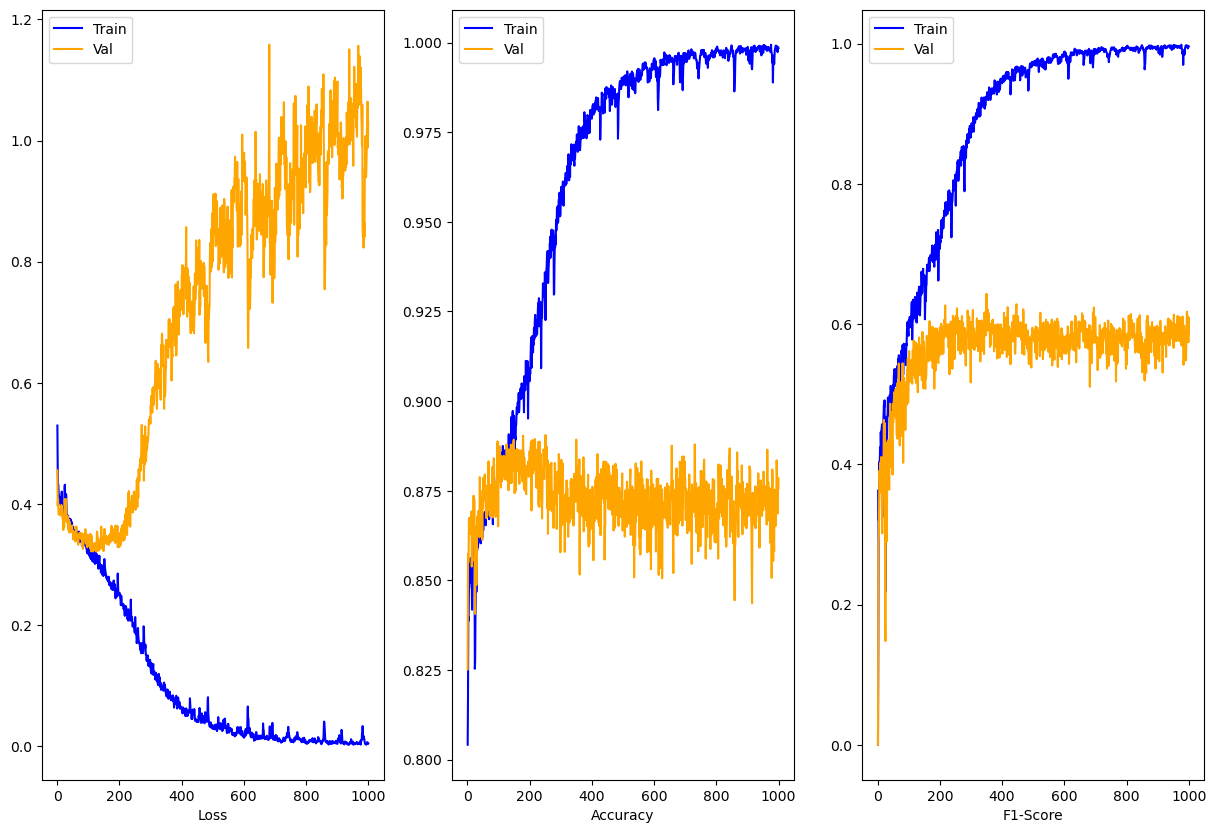

In [11]:
display_metrics(NUM_EPOCHS, metrics)

In [18]:
metrics["eval"]["f1"]

[0.0,
 0.2851559255809437,
 0.29241539273901734,
 0.3047771817093329,
 0.36682449173539694,
 0.39105464938150575,
 0.37724848343573264,
 0.35992030938708547,
 0.40268433571185863,
 0.38258737796488185,
 0.41016690477419954,
 0.4102899343111385,
 0.4040034096162737,
 0.30495047736427044,
 0.3015245551234838,
 0.3338296669854795,
 0.374260815437286,
 0.40967840194946775,
 0.41361634997998636,
 0.463231850117096,
 0.41866253803720177,
 0.45906593406593404,
 0.4364235583747778,
 0.18624816805080605,
 0.14797026872498573,
 0.3109799210906676,
 0.34810120760403357,
 0.4215088682041308,
 0.2901433691756272,
 0.3330846054530265,
 0.43076362310916716,
 0.4060744755793719,
 0.43418382367506636,
 0.36528211751308864,
 0.40392156862745104,
 0.41285666809096516,
 0.3636992426089964,
 0.4344547964113181,
 0.39711854986960793,
 0.4864111020996666,
 0.3968193729104545,
 0.46354682873616954,
 0.45244175840444995,
 0.4742775742775743,
 0.4371699905033239,
 0.41548582995951416,
 0.43469280180445224,
 0.3